In [1]:
import torch
import torch.nn as nn
import gym
from itertools import count
import numpy as np
import random
import torch.nn.functional as F
import itertools

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[-2]).unwrapped

discrete_actions = False
#TODO
#parralel fitness measuring
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt
import random

#seed = 69
#random.seed(seed)
#np.random.seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.manual_seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Creature(nn.Module):
    def __init__(self):
        super(Creature, self).__init__()
    
        self.layer1 = nn.Linear(env.observation_space.shape[0], 20)
        self.layer2 = nn.Linear(20, 20)
        
        if discrete_actions:
            self.layer3 = nn.Linear(20, env.action_space.n)
        else:
            self.layer3 = nn.Linear(20, env.action_space.shape[0])
    
    def forward(self, x):
        out = self.layer1(x)
        #out = self.layer2(out)
        out = self.layer3(out)
        return out
input_num = (len(get_params(Creature()))*2)+1 
output_num = len(get_params(Creature()))
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose1d(input_num, 128, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(True))
        
        
        self.layer5 = nn.Linear(16*13, output_num)
        
    def forward(self, mom,dad,a):
        #print(a)
        out = torch.cat([mom,dad,a]).unsqueeze(0)
        out = out.unsqueeze(-1)
        #print(out.shape)
        out = self.layer1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        out = self.layer5(out)
        if a >= 0:
            z = torch.zeros(mom.shape).to(device)
            mom_func = (mom+(torch.tanh(out+3)*a)) * (torch.min(mom,z)/(mom+0.000001))
            dad_func = (dad+(torch.tanh(-out+3)*a)) * (torch.max(dad,z)/(dad+0.000001))
            out = mom_func + dad_func
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 8, 5, stride=1, padding=0),  
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer4 = nn.Linear(16*977, 128)
        self.layer5 = nn.Sequential(       
            nn.Linear(128, 1))#,
            #nn.Sigmoid())
    def forward(self, out):
        
        out = out.unsqueeze(1)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        
        out = self.layer4(out)
        out = self.layer5(out)
        #out = torch.pow(out,3)*10
        
        return out

all_a = 0
a = np.array([random.randint(0,1000)/10000])
a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
gen = Generator().to(device)
gen(torch.zeros([(len(get_params(Creature())))]).to(device),
   torch.zeros([(len(get_params(Creature())))]).to(device),
   a).shape

dis = Discriminator().to(device)
dis(torch.zeros([10,len(get_params(Creature()))]).to(device)).shape    

torch.Size([10, 1])

In [3]:
def mate(m,d,mutation_rate_m,mutation_rate_d,child_mutation_rate,use_gen,mutation_scale=0.07):
    child = Creature()
    mom = (m)
    dad = (d)
    mutation_rate = np.min([mutation_rate_m,mutation_rate_d])
    #mom = mutate(mom,mutation_rate_m,mutation_scale)
    #dad = mutate(dad,mutation_rate_d,mutation_scale)
    mom = get_params(mom)
    dad = get_params(dad)
    if random.randint(0,100) < 0:
        a = np.array([random.uniform(0.01,0.2)])
        a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")

    else:
        a = np.array([all_a])
        a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")
    
    generated = use_gen(mom,dad,a).squeeze(0)
    child = set_params(child,generated)

    child = mutate(child,mutation_rate,mutation_scale)
    #child = mutate(child,np.mean([mutation_rate_m,mutation_rate_d]),mutation_scale)
    
    return child

def mutate(creature,mutation_rate=0.2,scale = 0.07,start_layer = 0):
    if mutation_rate != 0:
        new = creature.__class__().to(device)
        new.load_state_dict(creature.state_dict()) 
        for idx,p in enumerate(new.parameters()):
            if idx < start_layer:
                continue
            mutation = np.random.normal(scale = scale,size = p.data.shape)
            mutation *= np.random.choice([1, 0], p.data.shape,p=[mutation_rate,1-mutation_rate])
            mutation = torch.from_numpy(mutation).type('torch.FloatTensor').to(device)
            p.data += mutation
        return new
    else:
        return creature

def evolve(population,out_size,use_gen,use_inn,p_fitness,child_mutation_rate,mutation_rate,mutation_scale):
    pick_probabilities = get_pick_probabilities(p_fitness)
    print("Pick prob : {}".format(pick_probabilities))
    choice = np.random.choice(pick_probabilities.size,out_size+1, p = pick_probabilities)
    print(choice)
    new_population = []
    parent_fitness = []
    for p in range(out_size-1):
        #if p == out_size-2:
        #    u_gen=use_inn
       # else:
        u_gen = use_gen
        
        
        first_choice = population[choice[p]]
        
        #no incest
        second_choice = choice[np.where(choice!=choice[p])]
        if second_choice.size !=0:
            second_choice = second_choice[random.randint(0,second_choice.size-1)]
            second_choice = population[second_choice]
        else:
            second_choice = first_choice
        
        #second_choice = population[choice[p+1]]
        par_fit = np.max([p_fitness[choice[p]],p_fitness[choice[p+1]]])
        
        
        child = mate(first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],child_mutation_rate,u_gen,mutation_scale).to(device)
        
        parent_fitness.append(par_fit)
        new_population.append(child)
        
        
    parent_fitness.append(np.max([p_fitness[0],p_fitness[len(p_fitness)-1]]))
    
    new_population.append(child)
    
    return new_population, np.array(parent_fitness)



In [4]:
def gen_children(population,use_gen,batch_size, a = 0.1):
    mom = []
    dad = []
    child = []
    for b in range(batch_size):
        m = get_params(random.choice(population))
        d = get_params(random.choice(population))

        a = np.array([a])
        a = torch.from_numpy(a).to(device).type("torch.cuda.FloatTensor")


        c = use_gen(m,d,a).squeeze(0)

        mom.append(m)
        dad.append(d)
        child.append(c)

    mom = torch.stack(mom).to(device)
    dad = torch.stack(dad).to(device)
    child = torch.stack(child).to(device)
    return child    
        
def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    
    p_fitness = torch.from_numpy(p_fitness).to(device).type("torch.cuda.FloatTensor")
    gen_error = 0
    dis_error_fake = 0
    dis_error_real = 0
    e = 0
    
    gen_loss_all = []
    dis_loss_all = []
    rec_loss_all = []
    inn_loss_all = []
    for e in range(n_epochs):
        
        #shuffle arrays in unison
        #ind = np.arange(len(population))
        #np.random.shuffle(ind)
        #population = np.array(population)[ind]
        #p_fitness = p_fitness[ind]
        
        for i in range(len(population)//batch_size):

            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            if e % 1 == 0:
                #train discriminator on population

                dis_out_r = dis(real_batch).squeeze(-1)
                rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]

                dis_error_real = (nn.MSELoss()(dis_out_r,rank))
                
                if e == n_epochs-1:
                    print(dis_out_r)
                dis_error_real.backward()
                
        
           
            child = gen_children(population,gen,batch_size,a = all_a)
            dis_out_f = dis(child).squeeze(-1)
            
            if e % 1== 0 :#and torch.max(dis_out_f)>torch.min(p_fitness):
                #train discriminator on generator output
                
                dis_error_fake = torch.mean(dis_out_f) 
                #if torch.max(dis_out_inn)>torch.min(p_fitness):
                #    dis_error_fake += torch.mean(dis_out_inn)
                
                dis_error_fake.backward(retain_graph=True)

            dis_optimizer.step() 
            
            #train generator
            
            gen_error = -torch.mean(dis_out_f)
            total_gen_error = gen_error 
            total_gen_error.backward()
            gen_optimizer.step()
            
            #inn_child = gen_children(population,inn,batch_size,a = 1)
            #dis_out_inn = dis(inn_child).squeeze(-1)
            #inn_error =  -torch.mean(dis_out_inn)
            #inn_error.backward()
            #inn_optimizer.step()
            
        gen_loss_all.append(gen_error)
        dis_loss_all.append(dis_error_fake)#+dis_error_real)
        rec_loss_all.append(dis_error_real)    
        inn_loss_all.append(0)    
        #if e %  5 == 0:    
        #print("Discriminator loss real : {}".format(dis_error_real))
        #print("Discriminator loss generated : {}".format(dis_error_fake))
        #print("Generator loss : {}".format(gen_error))
        #print("Child error : {}".format(child_error*0.1))
        #print("")
    return gen_loss_all, dis_loss_all, rec_loss_all, inn_loss_all

starting training
1004
[0.39999999 0.1       ]
population fitness : [-93.45703929 -10.67430254]
mean fit : -52.065670913310406
population fitness : [-0.99999999  0.99999999]


/home/liam/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/liam/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
/home/liam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


tensor([-1.0495,  0.2762], device='cuda:0', grad_fn=<SqueezeBackward1>)


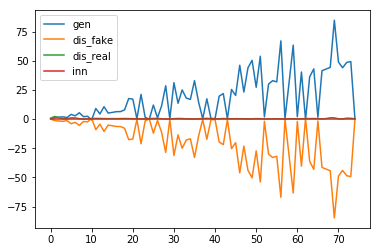

Pick prob : [0.5 0.5]
[0 1 1 0 1]
Generation 1  fitness : 0.9999999927039057
#################################
[0.1        0.46004248 0.46324553 0.46232903]
population fitness : [ -15.52901126 -111.41569227 -112.08330404 -111.89227772]
mean fit : -87.73007132516597
population fitness : [ 1.73202134 -0.56819112 -0.58420636 -0.57962386]
tensor([ 1.5954, -1.0367, -0.5463, -0.5463],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


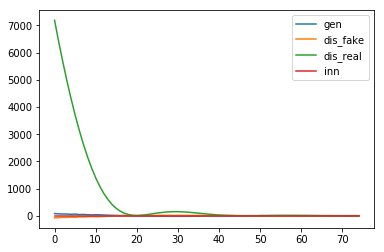

Pick prob : [0.99118558 0.00685342 0.         0.001961  ]
[0 0 0 0 0 0 0]
Generation 2  fitness : 1.7320213359149128
#################################
[0.6754974  0.1        0.35904279 0.22497638 0.28838478 0.29367971]
population fitness : [-17.85976027 -13.9337005  -16.02049382 -15.24128616 -15.60982227
 -15.6405969 ]
mean fit : -15.71760998757481
population fitness : [-1.84282065  1.53463801 -0.26056089  0.40976555  0.09272618  0.06625179]
tensor([-2.2914,  0.8800, -0.8521, -0.2423, -0.3938, -0.3938],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


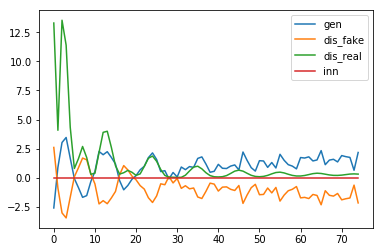

Pick prob : [0.         0.30546097 0.14310126 0.2037263  0.17505292 0.17265855]
[1 5 1 1 1 5 1 5 1]
Generation 3  fitness : 1.534638008530756
#################################
[0.14991983 0.1        0.23471949 0.57957847 0.1        0.54078738
 0.34611218 0.35223105]
population fitness : [-13.06345262 -11.85875369 -13.74487059 -16.51602669 -12.21922202
 -16.20431616 -14.63998001 -14.68914896]
mean fit : -14.116971340792238
population fitness : [ 0.6555276   1.40512357  0.23153107 -1.49275657  1.18083051 -1.29880192
 -0.32543002 -0.35602425]
tensor([ 0.2623,  0.7460, -0.3604, -2.0833,  0.7792, -1.9504, -0.9761, -0.9761],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


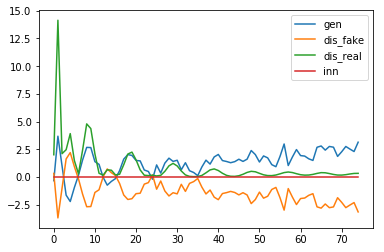

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[3 4 0 7 6 2 6 6 1]
Generation 4  fitness : 1.4051235716976684
#################################
[0.41841163 0.35674807 0.46317625 0.37865595 0.43005123 0.1
 0.68021784 0.68174197]
population fitness : [-14.51929823 -12.65608356 -15.87189754 -13.31804791 -14.87099822
  -1.87665077 -22.42998536 -22.47603821]
mean fit : -14.75237497639171
population fitness : [ 0.03856866  0.34688643 -0.18525439  0.23734705 -0.01962933  2.13062646
 -1.27046212 -1.27808277]
tensor([-0.5349, -0.0195, -0.7630, -0.0033, -0.4741,  1.5862, -1.8327, -1.8327],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


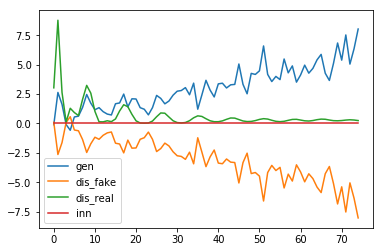

Pick prob : [0.12877212 0.15892644 0.10688161 0.14821319 0.1230802  0.33338111
 0.00074532 0.        ]
[2 4 5 0 5 3 3 4 0]
Generation 5  fitness : 2.130626459188214
#################################
[0.63308154 0.1        0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [-112.41750925  -13.54263475   -6.07265739  -13.27687898   -6.53524405
   -6.69548902  -19.2176121   -17.65703355]
mean fit : -24.42688238762165
population fitness : [-2.61908505  0.32397508  0.54632269  0.33188543  0.53255357  0.5277838
  0.15505654  0.20150794]
tensor([-3.2512, -0.2298, -0.3107, -0.5402, -0.1449,  0.2681, -0.1097, -0.1097],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


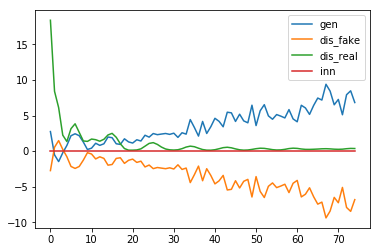

Pick prob : [0.         0.14046223 0.15107412 0.14083976 0.15041697 0.15018932
 0.13240032 0.13461729]
[1 5 4 4 6 2 6 6 1]
Generation 6  fitness : 0.5463226945779579
#################################
[0.39786597 0.43049763 0.1        0.1        0.39695624 0.39818623
 0.1        0.1       ]
population fitness : [ -93.55229595 -100.08832115  -14.95459718  -13.86089973  -93.37007881
  -93.61644243  -15.23394916  -16.5537176 ]
mean fit : -55.153787752353345
population fitness : [-0.95853887 -1.12169714  1.00348916  1.03079104 -0.9539902  -0.96014015
  0.99651572  0.96357044]
tensor([-1.6770, -1.7714,  0.4605,  0.6555, -1.4909, -1.7599,  0.3237,  0.3237],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


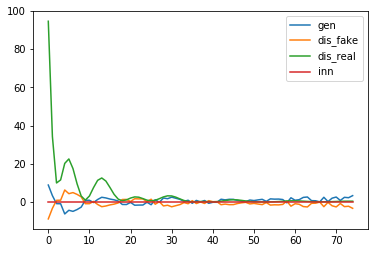

Pick prob : [0.01818208 0.         0.23682711 0.23986958 0.01868897 0.01800363
 0.23605    0.23237863]
[2 0 6 6 7 2 3 2 6]
Generation 7  fitness : 1.0307910394077469
#################################
[0.36737166 0.47877265 0.1        0.1        0.1        0.1
 0.37262895 0.37279934]
population fitness : [ -95.12509501 -120.07606091  -13.02892217  -12.84325823  -14.76714161
  -13.80054627  -96.30259251  -96.34075411]
mean fit : -57.785546352756214
population fitness : [-0.83356746 -1.39057241  0.99914613  1.00329089  0.96034215  0.98192041
 -0.8598539  -0.86070582]
tensor([-1.2498, -2.4247,  0.5577,  0.1930,  0.1745,  0.7551, -0.9787, -0.9787],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


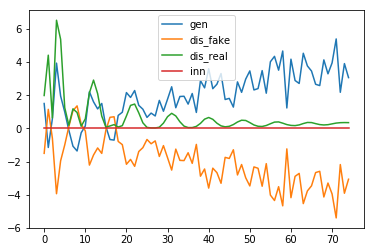

Pick prob : [0.05006975 0.         0.21481428 0.21518686 0.21132615 0.21326585
 0.04770684 0.04763026]
[4 7 2 5 5 3 4 4 3]
Generation 8  fitness : 1.0032908907955895
#################################
[0.1        0.63722077 0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [-15.45192945 -94.25801864  -8.55962568  -9.56235836 -13.72612632
 -12.87269448 -16.85846663 -16.69511583]
mean fit : -23.498041924004497
population fitness : [ 0.29913922 -2.63072189  0.55538202  0.51810232  0.36330131  0.39503029
  0.24684683  0.2529199 ]
tensor([-0.2379, -3.1965, -0.0763,  0.2115,  0.2215, -0.0415, -0.3258, -0.3258],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


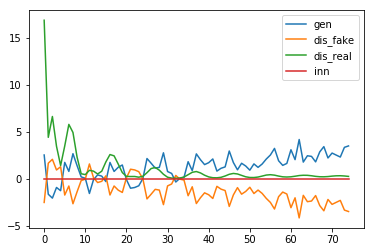

Pick prob : [0.13921374 0.         0.15138924 0.14961788 0.14226243 0.14377005
 0.13672904 0.13701761]
[0 0 6 3 6 5 6 2 2]
Generation 9  fitness : 0.5553820168071202
#################################
[0.56052572 0.60519332 0.35140617 0.1        0.42225594 0.1
 0.41996221 0.42293356]
population fitness : [-19.61225879 -20.47568173 -15.56998604 -10.31665568 -16.93950933
  -8.77731825 -16.89517163 -16.95260763]
mean fit : -15.692398635593424
population fitness : [-1.01393319 -1.23727105  0.03166393  1.39052006 -0.3225847   1.78869379
 -0.31111606 -0.32597278]
tensor([-1.5673, -1.6905, -0.4019,  1.1675, -0.9836,  1.2879, -0.9282, -0.9282],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


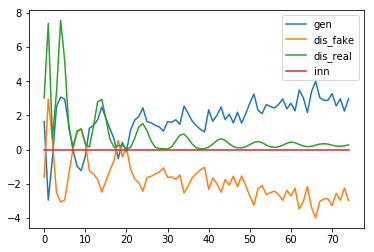

Pick prob : [0.02256355 0.         0.12819897 0.26548256 0.09240966 0.30570957
 0.09356832 0.09206736]
[7 5 4 5 5 5 5 7 0]
Generation 10  fitness : 1.788693785301864
#################################
[0.39032941 0.1        0.38960269 0.1        0.1        0.49104101
 0.1        0.1       ]
population fitness : [ -99.13783979  -23.29926177  -98.97050271   -9.25842514  -11.66926039
 -122.32825205  -10.68059406  -10.50226562]
mean fit : -48.23080019190881
population fitness : [-1.10539854  0.54136494 -1.10176498  0.84624851  0.79389949 -1.60895656
  0.81536745  0.81923969]
tensor([-1.5164,  0.3152, -1.5993,  0.3043,  0.5856, -2.1488,  0.2432,  0.2432],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


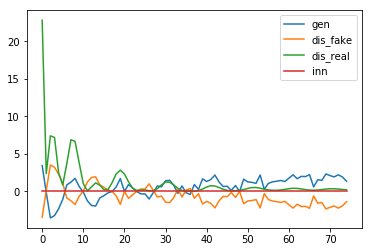

Pick prob : [0.03912147 0.1670587  0.03940377 0.19074513 0.18667813 0.
 0.18834598 0.18864682]
[0 3 7 1 1 3 4 4 3]
Generation 11  fitness : 0.846248513977832
#################################
[0.1        0.1        0.1        0.50028115 0.1        0.1
 0.40704401 0.40123769]
population fitness : [ -17.0323443   -20.10643832  -11.12633438 -117.63398706  -19.50295836
  -17.46232978  -97.78421214  -96.54807099]
mean fit : -49.64958441736346
population fitness : [ 0.76603841  0.69384119  0.90474513 -1.59666064  0.70801433  0.7559399
 -1.13047497 -1.10144334]
tensor([ 0.3435,  0.2306,  0.2089, -2.2496,  0.0118,  0.3527, -1.6317, -1.6317],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


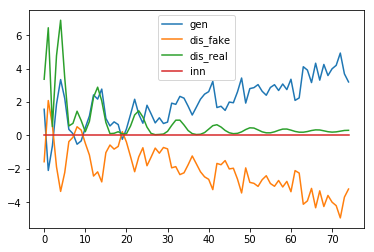

Pick prob : [0.18497192 0.17931971 0.19583104 0.         0.18042931 0.18418132
 0.03649693 0.03876977]
[0 6 2 4 7 2 5 2 2]
Generation 12  fitness : 0.9047451275866886
#################################
[0.65147275 0.32403927 0.34738763 0.11084436 0.1        0.31739786
 0.50337975 0.50602615]
population fitness : [-18.90135558 -10.81096737 -11.38787008  -5.54324206  -2.80444496
 -10.6468681  -15.24220044 -15.30758899]
mean fit : -11.330567199216361
population fitness : [-1.53202093  0.10514596 -0.01159578  1.17112021  1.72534181  0.13835301
 -0.79155614 -0.80478813]
tensor([-1.8638, -0.4138, -0.5383,  0.5894,  0.9724, -0.2527, -1.2372, -1.2372],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


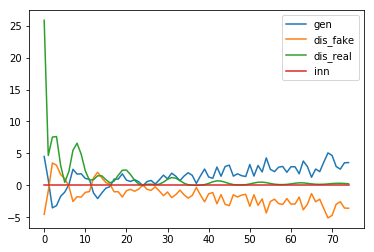

Pick prob : [0.         0.13357902 0.12405388 0.22055354 0.26577335 0.13628844
 0.06041569 0.05933607]
[5 7 2 4 4 1 5 3 5]
Generation 13  fitness : 1.7253418136080747
#################################
[0.1        0.1        0.1        0.38865297 0.4892099  0.36228585
 0.1        0.1       ]
population fitness : [ -13.93316793  -10.13996417  -10.29329243 -100.43889702 -124.07081802
  -94.24235097   -9.10142666   -9.41395605]
mean fit : -46.45423415675888
population fitness : [ 0.69190711  0.77261002  0.76934786 -1.14855927 -1.65134397 -1.01672367
  0.79470559  0.78805632]
tensor([ 0.3906,  0.3051,  0.2190, -1.7235, -1.9675, -1.2474,  0.1940,  0.1940],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


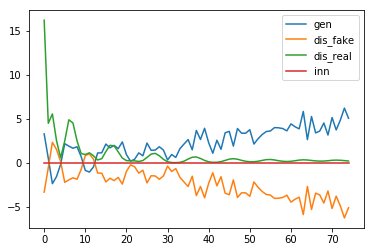

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 0 0 5 7 1 6 2 7]
Generation 14  fitness : 0.7947055922646773
#################################
[0.1        0.4583055  0.1        0.50393313 0.1        0.1
 0.1        0.1       ]
population fitness : [ -13.95161588  -95.33102604  -18.1406972  -103.98394498  -10.63150793
  -11.80342085   -8.41700772  -11.57294077]
mean fit : -34.2290201715071
population fitness : [ 0.53462297 -1.61098212  0.42417594 -1.83912026  0.62215912  0.59126111
  0.68054542  0.59733782]
tensor([-0.0834, -2.2762, -0.2040, -2.3671,  0.0201,  0.2551,  0.3420,  0.3420],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


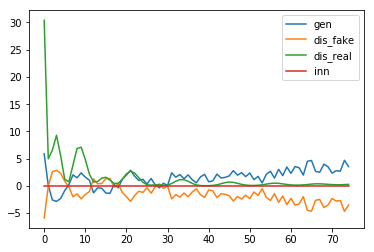

Pick prob : [0.16133687 0.01550593 0.15383008 0.         0.16728646 0.16518641
 0.17125482 0.16559943]
[5 4 0 0 0 5 5 5 5]
Generation 15  fitness : 0.6805454248394444
#################################
[0.1        0.1        0.34811286 0.1        0.1        0.1
 0.46210049 0.4616748 ]
population fitness : [ -16.20752754  -13.29741234  -93.05406333   -8.80402512   -8.78321873
  -17.65019727 -120.64808505 -120.54503606]
mean fit : -49.873695679876704
population fitness : [ 0.69535474  0.75546144 -0.89186488  0.84826969  0.84869943  0.66555725
 -1.46180304 -1.45967462]
tensor([ 0.1040,  0.0087, -1.2336,  0.5028,  0.4869, -0.1203, -2.0504, -2.0504],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


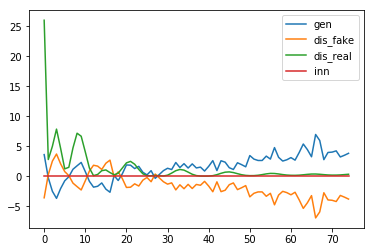

Pick prob : [1.84460365e-01 1.89600139e-01 4.87358880e-02 1.97536250e-01
 1.97572998e-01 1.81912357e-01 0.00000000e+00 1.82002608e-04]
[2 2 2 3 4 4 4 5 0]
Generation 16  fitness : 0.8486994306312292
#################################
[0.12643106 0.64170485 0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -27.08939805 -102.37013803  -15.66017279   -9.93458697  -16.83431679
  -22.95800824  -10.48356393   -8.61800696]
mean fit : -26.743523968771388
population fitness : [-0.01183702 -2.58820603  0.37931086  0.57526035  0.33912757  0.12955353
  0.55647244  0.6203183 ]
tensor([-0.3894, -2.9111, -0.0449, -0.3811, -0.0612, -0.1975,  0.1340,  0.1340],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


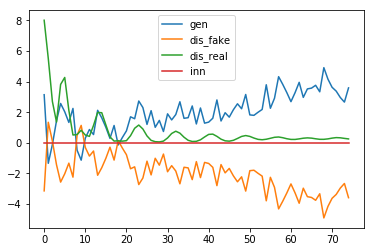

Pick prob : [0.12442832 0.         0.1433192  0.15278277 0.14137851 0.13125692
 0.15187539 0.15495889]
[0 3 2 3 6 4 3 6 3]
Generation 17  fitness : 0.6203182971903585
#################################
[0.66238477 0.1        0.18949616 0.10114217 0.14869787 0.1
 0.1        0.1       ]
population fitness : [-93.48756918  -6.30493477 -31.24629011 -19.61719804 -25.87644774
 -13.89646495 -11.9508649  -12.06657624]
mean fit : -26.80579324003979
population fitness : [-2.53313027  0.77879367 -0.16868712  0.27308283  0.0353043   0.49040401
  0.56431413  0.55991845]
tensor([-2.8595,  0.0483, -0.6982, -0.3204, -0.5923,  0.1249, -0.1534, -0.1534],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


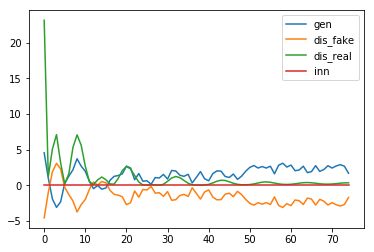

Pick prob : [0.         0.1634304  0.11667595 0.13847556 0.12674213 0.14919951
 0.15284668 0.15262977]
[3 1 3 2 2 3 7 3 5]
Generation 18  fitness : 0.778793671562453
#################################
[0.50331481 0.50067886 0.1        0.11323461 0.1        0.1
 0.1        0.1       ]
population fitness : [-98.61786337 -98.12745051 -11.15676048 -26.0443272  -17.51996801
  -4.9772842  -11.05546466 -10.18457076]
mean fit : -34.710461149603205
population fitness : [-1.71750019 -1.70432043  0.63300156  0.23290082  0.46199148  0.7990739
  0.63572387  0.65912899]
tensor([-2.0519, -2.3765, -0.0515, -0.1370,  0.0429,  0.0560,  0.0398,  0.0398],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


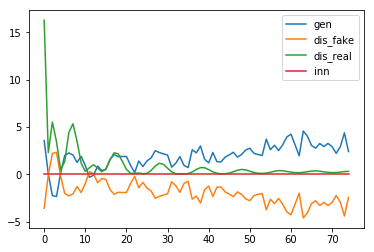

Pick prob : [0.         0.00095923 0.17106998 0.14195057 0.15862383 0.18315675
 0.17126811 0.17297154]
[7 5 2 5 2 5 4 3 7]
Generation 19  fitness : 0.7990738973038563
#################################
[0.1        0.1        0.44050472 0.53889448 0.1        0.1
 0.1        0.1       ]
population fitness : [  -6.28842861  -14.62630852  -93.61255009 -113.12803956   -6.23897461
  -17.03634025  -18.01867284  -15.63445397]
mean fit : -35.572971055279965
population fitness : [ 0.73820828  0.52802599 -1.4630687  -1.95501751  0.73945492  0.46727362
  0.44251087  0.50261254]
tensor([ 0.2729,  0.1698, -2.1217, -2.5601,  0.2260, -0.1741,  0.0438,  0.0438],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


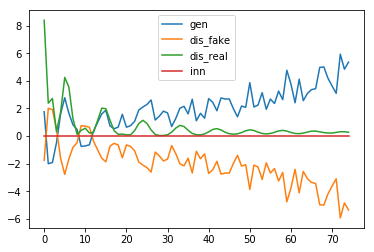

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[0 3 4 1 4 5 2 7 2]
Generation 20  fitness : 0.7394549182448796
#################################
[0.1        0.1        0.44215004 0.53776532 0.1        0.1
 0.1        0.1       ]
population fitness : [ -12.66207688  -12.79673892  -97.75419712 -117.98047861  -12.63036736
  -22.6132405    -4.22258731   -4.89282194]
mean fit : -35.69406358071882
population fitness : [ 0.54439317  0.54121025 -1.46687793 -1.94495434  0.54514267  0.30918352
  0.74387229  0.72803036]
tensor([ 0.4134, -0.0466, -2.0145, -2.3502,  0.2506, -0.2951,  0.3653,  0.3653],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


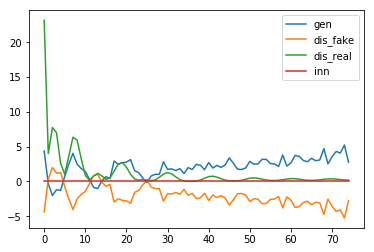

Pick prob : [0.15998753 0.15978297 0.03072543 0.         0.1600357  0.14487087
 0.17280783 0.17178968]
[7 7 6 6 0 6 1 1 4]
Generation 21  fitness : 0.7438722948589118
#################################
[0.42577206 0.42276618 0.1        0.45219976 0.1        0.1
 0.1        0.1       ]
population fitness : [ -95.38398348  -94.76407533  -12.69312875 -100.83420285  -17.56907125
   -7.57644359  -10.99683044  -11.31822951]
mean fit : -43.891995649926535
population fitness : [-1.24840363 -1.23337419  0.75640464 -1.38054212  0.63818927  0.88045672
  0.79753075  0.78973855]
tensor([-1.3846, -1.4220,  0.2668, -1.7692,  0.3837,  0.5055, -0.1684, -0.1684],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


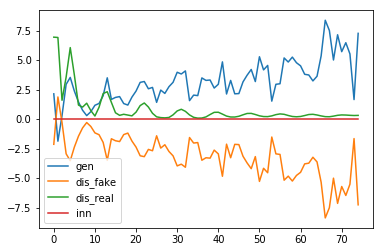

Pick prob : [0.01196437 0.01332519 0.19348801 0.         0.1827843  0.2047202
 0.19721174 0.1965062 ]
[2 6 7 4 6 7 4 7 6]
Generation 22  fitness : 0.8804567231289412
#################################
[0.1        0.1        0.1        0.62801519 0.1        0.1
 0.1        0.1       ]
population fitness : [  -8.30726701  -12.4423684   -12.0236286  -119.75858672  -12.08322119
  -16.05715739  -14.44174015  -12.99420849]
mean fit : -26.01352224372955
population fitness : [ 0.49886343  0.38235935  0.3941571  -2.64121258  0.39247812  0.28051478
  0.32602822  0.36681158]
tensor([-0.0839, -0.1134, -0.2770, -3.3539, -0.3570,  0.0391, -0.2259, -0.2259],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


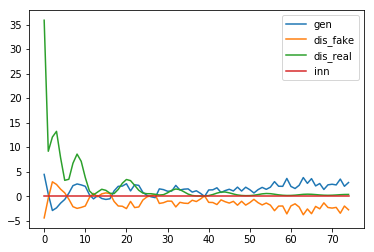

Pick prob : [0.14860958 0.14309582 0.14365417 0.         0.14357471 0.13827585
 0.14042986 0.14236   ]
[6 0 0 4 4 5 4 2 2]
Generation 23  fitness : 0.4988634258581729
#################################
[0.63781745 0.1        0.1        0.10026866 0.135471   0.1
 0.1        0.1       ]
population fitness : [-97.03612289 -15.40858873 -10.08076151 -20.98331079 -25.96376428
  -9.41502147  -6.79722411  -7.20625073]
mean fit : -24.111380564068686
population fitness : [-2.57719646  0.30756097  0.49584902  0.11054753 -0.06546416  0.5193766
  0.61189085  0.59743565]
tensor([-3.0263, -0.0753, -0.0690, -0.5027, -0.5488, -0.0371,  0.0148,  0.0148],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


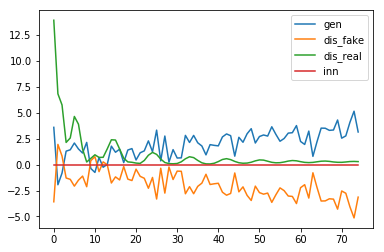

Pick prob : [0.         0.13991742 0.14904983 0.13036181 0.12182484 0.15019097
 0.15467812 0.15397701]
[4 2 7 1 4 5 1 7 3]
Generation 24  fitness : 0.6118908532279714
#################################
[0.1        0.1        0.1        0.4818993  0.1        0.1
 0.40863302 0.40569042]
population fitness : [ -11.13839091  -15.88368528  -17.79486135 -120.42875292  -14.79505044
  -21.08723256 -103.81262962 -103.14527309]
mean fit : -51.010734520306535
population fitness : [ 0.87905532  0.77443704  0.73230183 -1.53044123  0.79843789  0.65971576
 -1.16410982 -1.14939679]
tensor([ 0.5561,  0.1187,  0.2179, -2.3299,  0.5841, -0.0236, -1.7599, -1.7599],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


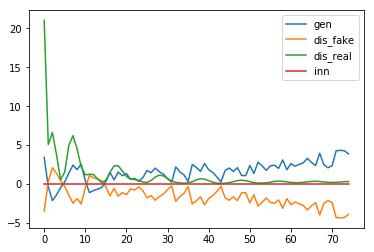

Pick prob : [0.19679754 0.18825276 0.18481133 0.         0.19021305 0.17888281
 0.02992041 0.03112211]
[2 4 5 4 4 1 0 5 4]
Generation 25  fitness : 0.8790553220158375
#################################
[0.1        0.1        0.63209482 0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -22.51756361  -11.28911369 -105.43282735  -18.80155931  -12.88940931
  -21.96425332  -10.10037714  -10.14680818]
mean fit : -26.642738988261215
population fitness : [ 0.13675837  0.50900545 -2.61205958  0.25995184  0.45595223  0.15510178
  0.5484146   0.54687531]
tensor([-0.3982,  0.2699, -3.4401, -0.2068,  0.2342, -0.1713,  0.0778,  0.0778],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


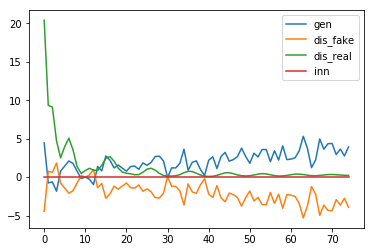

Pick prob : [0.13154457 0.14935843 0.         0.13743998 0.14681957 0.13242239
 0.15124436 0.15117069]
[6 5 7 5 5 3 1 4 0]
Generation 26  fitness : 0.5484145993994634
#################################
[0.38996805 0.1        0.1        0.1        0.1        0.1
 0.47652051 0.47650842]
population fitness : [ -94.34000926  -10.44434501   -4.39391337  -19.47211968  -21.24824158
  -12.65179074 -114.30332516 -114.30053643]
mean fit : -48.89428515269506
population fitness : [-0.98516676  0.83351303  0.96467353  0.63781005  0.5993075   0.78566029
 -1.41792905 -1.41786859]
tensor([-1.7601,  0.5343,  0.5832,  0.2749,  0.1197,  0.4978, -1.9135, -1.9135],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


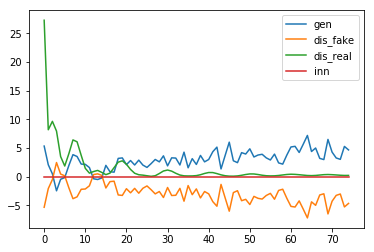

Pick prob : [3.81509114e-02 1.98479790e-01 2.10042472e-01 1.81227254e-01
 1.77832994e-01 1.94261249e-01 0.00000000e+00 5.32940598e-06]
[4 2 3 5 2 1 1 0 5]
Generation 27  fitness : 0.9646735331924579
#################################
[0.1        0.1        0.1        0.1        0.11469456 0.1
 0.50712668 0.5074208 ]
population fitness : [ -11.5460235   -15.96405768   -6.77571175  -16.81532512  -28.13976708
  -18.16265396 -101.23775769 -101.29254262]
mean fit : -37.49172992560745
population fitness : [ 0.6964575   0.57786474  0.82450641  0.55501427  0.25103362  0.51884808
 -1.71112702 -1.71259761]
tensor([ 0.1831,  0.1777,  0.3512,  0.1529, -0.0246, -0.3131, -2.2599, -2.2599],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


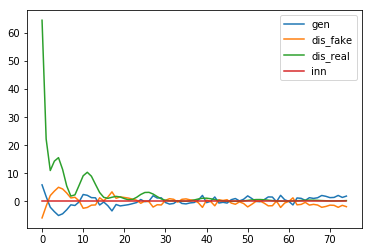

Pick prob : [1.75833417e-01 1.67177504e-01 1.85179520e-01 1.65509681e-01
 1.43322578e-01 1.62869964e-01 1.07335881e-04 0.00000000e+00]
[3 3 0 2 3 5 5 0 3]
Generation 28  fitness : 0.8245064142494515
#################################
[0.1        0.65227818 0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -10.06803362 -115.12668421  -22.51556774  -15.39858515  -19.50181275
  -18.52768554  -21.33827006  -21.43599003]
mean fit : -30.489078636515554
population fitness : [ 0.63394125 -2.62744973  0.24752589  0.46846213  0.34108348  0.37132382
  0.28407337  0.28103979]
tensor([ 0.0558, -3.4225, -0.3081,  0.0476, -0.2221,  0.2437, -0.0932, -0.0932],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


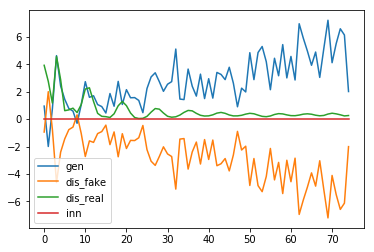

Pick prob : [0.15515953 0.         0.13677596 0.14728692 0.14122693 0.1426656
 0.13851469 0.13837037]
[7 7 4 2 2 5 5 4 5]
Generation 29  fitness : 0.6339412478322478
#################################
[0.1        0.1        0.63186069 0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -21.878055    -25.04331275 -114.269661    -17.71710109  -16.04655008
  -14.66902737  -20.19269048  -20.24631004]
mean fit : -31.25783847627232
population fitness : [ 0.29752404  0.19712297 -2.63311117  0.4295083   0.4824977   0.52619232
  0.35098332  0.34928252]
tensor([-0.4198, -0.4802, -3.1665, -0.3328, -0.1299,  0.1373, -0.0767, -0.0767],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


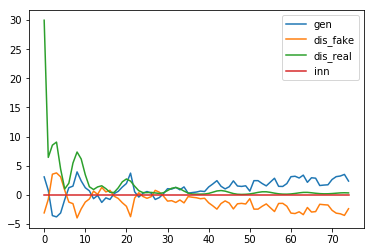

Pick prob : [0.13912417 0.13435789 0.         0.14538977 0.1479053  0.14997959
 0.14166201 0.14158127]
[7 0 1 5 5 1 4 0 4]
Generation 30  fitness : 0.5261923244150689
#################################
[0.1        0.1        0.1        0.64504965 0.1        0.1
 0.1        0.1       ]
population fitness : [ -18.88088528  -17.5443971   -20.58879742 -100.94678884  -14.52775668
  -22.21649286  -25.11085896  -25.29181884]
mean fit : -30.63847449717737
population fitness : [ 0.43880548  0.48868461  0.37506442 -2.62397954  0.60126877  0.31431713
  0.20629637  0.19954276]
tensor([-0.0712, -0.2604, -0.0052, -3.1693, -0.0824, -0.0870, -0.2497, -0.2497],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


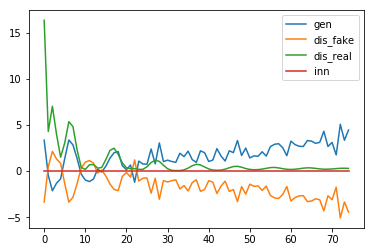

Pick prob : [0.14590363 0.14827975 0.14286716 0.         0.15364298 0.1399733
 0.13482746 0.13450573]
[1 4 6 5 5 5 4 6 5]
Generation 31  fitness : 0.6012687727755132
#################################
[0.1        0.66927786 0.1        0.16753284 0.1        0.15099493
 0.1        0.1       ]
population fitness : [ -19.1344375  -100.95632822  -10.67515436  -33.27423089  -22.35094148
  -31.04337533  -21.07705859  -16.74673443]
mean fit : -31.907282599302494
population fitness : [ 0.47344215 -2.55939284  0.7869965  -0.05066772  0.35421824  0.03202185
  0.40143636  0.56194547]
tensor([-0.2084, -3.1225,  0.0631, -0.4041,  0.1040, -0.2819,  0.0294,  0.0294],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


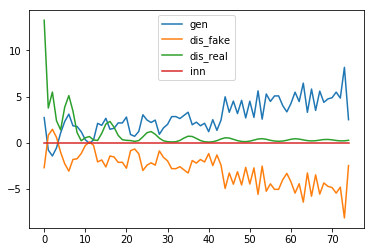

Pick prob : [0.14812278 0.         0.16343668 0.1225254  0.14229992 0.12656394
 0.14460603 0.15244525]
[2 2 0 0 6 4 6 0 2]
Generation 32  fitness : 0.7869964979414911
#################################
[0.2239757  0.41044568 0.36563601 0.72621262 0.1        0.14964409
 0.36660528 0.36714412]
population fitness : [-18.14295871 -22.71349872 -21.6151751  -30.45321873 -12.65312114
 -16.32102696 -21.63893278 -21.6521402 ]
mean fit : -20.648759041554996
population fitness : [ 0.51116103 -0.42118857 -0.1971403  -2.00002276  1.63103917  0.88281894
 -0.20198665 -0.20468085]
tensor([-0.0022, -1.1106, -0.5567, -2.7596,  1.1692,  0.3346, -0.8075, -0.8075],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


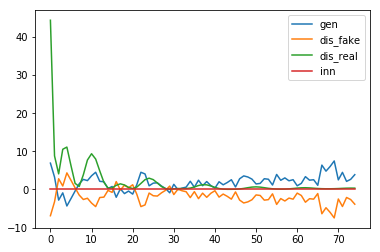

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 2 0 7 4 7 1 5 7]
Generation 33  fitness : 1.631039172436624
#################################
[0.68656499 0.14599489 0.12867153 0.1        0.1        0.1023292
 0.18098761 0.18158809]
population fitness : [-99.61562364 -29.5890228  -27.34491828 -10.67653405 -15.124902
 -23.93247662 -34.12205449 -34.19984092]
mean fit : -34.3256715977587
population fitness : [-2.52002784  0.18282272  0.26943951  0.91279719  0.74110139  0.40115117
  0.00785911  0.00485675]
tensor([-2.9209, -0.2700, -0.1666,  0.2050,  0.2126, -0.0212, -0.2705, -0.2705],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


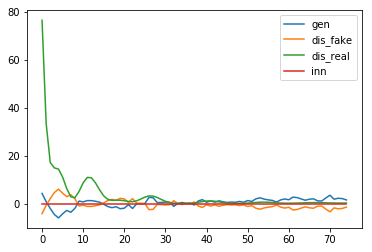

Pick prob : [0.         0.13406849 0.13836491 0.17027714 0.16176058 0.14489815
 0.12538983 0.12524091]
[2 7 1 4 6 5 3 1 6]
Generation 34  fitness : 0.9127971936845023
#################################
[0.1        0.1        0.1        0.1        0.10403592 0.1
 0.51677996 0.51788303]
population fitness : [-15.78929006 -30.75820263 -25.91088407 -20.93100485 -32.51086933
 -27.64234993 -98.85076881 -99.0280634 ]
mean fit : -43.927679134141435
population fitness : [ 0.87533693  0.40967978  0.56047153  0.71538702  0.35515733  0.50660861
 -1.70856294 -1.71407827]
tensor([ 0.5013,  0.0669, -0.4153,  0.2821, -0.0281,  0.1025, -2.0731, -2.0731],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


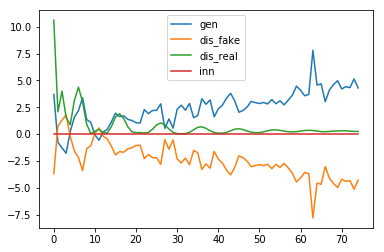

Pick prob : [0.18883438 0.1548761  0.16587266 0.17716995 0.15090002 0.16194468
 0.00040221 0.        ]
[1 5 3 3 4 1 1 1 1]
Generation 35  fitness : 0.875336929019838
#################################
[0.2157368  0.1        0.24335875 0.53885043 0.1        0.5898393
 0.23851465 0.24147978]
population fitness : [-25.26804423 -18.96753404 -26.11141533 -35.13355824 -18.68102871
 -36.69038342 -25.96351225 -26.0540454 ]
mean fit : -26.60869020312845
population fitness : [ 0.219543    1.25130898  0.08143329 -1.39602485  1.29822684 -1.65096917
  0.10565377  0.09082814]
tensor([-0.1173,  1.0657, -0.0807, -1.4665,  0.6956, -2.1547, -0.5383, -0.5383],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


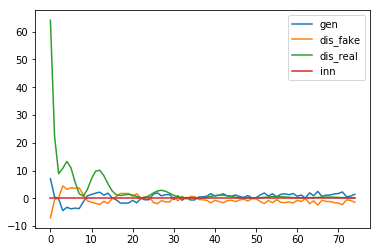

Pick prob : [0.14162228 0.21974049 0.13116557 0.01930263 0.22329278 0.
 0.13299937 0.13187688]
[0 6 6 1 4 4 4 4 3]
Generation 36  fitness : 1.298226837352617
#################################
[0.1        0.36412586 0.57049315 0.1        0.39086133 0.1
 0.30357178 0.36693004]
population fitness : [-22.49637187 -32.97953991 -38.92084531 -22.67065948 -33.74925276
 -23.51638397 -31.23619059 -33.06027195]
mean fit : -29.828689480062096
population fitness : [ 1.27341559 -0.54721335 -1.57904958  1.24314678 -0.68089064  1.09626842
 -0.24444302 -0.56123421]
tensor([ 0.4618, -0.9146, -1.9342,  0.0203, -1.1483,  0.7904, -0.5217, -0.5217],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


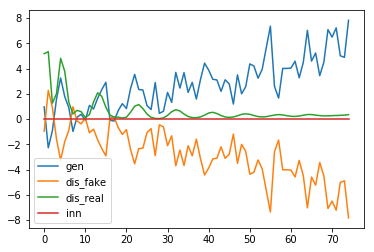

Pick prob : [0.22580554 0.08168175 0.         0.22340942 0.07109965 0.2117823
 0.10564951 0.08057183]
[0 3 5 3 5 1 0 0 6]
Generation 37  fitness : 1.2734155946338708
#################################
[0.1215319  0.1        0.68368208 0.1        0.1        0.11219019
 0.13542505 0.1       ]
population fitness : [ -32.88999398  -25.95885175 -122.60883957  -13.49357254  -27.38531948
  -31.399062    -35.10733292  -29.04425969]
mean fit : -39.7359039911209
population fitness : [ 0.21447164  0.43161348 -2.59627933  0.82213116  0.38692448  0.26118021
  0.14500589  0.33495248]
tensor([-0.2070, -0.1176, -3.3207,  0.2875, -0.3827, -0.3727, -0.3030, -0.3030],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


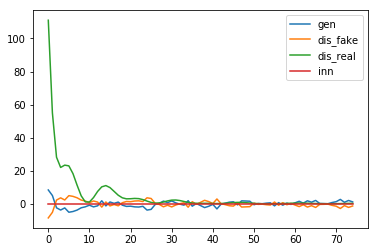

Pick prob : [0.13532591 0.14578039 0.         0.16458218 0.1436288  0.13757474
 0.13198143 0.14112656]
[6 3 5 4 7 6 0 7 6]
Generation 38  fitness : 0.8221311605103402
#################################
[0.1        0.66605065 0.14605192 0.1        0.1        0.1
 0.10969483 0.11105447]
population fitness : [-20.70117313 -99.88187782 -36.37406238 -26.57837245 -29.66936027
 -18.53663707 -31.93374474 -32.0997986 ]
mean fit : -36.9718783077694
population fitness : [ 0.66611851 -2.57551928  0.02447443  0.42550747  0.29896322  0.75473406
  0.2062599   0.1994617 ]
tensor([ 0.2082, -3.6044, -0.3656, -0.0098, -0.3087,  0.3340, -0.1669, -0.1669],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


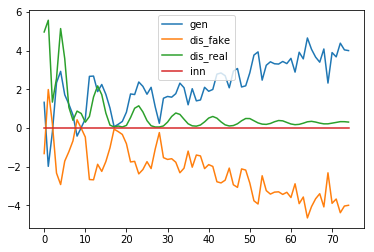

Pick prob : [0.15732933 0.         0.12618784 0.14565154 0.13950985 0.16163019
 0.1350106  0.13468065]
[6 7 2 0 5 4 5 7 4]
Generation 39  fitness : 0.7547340588972943
#################################
[0.53866832 0.18420641 0.1        0.53803966 0.1        0.1106801
 0.1        0.1       ]
population fitness : [-106.17877948  -46.0788907   -31.55017518 -106.07218825  -14.8462423
  -33.61232513  -25.27573769  -29.15892222]
mean fit : -49.096657619867656
population fitness : [-1.68331749  0.08899213  0.51743523 -1.68017418  1.01002418  0.45662367
  0.70246462  0.58795184]
tensor([-2.0119, -0.5966,  0.3444, -2.1885,  0.6801, -0.3009,  0.3455,  0.3455],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


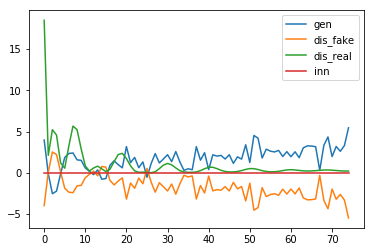

Pick prob : [0.         0.13160839 0.16342377 0.00023342 0.2000025  0.15890802
 0.17716371 0.1686602 ]
[2 7 1 4 2 6 6 7 5]
Generation 40  fitness : 1.010024179609151
#################################
[0.49446401 0.1        0.46202919 0.1        0.44689496 0.15514815
 0.48117615 0.49037559]
population fitness : [-38.16010508 -19.35643225 -36.92666069 -21.55059125 -36.3511304
 -25.25646755 -37.65478917 -38.00462893]
mean fit : -31.65760066552953
population fitness : [-0.85495376  1.61736609 -0.69277964  1.32887656 -0.61710852  0.84162539
 -0.78851447 -0.83451165]
tensor([-1.3104,  1.3959, -0.9681,  0.8151, -1.1307,  0.0664, -1.3224, -1.3224],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


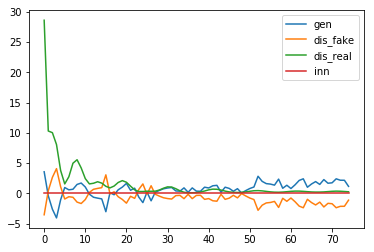

Pick prob : [0.         0.36146982 0.02371095 0.31929071 0.03477458 0.2480513
 0.00971387 0.00298877]
[3 3 1 1 1 3 1 5 3]
Generation 41  fitness : 1.6173660948979645
#################################
[0.18184592 0.1        0.46870841 0.45557495 0.36542701 0.1
 0.43518715 0.58113205]
population fitness : [-16.97317618 -10.88415437 -26.5786262  -26.13885891 -23.12029906
 -12.45501956 -25.45618344 -30.34307714]
mean fit : -21.493674360170782
population fitness : [ 0.67501323  1.58424272 -0.759299   -0.69363174 -0.24289208  1.34967681
 -0.59169276 -1.32141718]
tensor([ 0.1771,  1.0143, -1.1666, -1.2027, -0.5348,  0.8073, -1.2780, -1.2780],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


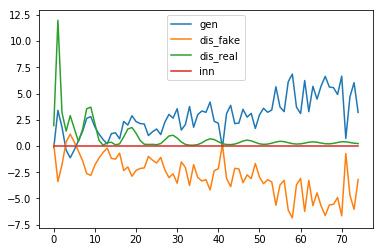

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[0 3 6 1 5 3 1 7 4]
Generation 42  fitness : 1.5842427204016514
#################################
[0.65075807 0.1        0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [-119.7069057   -16.47347584  -18.16759479   -8.90458723  -20.21908642
  -25.04290637  -17.95729603  -15.95809971]
mean fit : -30.303744013082774
population fitness : [-2.62538865  0.40613585  0.35638682  0.62840175  0.29614328  0.15448831
  0.3625624   0.42127024]
tensor([-3.1597, -0.2625, -0.1981, -0.0283, -0.0901, -0.4250, -0.1940, -0.1940],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


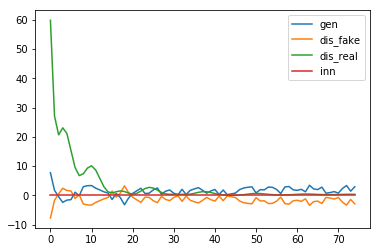

Pick prob : [0.         0.14433694 0.14196829 0.15491946 0.13909997 0.1323555
 0.14226232 0.14505752]
[4 4 6 7 6 4 1 6 1]
Generation 43  fitness : 0.6284017515858958
#################################
[0.65492416 0.1        0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [-102.9929264   -28.80727291  -26.71882818  -24.53997693  -27.63264643
  -21.78577277  -19.24159008  -15.86493077]
mean fit : -33.44799305710278
population fitness : [-2.61377857  0.17441695  0.25290911  0.33479911  0.21856414  0.43831319
  0.53393382  0.66084227]
tensor([-3.0696, -0.5464, -0.0579,  0.1000, -0.0223, -0.3738, -0.1372, -0.1372],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


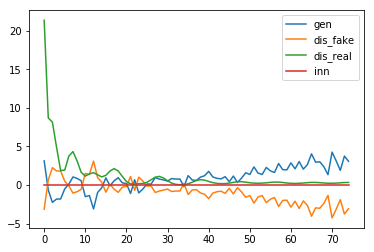

Pick prob : [0.         0.13334123 0.13709499 0.14101126 0.1354525  0.14596166
 0.15053458 0.15660378]
[5 4 6 6 3 6 1 5 5]
Generation 44  fitness : 0.6608422678619265
#################################
[0.50234348 0.48356353 0.15863784 0.44255411 0.1        0.31766865
 0.64133434 0.53829685]
population fitness : [-24.72520859 -24.2500759  -16.02945746 -23.2125378  -12.0159208
 -20.05293612 -28.24167656 -25.63482861]
mean fit : -21.77033022890939
population fitness : [-0.58396799 -0.49006826  1.13455971 -0.28502123  1.92774869  0.33940591
 -1.27892206 -0.76373478]
tensor([-0.9350, -1.0844,  0.5734, -0.7722,  1.5802, -0.4262, -1.4160, -1.4160],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


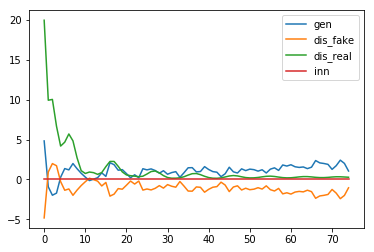

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[5 3 0 0 1 0 0 2 2]
Generation 45  fitness : 1.9277486898415477
#################################
[0.65031637 0.1        0.1        0.20635134 0.1        0.1
 0.1        0.1       ]
population fitness : [-118.88791578  -24.58540533  -13.93877773  -47.24010089  -22.62244575
  -23.73314753  -22.01174583  -21.81916785]
mean fit : -36.854838336820805
population fitness : [-2.54158609  0.38013715  0.70999581 -0.32176092  0.44095446  0.40654219
  0.45987544  0.46584198]
tensor([-3.2527, -0.4097,  0.2284, -0.8747,  0.0035, -0.0169, -0.0458, -0.0458],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


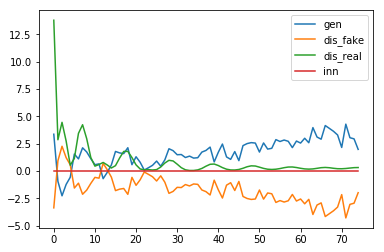

Pick prob : [0.         0.14369586 0.15991893 0.10917519 0.14668697 0.14499451
 0.14761754 0.14791099]
[6 7 1 4 1 7 5 2 5]
Generation 46  fitness : 0.709995806069665
#################################
[0.1878341  0.1        0.21136211 0.1        0.1        0.4188348
 0.51222305 0.50754441]
population fitness : [-21.29614323 -17.46682718 -21.80838905 -17.20666794 -18.71253394
 -26.32543077 -28.35865561 -28.25679337]
mean fit : -22.428930136813
population fitness : [ 0.26015063  1.13957373  0.14251061  1.1993207   0.85349044 -0.8948524
 -1.36179346 -1.33840025]
tensor([-0.4894,  0.5756, -0.5332,  0.7718,  0.2509, -1.3101, -1.6992, -1.6992],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


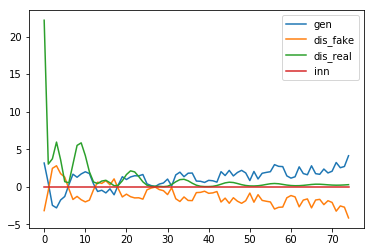

Pick prob : [0.14887941 0.22960229 0.13808115 0.23508651 0.2033425  0.04286086
 0.         0.00214728]
[2 3 2 2 3 2 1 1 1]
Generation 47  fitness : 1.1993207012348945
#################################
[0.24529468 0.1        0.70015464 0.1        0.3419788  0.20854143
 0.28322884 0.2922522 ]
population fitness : [-19.45025569 -15.7139267  -26.37868351 -16.34973025 -20.92294854
 -18.89043012 -20.02806891 -20.16551276]
mean fit : -19.737444559470063
population fitness : [ 0.09427145  1.32074358 -2.18002604  1.11203729 -0.38914871  0.27803751
 -0.09539916 -0.14051592]
tensor([-0.3713,  0.9970, -2.9253,  0.5305, -0.5234, -0.1399, -0.6731, -0.6731],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


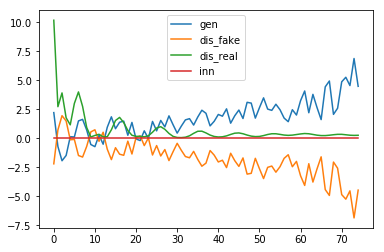

Pick prob : [0.13040541 0.20072981 0.         0.18876284 0.10268669 0.14094233
 0.11952993 0.11694299]
[0 0 0 1 6 3 1 3 5]
Generation 48  fitness : 1.320743576169534
#################################
[0.1        0.12458328 0.5181821  0.38352157 0.17449618 0.64472687
 0.41727544 0.33361006]
population fitness : [-12.96266751 -16.91377319 -29.39659264 -25.12589126 -18.49673955
 -33.40990621 -26.1963807  -23.54296869]
mean fit : -23.255614967900044
population fitness : [ 1.62274693  0.99983064 -0.96816317 -0.29486064  0.75026619 -1.60088692
 -0.46362994 -0.04530309]
tensor([ 1.1953,  0.3584, -1.5521, -0.8056,  0.0586, -2.2328, -0.7625, -0.7625],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


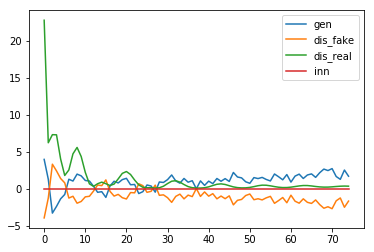

Pick prob : [0.25170687 0.20306849 0.04940416 0.10197677 0.18358207 0.
 0.08879898 0.12146266]
[3 6 0 4 0 4 1 2 4]
Generation 49  fitness : 1.6227469323790944
#################################
[0.34182813 0.42090708 0.19081446 0.68976672 0.49890384 0.53195438
 0.31857042 0.1       ]
population fitness : [-23.19368481 -24.41366919 -20.86393321 -28.5614802  -25.61695804
 -26.12684273 -22.83487826 -17.92015805]
mean fit : -23.691450560768097
population fitness : [ 0.16132484 -0.23406954  0.91639244 -1.57836639 -0.62405293 -0.78930549
  0.27761329  1.8704638 ]
tensor([-0.5353, -0.8683,  0.3148, -1.7354, -1.0934, -0.8696,  0.5269,  0.5269],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


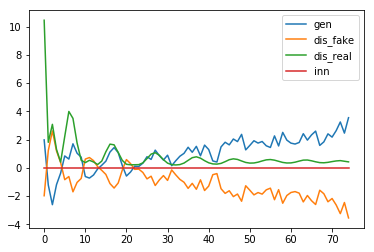

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[5 3 2 7 5 1 0 0 6]
Generation 50  fitness : 1.870463795268661
#################################
[0.12217407 0.1        0.1        0.1        0.1        0.1
 0.53487893 0.50273593]
population fitness : [ -35.63607241  -21.73290898  -23.41208923  -13.91824175  -28.29368222
  -28.26749624 -108.99905568 -103.28527161]
mean fit : -45.443102265626194
population fitness : [ 0.27584817  0.66691074  0.61967943  0.88671854  0.48237196  0.48310851
 -1.78767618 -1.62696117]
tensor([-0.2416,  0.2467,  0.1937,  0.6832, -0.0657,  0.0978, -2.1570, -2.1570],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


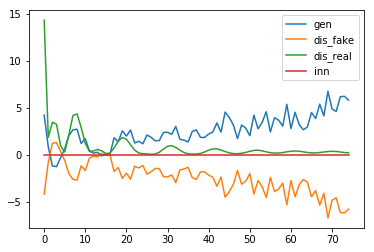

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[5 5 4 1 6 4 1 5 5]
Generation 51  fitness : 0.8867185407873944
#################################
[0.1        0.1        0.1        0.56846195 0.1        0.1
 0.36962947 0.3390778 ]
population fitness : [-18.37299194 -19.91463646 -18.97776816 -34.62863428 -20.75488298
 -18.16607902 -28.87048161 -27.98571074]
mean fit : -23.458898147347938
population fitness : [ 0.87809685  0.61192734  0.77368044 -1.92848821  0.46685627  0.91382099
 -0.934326   -0.78156768]
tensor([ 0.6401,  0.3771,  0.4712, -2.4515,  0.0631,  0.4760, -1.5024, -1.5024],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


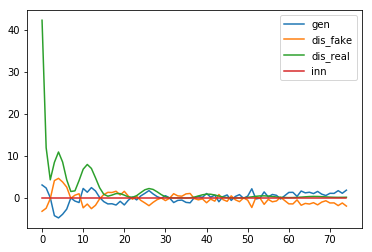

Pick prob : [0.18191614 0.16466367 0.17514812 0.         0.15526051 0.18423169
 0.06443922 0.07434065]
[2 2 7 4 6 2 1 2 0]
Generation 52  fitness : 0.9138209867103644
#################################
[0.1        0.1        0.1        0.14720784 0.1        0.10732992
 0.1        0.6570549 ]
population fitness : [ -27.90092877  -25.70012345  -18.18740215  -41.43858546  -29.02683899
  -35.13994697  -22.90143352 -121.96790428]
mean fit : -40.282895448416824
population fitness : [ 0.39196341  0.46163209  0.69945472 -0.03658451  0.35632161  0.16280513
  0.55022739 -2.58581983]
tensor([-0.0795,  0.0059,  0.3315, -0.7055, -0.3013, -0.7470, -1.3466, -1.3466],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


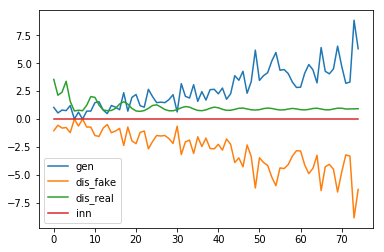

Pick prob : [0.14394773 0.14731556 0.15881204 0.12323148 0.14222479 0.13287009
 0.1515983  0.        ]
[6 6 3 2 1 2 1 4 4]
Generation 53  fitness : 0.6994547168732097
#################################
[0.1        0.1        0.66332028 0.1        0.1578027  0.1
 0.1352702  0.13004707]
population fitness : [ -21.08625495  -15.5535848  -105.10086965  -18.2178307   -36.85672263
  -26.66590885  -33.81486803  -33.10975194]
mean fit : -36.30072394406409
population fitness : [ 0.56350486  0.76842075 -2.5481807   0.66974392 -0.02059276  0.35684881
  0.09206972  0.11818541]
tensor([-0.0140,  0.1035, -3.1210,  0.2281, -0.6187, -0.0836, -0.3381, -0.3381],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


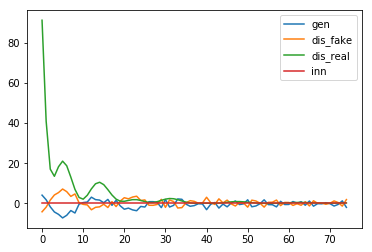

Pick prob : [0.15264251 0.16269458 0.         0.15785402 0.12398983 0.14250508
 0.12951644 0.13079754]
[3 3 7 7 5 6 1 7 7]
Generation 54  fitness : 0.7684207494774679
#################################
[0.41743218 0.49335641 0.54171642 0.1965933  0.47463675 0.24914239
 0.1        0.1       ]
population fitness : [-38.60232064 -42.79634883 -45.46773885 -26.40325707 -41.76228098
 -29.30605039 -15.54351093 -16.82483673]
mean fit : -32.0882930544171
population fitness : [-0.58961515 -0.96923629 -1.21103632  0.51457924 -0.87563797  0.25183382
  1.49754574  1.38156694]
tensor([-1.0044, -1.2228, -2.2811, -0.1357, -1.1502, -0.4697,  1.1104,  1.1104],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


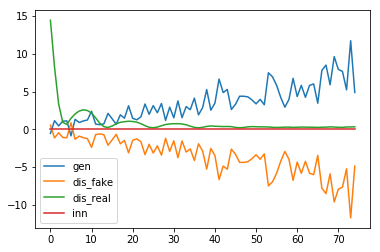

Pick prob : [0.06414147 0.02495797 0.         0.17811352 0.03461894 0.15099363
 0.27957275 0.26760172]
[6 4 3 4 7 5 5 6 0]
Generation 55  fitness : 1.4975457400294931
#################################
[0.1        0.13064295 0.6591726  0.12415601 0.1        0.1
 0.1        0.1       ]
population fitness : [ -20.94806716  -42.8156664  -131.28331803  -41.72985397  -26.61869923
  -31.50379389  -30.44007771  -30.98117671]
mean fit : -44.54008163768778
population fitness : [ 0.70472536  0.05151061 -2.59113772  0.0839453   0.53533592  0.38941154
  0.42118618  0.40502282]
tensor([ 0.3012, -0.3282, -3.0311, -0.3285,  0.2315, -0.0238,  0.1033,  0.1033],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


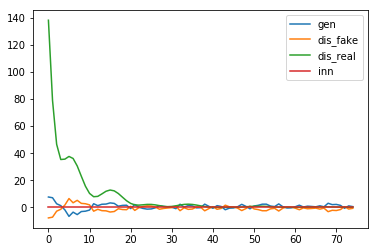

Pick prob : [0.15899691 0.12748494 0.         0.12904964 0.15082533 0.14378574
 0.14531859 0.14453885]
[6 0 5 3 6 4 6 0 1]
Generation 56  fitness : 0.7047253603399828
#################################
[0.1        0.1        0.13814247 0.15304941 0.55704804 0.54337669
 0.12135265 0.10517457]
population fitness : [ -24.19959259   -8.19513469  -36.10118616  -39.11252556 -120.7239695
 -117.96223111  -32.7094869   -29.44136747]
mean fit : -51.05568674844573
population fitness : [ 0.66472451  1.0608564   0.37014404  0.29560933 -1.72438385 -1.65602711
  0.45409316  0.53498352]
tensor([-0.1958,  0.4544, -0.0911, -0.2850, -2.1588, -1.8710,  0.1115,  0.1115],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


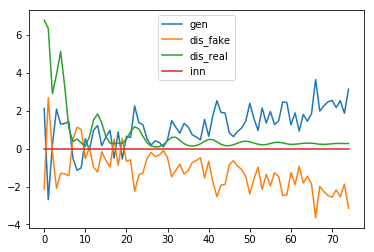

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[5 1 5 0 2 7 5 5 1]
Generation 57  fitness : 1.0608564032278476
#################################
[0.4843959  0.44134676 0.1        0.1        0.41041043 0.43237484
 0.10039025 0.1       ]
population fitness : [-126.12880958 -116.41991006  -16.88271416  -20.19958662 -109.44282282
 -114.39646815  -39.52378605  -34.60441501]
mean fit : -72.19981405668233
population fitness : [-1.19560268 -0.98035695  1.22637687  1.15284201 -0.82567533 -0.93549736
  0.72442563  0.8334878 ]
tensor([-1.9459, -1.6966,  0.3089,  0.8866, -1.0812, -1.3137,  0.2947,  0.2947],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


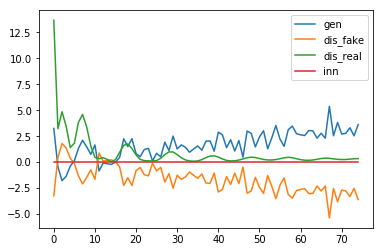

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[3 0 3 1 0 1 0 3 5]
Generation 58  fitness : 1.2263768737511431
#################################
[0.44051481 0.44656697 0.44289743 0.44839012 0.1        0.1
 0.1        0.1       ]
population fitness : [-118.92785754 -120.31945371 -119.47570269 -120.73865735  -17.63869105
  -33.83375406  -32.61477956  -29.28857907]
mean fit : -74.10468438052271
population fitness : [-0.97469811 -1.00495893 -0.98661123 -1.01407469  1.22787596  0.87570774
  0.90221484  0.97454442]
tensor([-1.3778, -1.5578, -1.4220, -1.5821,  0.9219,  0.4062,  0.4931,  0.4931],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


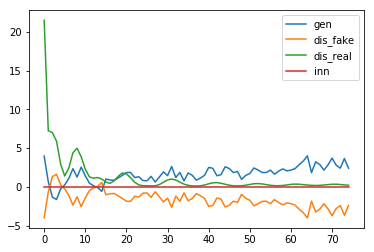

Pick prob : [0.00485376 0.00112365 0.00338529 0.         0.27635423 0.23294419
 0.23621159 0.2451273 ]
[4 6 7 5 5 4 6 7 5]
Generation 59  fitness : 1.227875964384608
#################################
[0.1        0.4114005  0.48647718 0.1        0.1        0.1
 0.41448207 0.40603282]
population fitness : [ -30.13581792 -105.56823589 -120.81271881  -22.0324769   -32.60295402
  -30.4169583  -106.19395622 -104.47831744]
mean fit : -69.03017943539344
population fitness : [ 0.95774313 -0.89972097 -1.2751044   1.15728155  0.89699184  0.95082027
 -0.91512884 -0.87288258]
tensor([ 0.5975, -1.4083, -1.8129,  0.3390,  0.0394,  0.5194, -1.3155, -1.3155],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


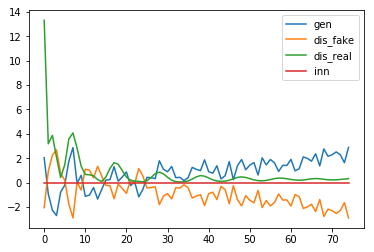

Pick prob : [0.2188887  0.03679928 0.         0.23844969 0.21293318 0.21821004
 0.03528883 0.03943028]
[0 3 6 5 4 4 3 4 5]
Generation 60  fitness : 1.157281545879063
#################################
[0.1        0.1        0.1        0.1        0.1        0.64787453
 0.1        0.1       ]
population fitness : [ -32.78637244  -38.73850233  -27.52470024  -26.93028777  -36.10292024
 -115.83806911  -37.268537    -37.54242603]
mean fit : -44.091476893207236
population fitness : [ 0.41190373  0.1950367   0.60361381  0.62527135  0.29106465 -2.61410139
  0.24859518  0.23861597]
tensor([ 0.3608, -0.6426,  0.1896,  0.4548, -0.2730, -3.3029, -0.2415, -0.2415],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


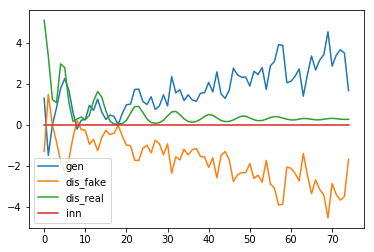

Pick prob : [0.14469624 0.13432618 0.15386335 0.15489896 0.13891801 0.
 0.13688722 0.13641004]
[0 3 4 4 2 6 4 1 4]
Generation 61  fitness : 0.6252713466223543
#################################
[0.1        0.1        0.46337207 0.41193181 0.48455165 0.1
 0.1        0.1       ]
population fitness : [ -30.08142795  -24.54309553 -119.24510161 -108.73196089 -123.57369408
  -36.20175888  -38.53559432  -38.64511173]
mean fit : -64.94471812381039
population fitness : [ 0.85292149  0.98841538 -1.32844502 -1.07124371 -1.43434293  0.70318916
  0.64609247  0.64341315]
tensor([ 0.1143,  0.2743, -1.8732, -1.4390, -1.9428,  0.3805,  0.1729,  0.1729],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


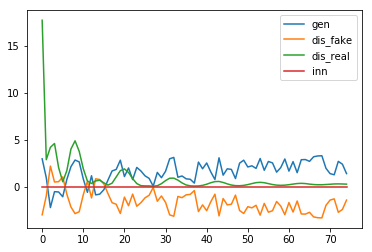

Pick prob : [0.19933033 0.21113834 0.00922878 0.03164334 0.         0.18628147
 0.18130561 0.18107212]
[1 1 1 0 6 6 6 6 7]
Generation 62  fitness : 0.9884153802668282
#################################
[0.66314746 0.10496022 0.1        0.13399724 0.10055186 0.1
 0.1        0.1       ]
population fitness : [-141.6495807   -38.67464967  -34.74298219  -44.03142693  -37.86139072
  -37.21365     -19.31148412  -19.45066709]
mean fit : -46.616978927567274
population fitness : [-2.57567475  0.21526146  0.3218217   0.07007638  0.23730327  0.25485903
  0.74006259  0.73629031]
tensor([-3.1676, -0.3580, -0.2666, -0.5070, -0.2372, -0.2490,  0.5486,  0.5486],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


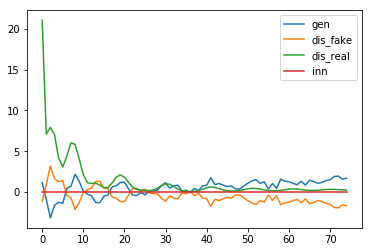

Pick prob : [0.         0.13544685 0.14061832 0.12840088 0.13651656 0.13736856
 0.16091596 0.16073288]
[4 5 2 5 6 3 7 6 7]
Generation 63  fitness : 0.7400625915064453
#################################
[0.63406315 0.1        0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [-121.91457038  -37.25877676  -30.33740543  -32.22765197  -35.47322384
  -31.55323599  -26.27935473  -26.25439554]
mean fit : -42.66232682987179
population fitness : [-2.62653337  0.17908142  0.40846563  0.34582014  0.23825722  0.36817125
  0.54295527  0.54378245]
tensor([-3.1852, -0.3538, -0.1035, -0.1476, -0.2578, -0.2154, -0.0037, -0.0037],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


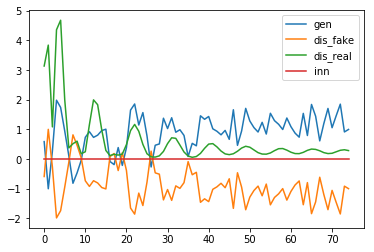

Pick prob : [0.         0.13352271 0.14443939 0.14145801 0.13633896 0.14252173
 0.15083992 0.15087929]
[6 6 2 5 3 4 2 4 2]
Generation 64  fitness : 0.5437824487605487
#################################
[0.16715748 0.46367499 0.1        0.12346234 0.48006152 0.28226006
 0.52940238 0.57402119]
population fitness : [-31.03256477 -41.73493175 -24.99925952 -29.45545259 -42.32637966
 -35.18702446 -44.10726598 -45.71771685]
mean fit : -36.82007444946561
population fitness : [ 0.80173751 -0.68084991  1.63752482  1.02021317 -0.76278256  0.22622466
 -1.00948683 -1.23258086]
tensor([ 0.2962, -1.3200,  1.2096,  0.4338, -1.1182, -0.3088, -1.7145, -1.7145],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


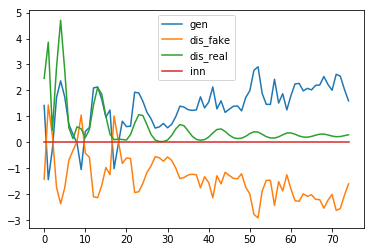

Pick prob : [0.20630679 0.05595281 0.29106667 0.22846311 0.04764376 0.14794217
 0.02262469 0.        ]
[2 5 0 3 2 3 3 0 4]
Generation 65  fitness : 1.6375248190327838
#################################
[0.1        0.1        0.1        0.1        0.63695857 0.1
 0.1        0.1       ]
population fitness : [ -38.58651983  -36.38967813  -32.82028399  -28.3611256  -148.74390692
  -28.63630419  -23.86370259  -28.08102593]
mean fit : -45.68531839930217
population fitness : [ 0.18103913  0.23706471  0.32809419  0.44181515 -2.62828093  0.43479733
  0.55651196  0.44895847]
tensor([-0.3275, -0.3536, -0.3675,  0.0249, -3.4158,  0.0560,  0.2420,  0.2420],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


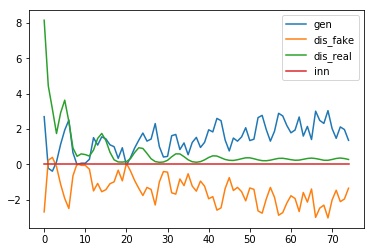

Pick prob : [0.13361015 0.1362747  0.14060403 0.14601255 0.         0.14567879
 0.15146749 0.14635229]
[6 6 7 0 3 0 6 5 2]
Generation 66  fitness : 0.5565119552298002
#################################
[0.1        0.1        0.1        0.5263834  0.1        0.52515779
 0.11186876 0.11154629]
population fitness : [ -25.66453656  -16.14487823  -31.9259086  -124.30804987  -31.79247388
 -124.05620591  -39.13207768  -39.0658155 ]
mean fit : -54.011243279717206
population fitness : [ 0.68975585  0.92139617  0.5373989  -1.71052089  0.54064574 -1.70439281
  0.36205234  0.36366469]
tensor([ 0.2636,  0.5346, -0.2891, -2.2673, -0.0007, -2.1443, -0.1593, -0.1593],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


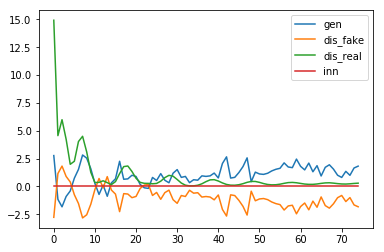

Pick prob : [0.1754054  0.19233301 0.16427158 0.         0.16450885 0.00044782
 0.15145776 0.15157558]
[2 1 6 2 1 6 4 2 1]
Generation 67  fitness : 0.9213961692080641
#################################
[0.1        0.48521252 0.1        0.1        0.48155321 0.1
 0.1        0.1       ]
population fitness : [ -33.10569187 -146.39149809  -30.9675081   -39.05607417 -145.521007
  -35.05896074  -43.58108181  -36.57105312]
mean fit : -63.78160936099536
population fitness : [ 0.64476803 -1.73635279  0.68970988  0.5196987  -1.71805619  0.60371285
  0.42458891  0.57193062]
tensor([ 0.1871, -2.4202, -0.0023, -0.1119, -2.3865, -0.0822,  0.3892,  0.3892],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


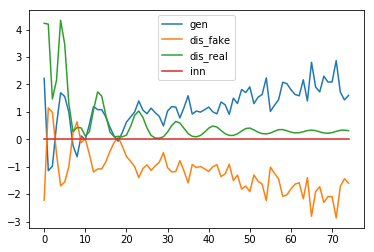

Pick prob : [0.17141684 0.         0.1746522  0.1624131  0.00131717 0.16846127
 0.15556615 0.16617327]
[7 7 5 2 2 2 5 6 6]
Generation 68  fitness : 0.6897098764695309
#################################
[0.51712773 0.1        0.45922993 0.32388723 0.18379951 0.71085392
 0.38564822 0.38656474]
population fitness : [-42.0294531  -26.94790481 -40.34091756 -36.3937739  -32.30824609
 -47.67929666 -38.19497566 -38.22170519]
mean fit : -37.764534121977164
population fitness : [-0.73119398  1.85444418 -0.441705    0.23500836  0.93544683 -1.6998247
 -0.07379654 -0.07837915]
tensor([-1.2399,  1.3225, -1.1017, -0.4961,  0.5577, -2.1743, -0.4632, -0.4632],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


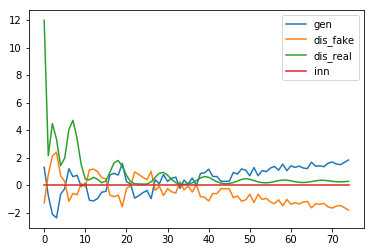

Pick prob : [0.07123019 0.26137025 0.09251834 0.14228181 0.19378995 0.
 0.11957322 0.11923623]
[1 4 6 4 0 1 7 3 3]
Generation 69  fitness : 1.854444184085164
#################################
[0.1        0.62917947 0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -36.13676354 -137.36131467  -38.75058923  -44.2141102   -34.64117728
  -34.42021733  -30.82290312  -30.89789342]
mean fit : -48.405621099117404
population fitness : [ 0.36227842 -2.62670978  0.28509661  0.12376816  0.40644053  0.4129651
  0.51918765  0.51697331]
tensor([-0.1239, -2.8708, -0.2218, -0.1344, -0.4461, -0.0238,  0.0519,  0.0519],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


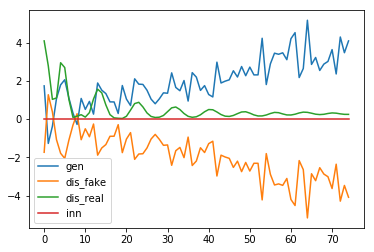

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 0 0 3 4 2 3 7 3]
Generation 70  fitness : 0.5191876465246881
#################################
[0.616146   0.50135441 0.36667234 0.37171021 0.63057543 0.1
 0.59917297 0.59167688]
population fitness : [-42.86928533 -39.64220751 -35.85595873 -35.99758582 -43.27493283
 -25.5478847  -42.39213112 -42.18139745]
mean fit : -38.47017293821685
population fitness : [-0.78241216 -0.20845435  0.46495584  0.43976649 -0.85455934  2.29831715
 -0.69754703 -0.66006661]
tensor([-1.3452, -0.7779, -0.0640, -0.1451, -1.3719,  1.5891, -1.1124, -1.1124],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


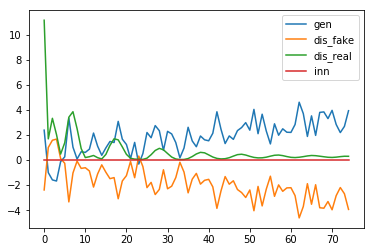

Pick prob : [0.01055327 0.0945085  0.19301105 0.1893265  0.         0.46118455
 0.02296685 0.02844927]
[5 1 2 6 5 7 1 3 3]
Generation 71  fitness : 2.2983171510461133
#################################
[0.1553739  0.12569681 0.1        0.68743346 0.11706476 0.1
 0.1        0.11937783]
population fitness : [ -43.496361    -39.94569652  -24.9069137  -107.15372862  -38.91292944
  -33.29491128  -36.0937867   -39.18967215]
mean fit : -45.37424992555519
population fitness : [ 0.07847864  0.22686406  0.85534814 -2.58181923  0.27002432  0.50480628
  0.38783879  0.25845899]
tensor([-0.1723, -0.4320,  0.0399, -3.1201,  0.0130, -0.1464, -0.1302, -0.1302],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


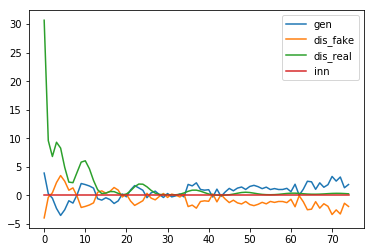

Pick prob : [0.12879958 0.13598373 0.16641209 0.         0.13807336 0.14944043
 0.1437774  0.13751341]
[4 1 6 7 5 1 1 6 7]
Generation 72  fitness : 0.8553481399270119
#################################
[0.1        0.10254756 0.1        0.5144662  0.53196349 0.1
 0.1        0.1       ]
population fitness : [ -47.21062715  -47.69641323  -32.51990985 -108.65822117 -111.24772829
  -42.06126502  -42.28457902  -42.29001018]
mean fit : -59.2460942373162
population fitness : [ 0.40661797  0.3902057   0.90294351 -1.66938755 -1.75687399  0.58058905
  0.57304439  0.5728609 ]
tensor([-0.1564,  0.0280,  0.3800, -2.2890, -2.3953,  0.3237,  0.2061,  0.2061],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


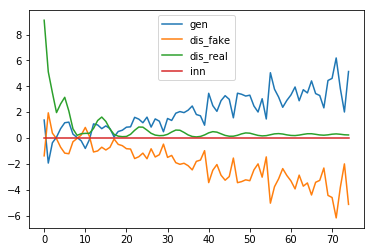

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 4 2 1 1 7 2 6 5]
Generation 73  fitness : 0.9029435119175495
#################################
[0.55524167 0.48713008 0.10221272 0.11637245 0.1        0.1
 0.1        0.1       ]
population fitness : [-119.02929707 -108.11647454  -46.44511325  -48.71378145  -30.06861677
  -40.99167428  -40.52867578  -38.20030035]
mean fit : -59.01174168472053
population fitness : [-1.87297626 -1.53241828  0.39216854  0.32136989  0.90323216  0.56235477
  0.57680363  0.64946557]
tensor([-2.3819, -2.1425, -0.2330, -0.2323,  0.2589,  0.1660,  0.0968,  0.0968],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


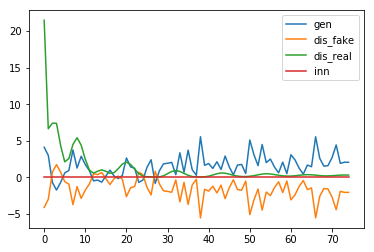

Pick prob : [0.         0.0227284  0.15117282 0.14644781 0.18528054 0.16253083
 0.16349512 0.16834449]
[7 7 4 6 5 5 7 7 5]
Generation 74  fitness : 0.9032321564781806
#################################
[0.1        0.45963958 0.1        0.1        0.42285301 0.47050292
 0.40020709 0.39640824]
population fitness : [ -39.27686916 -120.10797369  -38.17373778  -32.98688496 -113.13536702
 -122.1670353  -108.84300957 -108.12296834]
mean fit : -85.35173072741227
population fitness : [ 1.21542502 -0.91684719  1.24452491  1.38135073 -0.73291434 -0.9711639
 -0.61968473 -0.60069051]
tensor([ 0.6868, -1.3407,  0.7983,  0.9625, -1.5819, -1.8717, -0.9271, -0.9271],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


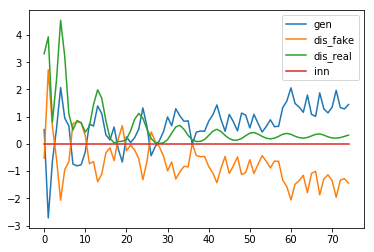

Pick prob : [0.28143922 0.00699119 0.28518472 0.30279578 0.03066547 0.
 0.04523943 0.0476842 ]
[6 2 0 0 2 0 7 3 2]
Generation 75  fitness : 1.3813507327250012
#################################
[0.39400835 0.43851478 0.1        0.1        0.1        0.1
 0.39197587 0.3921488 ]
population fitness : [-109.63952467 -117.64656713  -39.45115012  -38.75445214  -40.66641227
  -39.87734991 -109.27386658 -109.30497756]
mean fit : -75.57678754678554
population fitness : [-0.94667344 -1.1692056   1.00400568  1.02336835  0.97023105  0.99216071
 -0.93651105 -0.93737569]
tensor([-1.5807, -1.2687,  0.3989,  0.5100,  0.9290,  0.3387, -1.6806, -1.6806],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


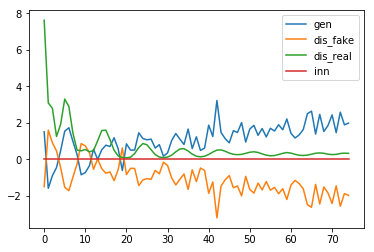

Pick prob : [0.02379096 0.         0.23233844 0.23440851 0.22872759 0.2310721
 0.02487742 0.02478498]
[4 5 5 4 2 5 4 2 2]
Generation 76  fitness : 1.0233683488436152
#################################
[0.54759683 0.12651223 0.42530137 0.45196013 0.1        0.41801392
 0.57549998 0.57264122]
population fitness : [-45.82022894 -34.04355792 -42.39993441 -43.14551237 -30.505331
 -42.19612285 -46.60060941 -46.52065718]
mean fit : -41.40399426095328
population fitness : [-0.78953043  1.31589213 -0.17805328 -0.31134703  1.94845313 -0.14161603
 -0.92904614 -0.91475235]
tensor([-1.3466,  0.8581, -0.7224, -0.8285,  1.6286, -0.4900, -1.5879, -1.5879],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


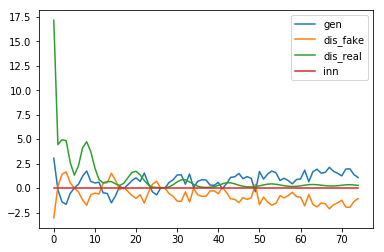

Pick prob : [0.01877136 0.30204881 0.10104354 0.08310932 0.38715774 0.10594604
 0.         0.00192318]
[4 1 5 5 3 4 3 4 3]
Generation 77  fitness : 1.9484531251589798
#################################
[0.1        0.1        0.51831242 0.54922485 0.12125449 0.1
 0.13686792 0.16341086]
population fitness : [ -34.80705874  -23.60191683 -107.04114021 -112.01750064  -43.12176602
  -28.76404479  -45.63525577  -49.90820344]
mean fit : -55.61211080504193
population fitness : [ 0.64618992  0.99421355 -1.59734858 -1.75191075  0.38794111  0.83388158
  0.30987393  0.17715925]
tensor([ 0.1449,  0.6584, -2.5525, -2.4017, -0.3917,  0.3310,  0.0278,  0.0278],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


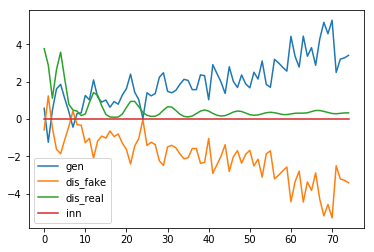

Pick prob : [0.17110608 0.1959378  0.01102811 0.         0.15267986 0.18449801
 0.14710971 0.13764043]
[6 6 6 4 7 5 0 6 1]
Generation 78  fitness : 0.994213551324389
#################################
[0.56304801 0.16221244 0.51730515 0.1344146  0.14666203 0.1
 0.1        0.1       ]
population fitness : [-114.91837737  -51.75836238 -107.71063497  -47.37823197  -49.3080699
  -36.00860073  -35.31423742  -26.19840384]
mean fit : -58.574364822654445
population fitness : [-1.78789417  0.21628369 -1.55917989  0.3552729   0.29403576  0.71605121
  0.73808457  1.02734593]
tensor([-1.9231, -0.0928, -2.0240, -0.0725, -0.0964,  0.1045,  0.2308,  0.2308],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


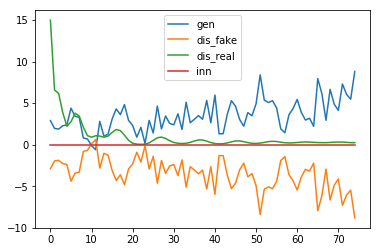

Pick prob : [0.         0.1401214  0.01599048 0.14983878 0.14555741 0.17506247
 0.17660293 0.19682653]
[3 1 5 5 6 7 3 5 6]
Generation 79  fitness : 1.0273459294398688
#################################
[0.51323729 0.57278324 0.41821848 0.57177948 0.1        0.34786128
 0.64257604 0.6410829 ]
population fitness : [-45.66808941 -48.86397448 -40.5683436  -48.81010195 -18.1221784
 -36.79220866 -52.60981767 -52.52967928]
mean fit : -42.99554918086678
population fitness : [-0.24897475 -0.54670449  0.2261193  -0.54168571  2.31721166  0.57790531
 -0.89566851 -0.88820279]
tensor([-0.5317, -1.0250,  0.0536, -1.0128,  1.7229,  0.1448, -1.3371, -1.3371],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


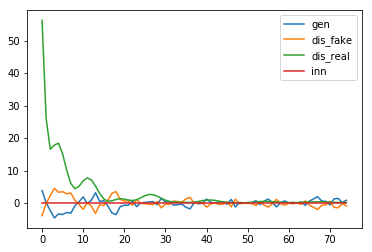

Pick prob : [0.09025294 0.04870161 0.15655734 0.04940204 0.44839136 0.20565279
 0.         0.00104192]
[0 4 4 4 5 2 4 3 5]
Generation 80  fitness : 2.31721165706226
#################################
[0.14337237 0.1        0.62997842 0.1        0.1        0.12988574
 0.1        0.1       ]
population fitness : [ -50.7434327   -33.16560847 -110.40259658  -34.00386523  -36.66566832
  -49.08993646  -34.71318652  -34.34772566]
mean fit : -47.891502491360264
population fitness : [-0.11630791  0.60055395 -2.54933821  0.56636802  0.4578139  -0.04887474
  0.53744035  0.55234464]
tensor([-0.4946,  0.1010, -3.2647,  0.0922,  0.1229, -0.8131,  0.2346,  0.2346],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


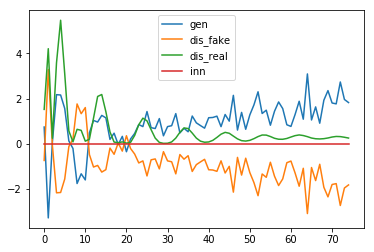

Pick prob : [0.11929715 0.15444656 0.         0.15277035 0.14744768 0.12260356
 0.15135195 0.15208275]
[6 3 4 7 7 7 1 5 7]
Generation 81  fitness : 0.6005539478802832
#################################
[0.46068903 0.1        0.35476287 0.34326642 0.1        0.1
 0.46659689 0.46630524]
population fitness : [-125.54555165  -39.76371158 -104.47376509 -102.18678774  -37.60356888
  -33.90113992 -126.72079583 -126.66277749]
mean fit : -87.10726227239569
population fitness : [-0.96613085  1.18996099 -0.43650002 -0.37901777  1.2442553   1.33731435
 -0.99567013 -0.99421187]
tensor([-1.3975,  0.8141, -0.8666, -0.6473,  0.8121,  0.9508, -1.6496, -1.6496],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


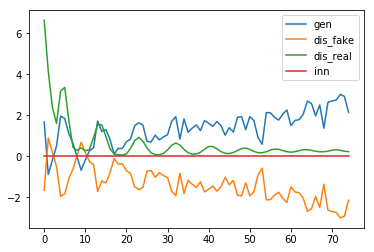

Pick prob : [3.70846803e-03 2.74391970e-01 7.02002218e-02 7.74167497e-02
 2.81208273e-01 2.92891241e-01 0.00000000e+00 1.83076139e-04]
[3 4 5 5 2 4 3 5 4]
Generation 82  fitness : 1.33731435211512
#################################
[0.1        0.42181532 0.1        0.1        0.1        0.539082
 0.1        0.1       ]
population fitness : [ -41.3467652  -102.57581748  -37.71580906  -32.44415442  -38.30670564
 -122.072756    -33.87650206  -35.8450228 ]
mean fit : -55.522941582350235
population fitness : [ 0.4263216  -1.41502593  0.53551571  0.69405072  0.51774562 -2.00135935
  0.65097558  0.59177606]
tensor([-0.1350, -2.0505,  0.1873,  0.3436,  0.2189, -2.8254,  0.1987,  0.1987],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


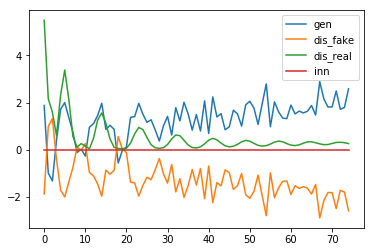

Pick prob : [0.151627   0.03662095 0.158447   0.16834871 0.15733712 0.
 0.16565834 0.16196088]
[4 4 3 7 4 4 2 6 4]
Generation 83  fitness : 0.6940507166138478
#################################
[0.1        0.48842263 0.1        0.1        0.52336212 0.1
 0.1        0.1       ]
population fitness : [ -43.39273442 -103.02603993  -42.66157387  -33.35697495 -108.00984209
  -44.04861916  -38.44507166  -38.80784387]
mean fit : -56.46858749393709
population fitness : [ 0.45834852 -1.63198068  0.48397793  0.8101325  -1.80667814  0.43535776
  0.63177919  0.61906292]
tensor([ 0.1263, -1.9114,  0.0084,  0.2445, -2.1445, -0.2039,  0.0492,  0.0492],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


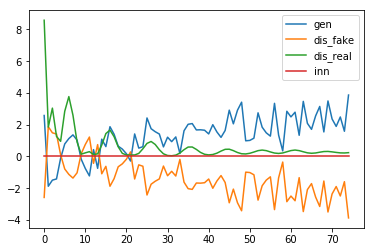

Pick prob : [0.1567121  0.01208692 0.15848535 0.18105125 0.         0.15512143
 0.16871138 0.16783157]
[5 7 7 5 5 3 5 3 0]
Generation 84  fitness : 0.8101324965914191
#################################
[0.1        0.1        0.63963576 0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -41.00969336  -34.79626249 -109.10404725  -37.8676402   -44.21515344
  -36.25973281  -41.11043383  -40.28279369]
mean fit : -48.080719633801266
population fitness : [ 0.30433429  0.571758   -2.62642088  0.43956707  0.1663725   0.50877079
  0.29999846  0.33561978]
tensor([-0.0297, -0.0874, -3.4822,  0.0043, -0.2065,  0.2334, -0.0424, -0.0424],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


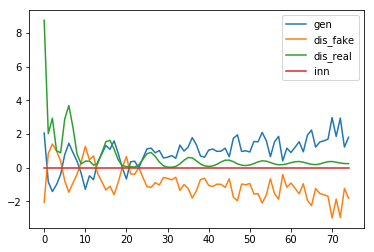

Pick prob : [0.13948427 0.15221184 0.         0.14592044 0.13291821 0.14921407
 0.13927791 0.14097325]
[3 1 0 5 0 7 1 3 7]
Generation 85  fitness : 0.5717579971638723
#################################
[0.1994647  0.1        0.36722744 0.1        0.35846639 0.55165363
 0.1        0.1       ]
population fitness : [-37.35213845 -30.66126226 -43.68614205 -29.88146654 -43.35536231
 -50.64928672 -29.82120409 -30.50008491]
mean fit : -36.988368416648605
population fitness : [-0.04817415  0.83790017 -0.88698775  0.9411687  -0.84318251 -1.80911866
  0.94914927  0.85924493]
tensor([-0.7270,  0.2938, -1.2733,  0.5167, -1.4818, -2.1683,  0.4553,  0.4553],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


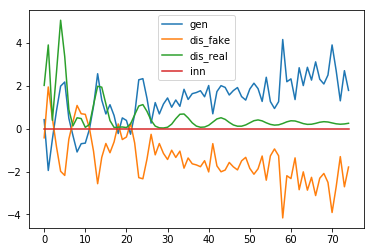

Pick prob : [0.12167143 0.18289422 0.0637141  0.1900295  0.0667408  0.
 0.19058092 0.18436903]
[1 6 0 7 2 1 1 1 1]
Generation 86  fitness : 0.9491492735732371
#################################
[0.1        0.5286052  0.10170298 0.55039885 0.14213276 0.1
 0.1        0.1       ]
population fitness : [ -14.29229932 -107.57186062  -32.23916988 -111.41764489  -39.37355387
  -29.72627916  -29.29594417  -31.63307192]
mean fit : -49.44372797923906
population fitness : [ 0.99599677 -1.64702929  0.48748187 -1.75599751  0.28533295  0.55868328
  0.57087659  0.50465533]
tensor([ 0.3775, -2.2035,  0.1091, -2.1641, -0.4289, -0.1226,  0.1103,  0.1103],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


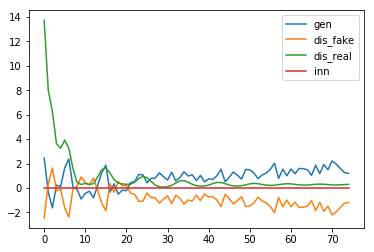

Pick prob : [0.19589964 0.00775686 0.15970121 0.         0.14531132 0.16476965
 0.16563763 0.16092369]
[6 2 2 2 0 6 2 4 6]
Generation 87  fitness : 0.9959967710925005
#################################
[0.1        0.45589635 0.38059332 0.43741645 0.1        0.1
 0.44612456 0.45064666]
population fitness : [-22.08800088 -36.64140307 -34.21470773 -36.04587471 -24.28791424
 -21.94980938 -36.32649999 -36.47222801]
mean fit : -31.003304751845917
population fitness : [ 1.38325835 -0.87478191 -0.49826681 -0.78238242  1.04192971  1.40469952
 -0.82592297 -0.84853347]
tensor([ 0.9787, -1.4953, -0.8809, -1.3179,  0.4862,  0.9195, -1.4015, -1.4015],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


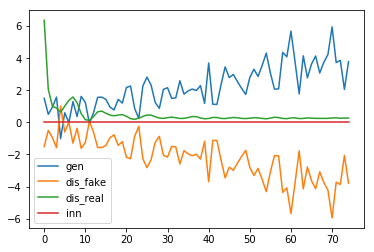

Pick prob : [0.3226576  0.         0.05380128 0.01320322 0.27388421 0.32572139
 0.00698159 0.00375071]
[5 0 5 5 4 4 5 5 0]
Generation 88  fitness : 1.4046995196672378
#################################
[0.1        0.1        0.1        0.1        0.1        0.6526002
 0.13869374 0.14059004]
population fitness : [ -13.90779476  -13.34859335  -24.28547669  -22.87038374  -26.13718548
 -131.93748072  -38.55167521  -38.89626659]
mean fit : -38.74185706694047
population fitness : [ 0.68331505  0.69870161  0.3977707   0.43670731  0.3468205  -2.56429946
  0.0052329  -0.00424861]
tensor([ 0.1441,  0.2223, -0.0540,  0.0698, -0.1217, -2.9562, -0.5278, -0.5278],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


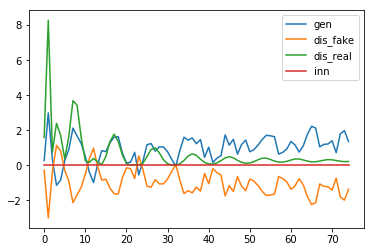

Pick prob : [0.15830905 0.15905909 0.14438983 0.14628785 0.1419062  0.
 0.12525508 0.1247929 ]
[1 4 6 0 0 0 0 0 0]
Generation 89  fitness : 0.6987016125944493
#################################
[0.14930838 0.1        0.10569219 0.1        0.1        0.1
 0.52383263 0.51460492]
population fitness : [ -47.28880557  -24.88567611  -39.85644514  -31.74367937  -35.64283434
  -21.84610253 -111.10913134 -109.53669599]
mean fit : -52.738671298540545
population fitness : [ 0.15991041  0.81726489  0.37799135  0.61603679  0.50162746  0.90645231
 -1.71271087 -1.66657234]
tensor([-0.5243,  0.0858, -0.1545,  0.3297, -0.0861,  0.3925, -2.2013, -2.2013],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


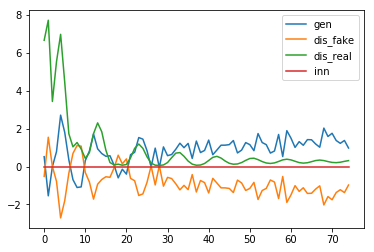

Pick prob : [0.13667086 0.18464703 0.15258721 0.16996065 0.16161064 0.19115626
 0.         0.00336736]
[3 0 3 1 0 4 0 5 4]
Generation 90  fitness : 0.9064523099972289
#################################
[0.1        0.1        0.1        0.1        0.1        0.40551596
 0.44345577 0.46090407]
population fitness : [ -33.90151834  -26.06121483  -22.70090905  -34.46577478  -28.56359183
 -124.71198711 -134.25607669 -138.64534963]
mean fit : -67.91330278130205
population fitness : [ 0.67602077  0.83185523  0.89864492  0.66480557  0.7821178  -1.1289349
 -1.31863394 -1.40587546]
tensor([ 0.1989,  0.2816,  0.5841,  0.0341,  0.1677, -1.4853, -1.8953, -1.8953],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


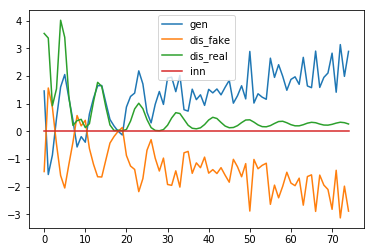

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 5 1 5 1 7 1 5 3]
Generation 91  fitness : 0.8986449237543194
#################################
[0.1       0.4755198 0.1       0.5440024 0.1       0.1       0.1
 0.1      ]
population fitness : [ -21.08752231 -105.53149557  -26.7744449  -117.69280372  -35.80414853
  -37.7127789   -32.26991166  -30.26517862]
mean fit : -50.8922855286051
population fitness : [ 0.83918099 -1.53841807  0.67906036 -1.88083108  0.42482061  0.37108134
  0.52433036  0.58077549]
tensor([ 0.4884, -2.0012,  0.1545, -2.3457, -0.1971, -0.3278, -0.0351, -0.0351],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


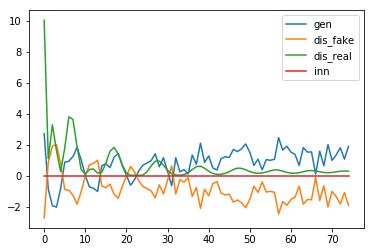

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[4 2 4 0 7 6 5 7 6]
Generation 92  fitness : 0.839180990279749
#################################
[0.13395497 0.1        0.1        0.59788818 0.17833232 0.18344317
 0.46327105 0.1       ]
population fitness : [-27.96812111 -26.61570141 -23.99037737 -41.74444835 -29.2858903
 -29.4376553  -37.74704189 -24.35570196]
mean fit : -30.143117210500776
population fitness : [ 0.36622706  0.59394824  1.03600176 -1.9534386   0.14434034  0.11878607
 -1.28035308  0.97448821]
tensor([-0.1291,  0.0076,  0.4088, -2.6544, -0.4271, -0.4605, -0.5782, -0.5782],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


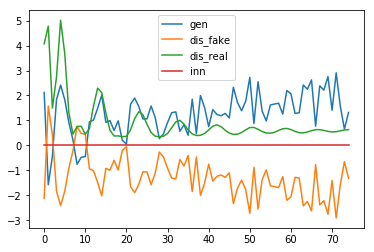

Pick prob : [0.14843477 0.16300658 0.19129347 0.         0.1342363  0.13260109
 0.04307056 0.18735723]
[2 5 4 0 4 2 7 7 1]
Generation 93  fitness : 1.0360017635348273
#################################
[0.1        0.1        0.1        0.1        0.1        0.46980578
 0.42354357 0.42834091]
population fitness : [ -24.76840206  -28.83796483  -18.84763955  -21.89622641  -32.96519037
 -122.669846   -112.44637626 -113.50653959]
mean fit : -59.49227313382154
population fitness : [ 0.78564482  0.69356894  0.91960501  0.85062922  0.60018841 -1.42942395
 -1.19811287 -1.22209959]
tensor([ 0.1033,  0.3718,  0.4933,  0.5222,  0.0600, -2.1500, -1.6237, -1.6237],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


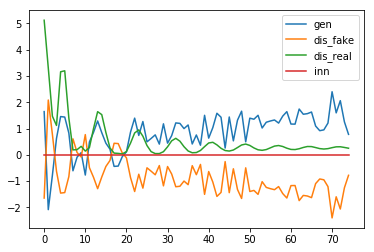

Pick prob : [0.19370292 0.18565109 0.20541745 0.19938567 0.17748517 0.
 0.02022765 0.01813006]
[3 4 2 4 4 3 3 3 2]
Generation 94  fitness : 0.9196050095048202
#################################
[0.1        0.1        0.1        0.53618243 0.1        0.1
 0.39252516 0.3938069 ]
population fitness : [ -14.73465227  -33.61630882  -23.24270448 -147.8121543   -24.46140246
  -25.46896434 -112.15721697 -112.47533696]
mean fit : -61.74609257483296
population fitness : [ 0.94706875  0.56668843  0.77566982 -1.73384344  0.75111855  0.73082072
 -1.01555707 -1.02196576]
tensor([ 0.2972, -0.1217,  0.2766, -2.3247,  0.3194,  0.2576, -1.4867, -1.4867],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


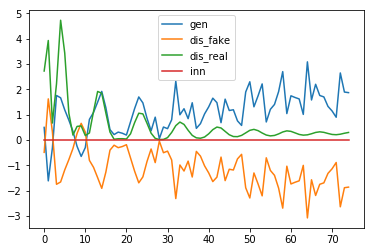

Pick prob : [0.19327813 0.16585493 0.18092127 0.         0.17915127 0.17768791
 0.05178426 0.05132223]
[4 0 6 1 5 5 4 6 5]
Generation 95  fitness : 0.9470687504341851
#################################
[0.575941   0.52483556 0.1        0.1        0.14762479 0.11492926
 0.13332135 0.13202929]
population fitness : [-112.45692728 -103.22104296   -8.37162523  -22.04216775  -35.05069634
  -29.14189034  -32.46574758  -32.23224331]
mean fit : -46.87279259775448
population fitness : [-1.81450175 -1.55897458  1.06520328  0.68698341  0.32707932  0.49055695
  0.39859653  0.40505684]
tensor([-2.1835, -2.1957,  0.4833,  0.3800, -0.3317, -0.2734, -0.0280, -0.0280],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


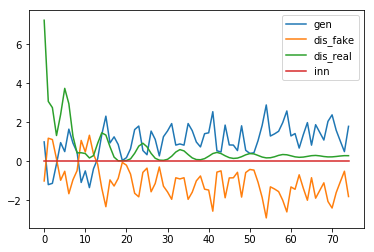

Pick prob : [0.         0.01760312 0.19838125 0.1723259  0.14753231 0.15879419
 0.15245909 0.15290414]
[5 6 3 4 5 5 6 7 3]
Generation 96  fitness : 1.065203284556227
#################################
[0.1        0.44350592 0.41955319 0.1        0.1        0.1
 0.38951612 0.38956727]
population fitness : [ -36.94154966 -132.41213277 -127.11705273  -34.36906071  -38.169907
  -38.5686293  -120.47694644 -120.48825352]
mean fit : -81.0679415155865
population fitness : [ 0.99804688 -1.16129844 -1.04153478  1.05623121  0.970264    0.96124573
 -0.89134943 -0.89160518]
tensor([ 0.4646, -1.7875, -1.2708,  0.6168,  0.5542,  0.4408, -1.4024, -1.4024],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


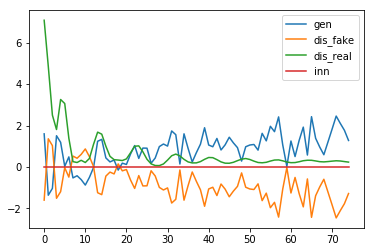

Pick prob : [0.23242791 0.         0.01289114 0.23869076 0.22943741 0.2284667
 0.02905681 0.02902928]
[4 0 5 4 5 3 4 4 4]
Generation 97  fitness : 1.0562312104989806
#################################
[0.51543339 0.40533205 0.50890342 0.45289227 0.39175661 0.1
 0.1        0.1       ]
population fitness : [-43.27548203 -39.74370953 -43.06601705 -41.26932115 -39.30824373
 -26.74168256 -29.66749101 -28.9378278 ]
mean fit : -36.50122185609553
population fitness : [-1.05592165 -0.50541503 -1.02327179 -0.74321611 -0.43753784  1.52124491
  1.0651915   1.17892601]
tensor([-1.4429, -1.1226, -1.4048, -1.0417, -0.8599,  0.7366,  0.4458,  0.4458],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


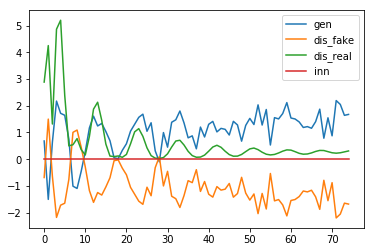

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[1 1 5 6 5 6 7 7 3]
Generation 98  fitness : 1.5212449121622826
#################################
[0.1        0.18526867 0.46065121 0.15485208 0.38573841 0.53349602
 0.10378563 0.56383221]
population fitness : [-28.66379825 -32.40673545 -37.97022115 -31.79223661 -36.45677619
 -39.44188676 -30.76055379 -40.05476131]
mean fit : -34.69337118779481
population fitness : [ 1.49226437  0.56592151 -0.81099051  0.71800437 -0.43642667 -1.17521434
  0.97333647 -1.32689521]
tensor([ 0.8372,  0.1195, -1.1672,  0.1408, -0.9004, -1.8325, -0.6041, -0.6041],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


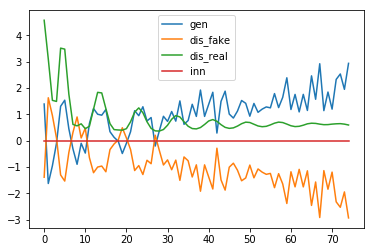

Pick prob : [0.26557858 0.17831257 0.04860074 0.19263951 0.08388648 0.01428908
 0.21669304 0.        ]
[4 0 4 1 6 4 3 6 0]
Generation 99  fitness : 1.4922643663660289
#################################
[0.1        0.17244129 0.1        0.69824829 0.13600665 0.15862895
 0.16573376 0.16346382]
population fitness : [ -28.22336125  -44.94219545  -21.76312569 -115.61968216  -40.04475438
  -43.08557924  -44.04058784  -43.73546897]
mean fit : -47.68184437227229
population fitness : [ 0.72380947  0.10190845  0.96411492 -2.52712659  0.28408165  0.17097017
  0.13544612  0.14679581]
tensor([ 0.1913, -0.5856,  0.3646, -3.0962, -0.0803, -0.3335, -0.2311, -0.2311],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


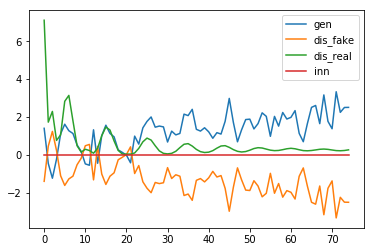

Pick prob : [0.160802   0.13004073 0.1726883  0.         0.13905161 0.13345675
 0.13169961 0.132261  ]
[2 6 5 2 4 0 2 7 4]
Generation 100  fitness : 0.9641149228581629
#################################
[0.1        0.64610436 0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -31.21427401 -117.77752533  -37.0483994   -38.91512686  -28.82571397
  -26.1748923   -35.67073386  -32.33357063]
mean fit : -43.495029544195056
population fitness : [ 0.43310163 -2.61969793  0.22735132  0.16151802  0.51733824  0.61082395
  0.27593703  0.39362774]
tensor([-0.1913, -3.2566, -0.3068, -0.6426,  0.1133, -0.0150, -0.0817, -0.0817],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


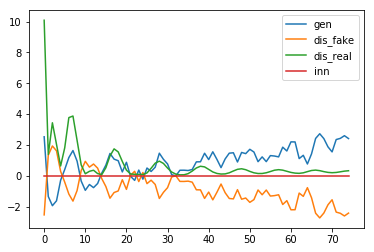

Pick prob : [0.14566563 0.         0.13584816 0.1327069  0.14968501 0.15414572
 0.13816645 0.14378211]
[0 5 6 7 3 3 4 3 2]
Generation 101  fitness : 0.6108239523184366
#################################
[0.21082891 0.39501554 0.62351825 0.1        0.34647842 0.1
 0.47128313 0.46846941]
population fitness : [-35.51627116 -41.49884855 -48.92085952 -28.66832417 -39.92231126
 -30.94957425 -43.97610084 -43.88470831]
mean fit : -39.16712475689795
population fitness : [ 0.56199717 -0.35893584 -1.50144925  1.61614157 -0.11625026  1.26497545
 -0.74027372 -0.72620514]
tensor([-0.1192, -0.8736, -2.1824,  1.3535, -0.6493,  0.6942, -1.0890, -1.0890],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


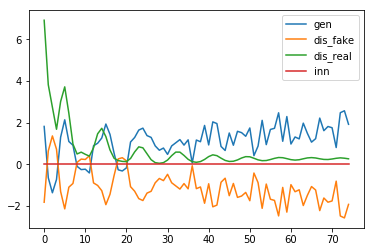

Pick prob : [0.17178789 0.09511755 0.         0.25954847 0.11532183 0.23031287
 0.06337007 0.06454132]
[0 5 3 4 0 0 7 5 3]
Generation 102  fitness : 1.6161415712728575
#################################
[0.1        0.1        0.1        0.48363128 0.1        0.1
 0.42258072 0.42041999]
population fitness : [ -37.4650882   -29.27757594  -29.89048926 -118.06913298  -39.73900791
  -40.28167607 -106.86064792 -106.46395296]
mean fit : -63.50594640292204
population fitness : [ 0.70919883  0.9321782   0.91548607 -1.48597822  0.64727072  0.63249165
 -1.18072543 -1.16992181]
tensor([ 0.3208,  0.6237,  0.2912, -2.2297,  0.3419,  0.2076, -1.6762, -1.6762],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


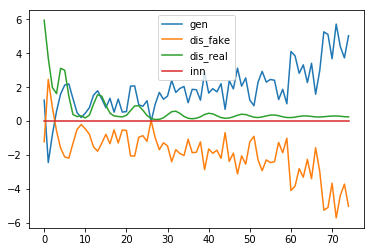

Pick prob : [0.18465757 0.20341452 0.20201039 0.         0.1794482  0.17820499
 0.02567776 0.02658656]
[1 0 2 1 1 0 4 5 4]
Generation 103  fitness : 0.9321781991407165
#################################
[0.63172621 0.1        0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [-128.14874843  -29.33366509  -42.50723511  -39.37702112  -37.4546002
  -29.29287218  -28.00008206  -29.06328168]
mean fit : -45.39718823254796
population fitness : [-2.60993644  0.50663425  0.09114745  0.1898726   0.25050464  0.50792083
  0.54869469  0.51516198]
tensor([-3.2510,  0.1543, -0.6617, -0.5778, -0.4838,  0.0134,  0.3859,  0.3859],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


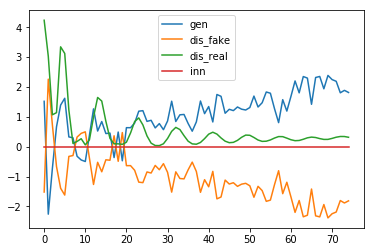

Pick prob : [0.         0.14926468 0.12936541 0.13409374 0.13699764 0.1493263
 0.15127912 0.14967311]
[6 2 6 6 5 7 4 6 6]
Generation 104  fitness : 0.5486946854484372
#################################
[0.4776432  0.1        0.1        0.1        0.1        0.1
 0.40956029 0.43143599]
population fitness : [-139.51300956  -35.20068786  -49.47310098  -29.51707332  -34.78515818
  -34.05255002 -123.83427134 -128.8720019 ]
mean fit : -71.90598164359008
population fitness : [-1.46787411  0.79694009  0.48705949  0.92034191  0.80596201  0.82186829
 -1.12745959 -1.23683808]
tensor([-2.0807,  0.2687, -0.0636,  0.3143,  0.3827,  0.1379, -1.4330, -1.4330],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


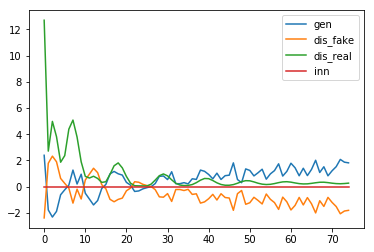

Pick prob : [0.         0.19286516 0.16647661 0.20337371 0.19363344 0.19498797
 0.02898874 0.01967437]
[5 2 2 2 4 2 1 7 2]
Generation 105  fitness : 0.9203419106429943
#################################
[0.39902826 0.45742627 0.1        0.1        0.4862015  0.1
 0.1        0.1       ]
population fitness : [-122.94011059 -138.93457697  -31.14249553  -36.97506837 -146.81574413
  -26.79903299  -13.65137112  -15.20984059]
mean fit : -66.55853003570066
population fitness : [-1.02928466 -1.32127468  0.64654415  0.54006651 -1.46515082  0.72583705
  0.96585669  0.93740576]
tensor([-1.6251, -1.9018,  0.1148,  0.0298, -2.0843,  0.1692,  0.6181,  0.6181],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


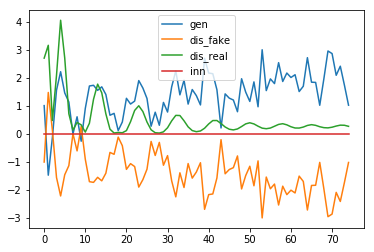

Pick prob : [0.03718612 0.01227486 0.1801602  0.17107602 0.         0.18692511
 0.2074025  0.20497519]
[5 5 5 3 2 2 3 2 5]
Generation 106  fitness : 0.965856694302068
#################################
[0.1        0.1        0.1        0.1        0.1        0.11912798
 0.65650674 0.1       ]
population fitness : [ -38.45803674  -27.26949901  -39.20401321  -37.18949256  -35.84448411
  -48.26043546 -142.949214    -37.08500107]
mean fit : -50.78252201848004
population fitness : [ 0.34972025  0.6672068   0.32855238  0.38571653  0.42388256  0.07156686
 -2.61532697  0.38868159]
tensor([-0.3082,  0.1441, -0.3788, -0.2590,  0.1577, -0.3982, -1.5630, -1.5630],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


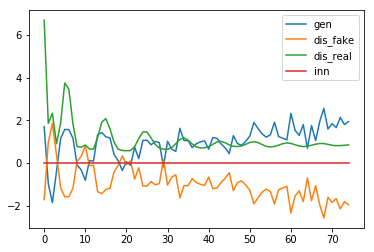

Pick prob : [0.14171494 0.15688926 0.14070322 0.14343539 0.14525954 0.12842055
 0.         0.1435771 ]
[4 5 5 4 1 5 1 1 3]
Generation 107  fitness : 0.6672067953484978
#################################
[0.46101255 0.24759089 0.1        0.1        0.1        0.42119307
 0.5605224  0.31142209]
population fitness : [-40.93819271 -36.10974151 -30.50824558 -32.6905098  -30.56915744
 -40.03731678 -43.18950344 -37.55385844]
mean fit : -36.44956571380478
population fitness : [-0.99200531  0.07510257  1.31305655  0.83076705  1.29959478 -0.79290796
 -1.48955438 -0.2440533 ]
tensor([-1.6011, -0.4111,  0.6213,  0.1026,  0.9184, -1.5871, -1.1462, -1.1462],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


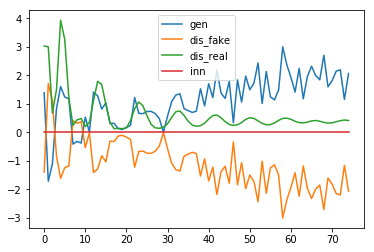

Pick prob : [0.04175318 0.13130244 0.23518871 0.19471607 0.23405902 0.05846098
 0.         0.1045196 ]
[3 2 3 2 2 2 2 3 2]
Generation 108  fitness : 1.3130565547551887
#################################
[0.1        0.48495476 0.39974355 0.36185561 0.38314587 0.72588203
 0.28481031 0.57781191]
population fitness : [-24.0062418  -34.23150221 -32.43482573 -31.63595938 -32.08486393
 -39.31144833 -30.01146082 -36.18939311]
mean fit : -32.48821191154914
population fitness : [ 2.01137659 -0.41339609  0.01265976  0.20209937  0.09564814 -1.61803187
  0.58732572 -0.87768161]
tensor([ 1.8337, -1.0146, -0.3688, -0.2769, -0.3088, -2.1958, -0.7169, -0.7169],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


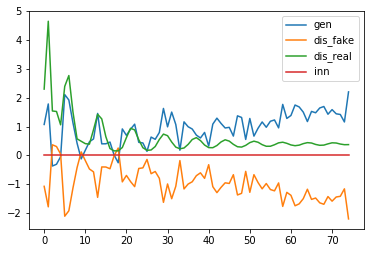

Pick prob : [0.28038759 0.09306335 0.12597802 0.14061306 0.13238923 0.
 0.17037347 0.05719528]
[0 2 0 0 7 2 0 0 1]
Generation 109  fitness : 2.011376589544295
#################################
[0.1        0.50471053 0.1        0.1        0.1        0.45097015
 0.1        0.1       ]
population fitness : [ -32.8967991  -150.76616117  -32.67344856  -43.97965599  -35.9385559
 -138.19192754  -36.54804268  -39.58901613]
mean fit : -63.82295088314698
population fitness : [ 0.66086867 -1.85791121  0.66564151  0.42403633  0.59586861 -1.58920926
  0.58284434  0.51786101]
tensor([ 0.0001, -2.4135,  0.1734, -0.1167,  0.0820, -2.2017, -0.0130, -0.0130],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


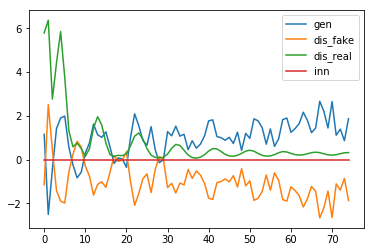

Pick prob : [0.16946315 0.         0.16978427 0.1535291  0.16508995 0.01807823
 0.16421368 0.15984161]
[2 4 3 0 5 7 6 3 6]
Generation 110  fitness : 0.6656415060915136
#################################
[0.1        0.1        0.1        0.1        0.62209418 0.1
 0.1        0.1       ]
population fitness : [ -40.89675779  -44.769223    -39.67036806  -34.20346562 -146.0332491
  -33.82564979  -33.34309385  -33.35003002]
mean fit : -50.761479654615044
population fitness : [ 0.27228582  0.16539812  0.3061366   0.45703391 -2.62968909  0.46746237
  0.48078187  0.48059041]
tensor([-0.2111, -0.3077, -0.2002,  0.0016, -3.2295,  0.0454,  0.0925,  0.0925],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


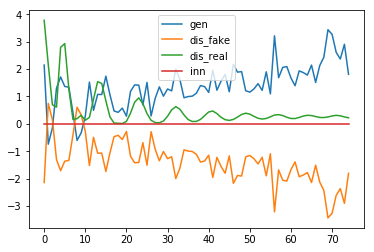

Pick prob : [0.13794287 0.13286206 0.13955194 0.14672471 0.         0.14722042
 0.14785355 0.14784445]
[6 7 5 1 2 1 1 2 5]
Generation 111  fitness : 0.4807818665777291
#################################
[0.1        0.38661582 0.1        0.1        0.25477494 0.60573654
 0.1        0.1       ]
population fitness : [-30.81758855 -46.19412751 -33.30030744 -31.95677219 -40.95053365
 -54.90902804 -33.30208305 -34.4509196 ]
mean fit : -38.23517000373006
population fitness : [ 0.93250962 -1.00056933  0.62039182  0.78929587 -0.341365   -2.09617288
  0.62016859  0.47574131]
tensor([ 0.4732, -1.5874,  0.1390,  0.2524, -0.7661, -2.4957,  0.1282,  0.1282],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


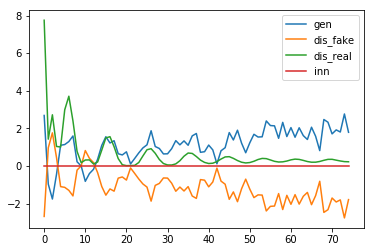

Pick prob : [0.18060787 0.06533356 0.16199551 0.17206767 0.10464356 0.
 0.16198219 0.15336964]
[2 7 0 3 6 7 7 0 3]
Generation 112  fitness : 0.9325096239047683
#################################
[0.23121656 0.30487543 0.15899383 0.48765345 0.3832219  0.1
 0.57052367 0.62633432]
population fitness : [-35.24647104 -36.44895647 -34.06743075 -39.43281845 -37.72796721
 -31.47184706 -40.78567969 -41.69679182]
mean fit : -37.109745311040726
population fitness : [ 0.57067869  0.20238465  0.93179202 -0.71150467 -0.18934736  1.72676049
 -1.12585541 -1.40490841]
tensor([-0.0950, -0.1332,  0.3120, -1.3488, -0.8412,  1.0918, -1.5855, -1.5855],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


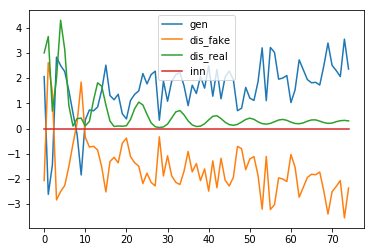

Pick prob : [0.17577544 0.14300693 0.20790505 0.06169475 0.10815305 0.27863639
 0.0248284  0.        ]
[5 5 0 2 1 5 0 1 0]
Generation 113  fitness : 1.7267604906072915
#################################
[0.21189631 0.1315901  0.65120856 0.1        0.33916524 0.39276853
 0.1        0.1       ]
population fitness : [-33.67693215 -30.29198254 -52.19417719 -24.74538969 -39.04138507
 -41.30079227 -28.58801424 -28.13050842]
mean fit : -34.746147697478136
population fitness : [ 0.12683298  0.52836402 -2.06972813  1.18631449 -0.50951161 -0.77752805
  0.73049292  0.78476339]
tensor([-0.6323, -0.1307, -2.2218,  0.6574, -1.1659, -1.4238,  0.6373,  0.6373],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


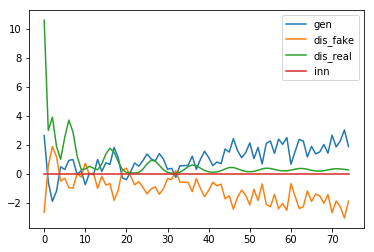

Pick prob : [0.13266    0.15691023 0.         0.19664676 0.09422835 0.07804166
 0.16911769 0.17239532]
[6 1 1 4 5 4 1 7 7]
Generation 114  fitness : 1.186314489404003
#################################
[0.1        0.1        0.1        0.14187856 0.1        0.62699364
 0.1        0.1       ]
population fitness : [ -37.80114475  -40.11551653  -35.63043433  -52.66804534  -37.1586465
 -110.92351227  -38.08689622  -37.8371466 ]
mean fit : -48.77766781743884
population fitness : [ 0.45702809  0.36066489  0.54740968 -0.16198315  0.4837797  -2.58755858
  0.44513029  0.45552908]
tensor([-0.0237, -0.0752,  0.0228, -0.6895, -0.1660, -3.0736, -0.0905, -0.0905],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


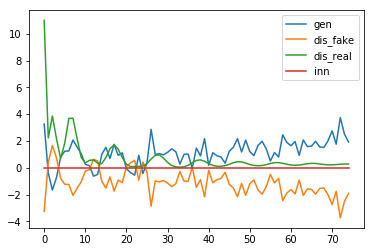

Pick prob : [0.14707815 0.14242303 0.15144431 0.1171749  0.14837047 0.
 0.14650339 0.14700574]
[7 4 6 7 6 1 2 4 7]
Generation 115  fitness : 0.5474096793867416
#################################
[0.1921502  0.17747039 0.33938458 0.1        0.23664585 0.33744921
 0.52122369 0.6852939 ]
population fitness : [-37.7847592  -37.53569942 -40.28275997 -34.52470992 -38.53967923
 -40.24992417 -43.3678699  -46.15150976]
mean fit : -39.80461394470433
population fitness : [ 0.59525968  0.66865865 -0.14091164  1.5560099   0.37278158 -0.13123479
 -1.05010651 -1.87045687]
tensor([ 0.0057,  0.5014, -0.8079,  0.9747, -0.1245, -0.5166, -1.9851, -1.9851],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


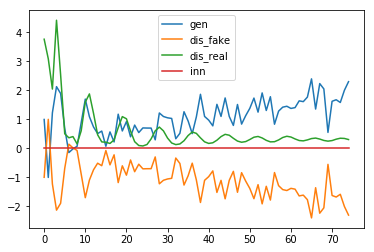

Pick prob : [0.16478037 0.16968552 0.11558307 0.22898595 0.14991247 0.11622976
 0.05482286 0.        ]
[2 1 3 1 0 3 0 3 1]
Generation 116  fitness : 1.5560099047208034
#################################
[0.25671244 0.41183925 0.48726181 0.1        0.71869859 0.5730842
 0.38229089 0.40524864]
population fitness : [-27.91778434 -32.49215377 -34.71620958 -20.34786404 -41.54080273
 -37.24693495 -31.62083366 -32.29781044]
mean fit : -32.27254918900388
population fitness : [ 0.73839754 -0.03723634 -0.41434908  2.0219595  -1.57153275 -0.84346097
  0.11050542 -0.00428332]
tensor([ 0.1905, -0.7047, -0.9227,  1.3234, -2.1059, -1.3070, -0.3018, -0.3018],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


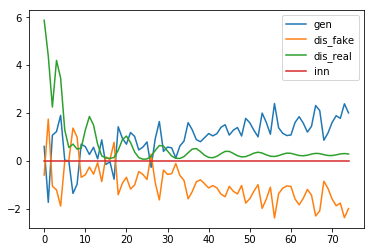

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 5 4 0 6 7 5 0 6]
Generation 117  fitness : 2.0219594992015337
#################################
[0.64851925 0.38080668 0.24054085 0.31460807 0.59363764 0.38934113
 0.1660178  0.1       ]
population fitness : [-47.83404195 -39.21236059 -34.69510081 -37.0804351  -46.0665801
 -39.48721254 -32.29508631 -26.94848435]
mean fit : -37.95241271847269
population fitness : [-1.53417637 -0.19561372  0.50571529  0.13537924 -1.25976836 -0.23828597
  0.87833052  1.70841938]
tensor([-2.0043, -0.6244,  0.0041, -0.4759, -1.6991, -0.8174,  0.7180,  0.7180],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


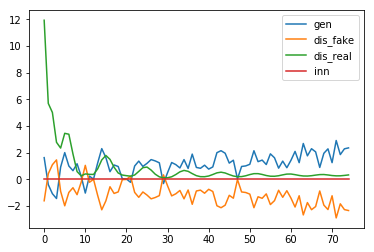

Pick prob : [0.         0.10906199 0.16620414 0.13603029 0.02235793 0.10558519
 0.19656368 0.26419679]
[6 1 6 6 1 3 2 7 5]
Generation 118  fitness : 1.7084193827228384
#################################
[0.1        0.32856397 0.1        0.24961852 0.2135485  0.1
 0.40336325 0.66510929]
population fitness : [-27.54782886 -39.60589032 -26.23120578 -35.47186048 -33.58303036
 -22.40042384 -43.52280314 -57.22930561]
mean fit : -35.699043548900676
population fitness : [ 0.77829782 -0.37303524  0.9040122   0.02169199  0.20204209  1.26978458
 -0.74703161 -2.05576183]
tensor([ 0.1778, -0.7925,  0.4050, -0.6646, -0.4208,  0.9838, -1.7269, -1.7269],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


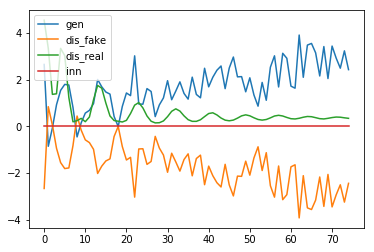

Pick prob : [0.17232417 0.1023177  0.1799682  0.12631898 0.13728511 0.20220888
 0.07957696 0.        ]
[1 1 3 4 0 2 6 3 3]
Generation 119  fitness : 1.269784579257314
#################################
[0.1        0.1        0.1        0.54999569 0.40699178 0.1
 0.1        0.1       ]
population fitness : [ -33.50897183  -39.66333024  -37.91494234 -148.27385674 -116.50621646
  -26.09492368  -28.24302075  -26.6521221 ]
mean fit : -57.10717301790634
population fitness : [ 0.53114349  0.39262245  0.43197481 -2.05196111 -1.33694154  0.69801738
  0.64966845  0.68547607]
tensor([-0.0834, -0.1407,  0.0884, -2.6196, -1.7818,  0.1088,  0.2618,  0.2618],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


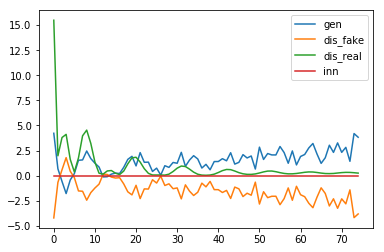

Pick prob : [0.15735585 0.14891751 0.15131475 0.         0.04355709 0.16752136
 0.16457607 0.16675737]
[6 2 0 5 0 5 5 7 5]
Generation 120  fitness : 0.698017376941128
#################################
[0.1        0.1        0.1        0.62795493 0.1        0.1
 0.1        0.1       ]
population fitness : [ -39.55800299  -43.08224831  -31.29863938 -127.46970223  -31.67321386
  -30.71706302  -29.33872782  -32.01031643]
mean fit : -45.643489254104274
population fitness : [ 0.19470973  0.08194884  0.45897432 -2.61809156  0.44698953  0.47758229
  0.52168317  0.43620367]
tensor([-0.3371, -0.2823,  0.1353, -3.3385,  0.0079, -0.0749,  0.0544,  0.0544],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


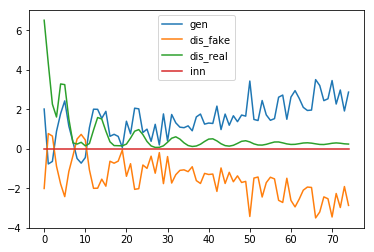

Pick prob : [0.13429636 0.12891262 0.14691359 0.         0.14634138 0.14780202
 0.14990761 0.14582641]
[4 7 4 2 0 4 1 4 7]
Generation 121  fitness : 0.5216831715943254
#################################
[0.23831162 0.1        0.39663394 0.1951737  0.66121019 0.1
 0.27272596 0.40981144]
population fitness : [-29.88061655 -21.8664412  -35.20483366 -28.4299325  -44.10226117
 -23.25979571 -31.03793534 -35.64797946]
mean fit : -31.17872445011582
population fitness : [ 0.19300436  1.38456233 -0.59860713  0.40869395 -1.92148818  1.17739658
  0.02093271 -0.66449462]
tensor([-0.3600,  1.1253, -1.3402, -0.0564, -2.0721,  0.5965, -0.8424, -0.8424],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


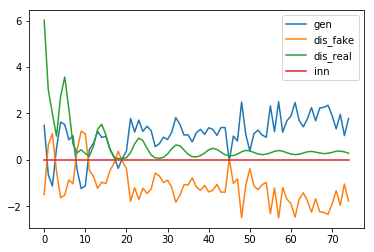

Pick prob : [0.13755566 0.21507096 0.08605836 0.15158707 0.         0.20159406
 0.12636175 0.08177214]
[5 0 2 6 1 2 7 6 0]
Generation 122  fitness : 1.3845623333741532
#################################
[0.1        0.1        0.1        0.63191628 0.1        0.1
 0.1        0.1       ]
population fitness : [ -39.18105349  -35.06472366  -32.32389076 -106.95396661  -33.14193587
  -43.01452961  -39.43729037  -32.48599086]
mean fit : -45.200422654511584
population fitness : [ 0.25483945  0.42911073  0.5451482  -2.61443325  0.51051497  0.09254321
  0.24399125  0.53828543]
tensor([-0.3330, -0.1945,  0.2535, -2.9419, -0.0211, -0.3439, -0.0304, -0.0304],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


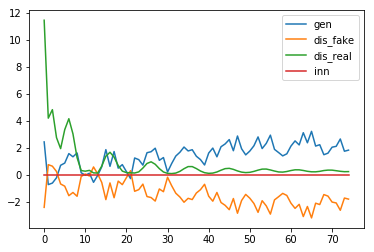

Pick prob : [0.13718426 0.14551643 0.15106436 0.         0.14940849 0.12942463
 0.13666559 0.15073624]
[0 1 2 4 0 4 7 2 1]
Generation 123  fitness : 0.5451481959494928
#################################
[0.1        0.12393399 0.1        0.1        0.1        0.1
 0.48822612 0.52972856]
population fitness : [ -33.5279603   -46.91537745  -37.0804243   -29.75636175  -38.53500213
  -37.57346402  -97.35266515 -103.09879635]
mean fit : -52.980006429537994
population fitness : [ 0.70247904  0.21901422  0.57418757  0.83868419  0.52165786  0.55638225
 -1.60244647 -1.80995866]
tensor([ 0.1856, -0.3461, -0.1724,  0.3611, -0.0866, -0.1448, -1.8199, -1.8199],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


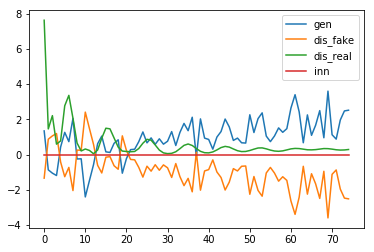

Pick prob : [0.17351485 0.14012564 0.16465474 0.1829215  0.16102692 0.16342507
 0.01433128 0.        ]
[4 4 0 0 1 4 0 4 0]
Generation 124  fitness : 0.8386841920272609
#################################
[0.1        0.1        0.36425709 0.18957117 0.61481415 0.53433863
 0.15387584 0.27796402]
population fitness : [-35.03648868 -37.83421427 -45.58512907 -40.5263423  -52.84109311
 -50.51057626 -39.49262948 -43.08613985]
mean fit : -43.11407662675288
population fitness : [ 1.39464328  0.91159943 -0.4266418   0.44678762 -1.67942686 -1.27704935
  0.62526424  0.00482345]
tensor([ 0.6989,  0.0896, -0.7239,  0.0690, -2.3323, -1.8638, -0.0369, -0.0369],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


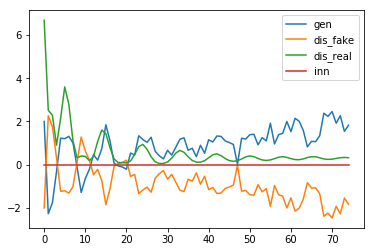

Pick prob : [0.22880351 0.19285049 0.09324498 0.15825447 0.         0.02994902
 0.17153851 0.12535901]
[1 0 6 0 0 3 7 7 1]
Generation 125  fitness : 1.3946432751191566
#################################
[0.1        0.52235368 0.26517537 0.51893053 0.59245929 0.27209583
 0.33257906 0.63501657]
population fitness : [-29.60808288 -48.99890419 -39.45192694 -48.8718299  -51.60136565
 -39.70882859 -41.95408788 -53.18117787]
mean fit : -44.17202548571522
population fitness : [ 1.96163127 -0.65013688  0.63575456 -0.63302112 -1.00066489  0.60115223
  0.29873612 -1.2134513 ]
tensor([ 1.3634, -1.0499,  0.0377, -1.1116, -1.3826,  0.1954, -1.0016, -1.0016],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


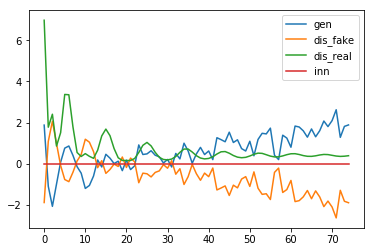

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 6 5 4 5 1 6 6 3]
Generation 126  fitness : 1.9616312731057028
#################################
[0.1        0.54626481 0.1        0.42596393 0.1        0.40316332
 0.40483685 0.40469703]
population fitness : [ -41.74235759 -152.76748338  -33.26130642 -124.63754531  -25.03446195
 -119.30608214 -119.69740404 -119.66471016]
mean fit : -92.01391887264319
population fitness : [ 1.0749603  -1.29909771  1.25631121 -0.69759328  1.4322264  -0.58359023
 -0.5919579  -0.5912588 ]
tensor([ 0.6003, -1.7657,  0.5728, -1.2523,  1.1167, -0.7825, -1.1193, -1.1193],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


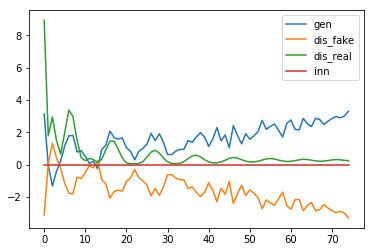

Pick prob : [0.22843336 0.         0.24588306 0.05787714 0.26280973 0.06884658
 0.06804144 0.06810871]
[0 2 6 0 4 4 0 4 4]
Generation 127  fitness : 1.432226402278846
#################################
[0.1        0.1        0.1        0.1        0.1        0.1
 0.49363079 0.46976925]
population fitness : [ -43.90344173  -39.81482493  -47.66063049  -50.88101282  -37.97059249
  -39.09549134 -157.44689129 -151.67154574]
mean fit : -71.05555385400658
population fitness : [ 0.5609112   0.64537428  0.4832948   0.4167678   0.68347263  0.66023435
 -1.78468138 -1.66537368]
tensor([ 0.0630,  0.1646, -0.1078,  0.0446, -0.1336,  0.0982, -2.0964, -2.0964],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


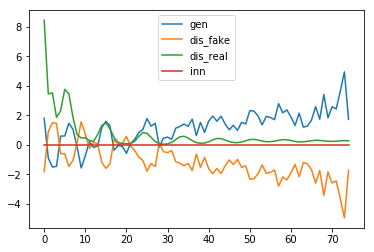

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[1 5 7 5 7 3 2 7 0]
Generation 128  fitness : 0.6834726269710297
#################################
[0.3313401  0.62573132 0.5824818  0.58684596 0.36240394 0.1
 0.24089828 0.28252368]
population fitness : [-42.0144328  -52.52782662 -50.98328573 -51.13914029 -43.12379443
 -30.18150849 -38.78454541 -40.27108489]
mean fit : -43.6282023320018
population fitness : [ 0.22594014 -1.24601579 -1.0297682  -1.05158904  0.07062098  1.88264048
  0.67814919  0.47002224]
tensor([-0.1916, -1.6832, -1.4062, -1.4848, -0.2671,  1.3973, -0.1948, -0.1948],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


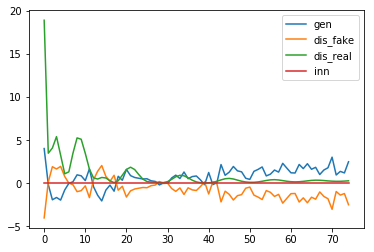

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[0 3 4 0 6 0 2 7 2]
Generation 129  fitness : 1.8826404770226
#################################
[0.1        0.5369119  0.1        0.12960631 0.57858593 0.1
 0.20329183 0.16695271]
population fitness : [ -36.31797646 -136.48807209  -16.2920675   -45.30643879 -145.81744607
  -38.5649777   -61.80207713  -53.66700618]
mean fit : -66.78200774043307
population fitness : [ 0.68040952 -1.55687437  1.12768515  0.47965357 -1.76524452  0.63022308
  0.11122599  0.29292157]
tensor([ 0.4057, -1.9927,  0.4807, -0.1958, -2.2143,  0.2358, -0.5418, -0.5418],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


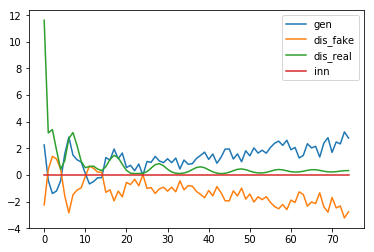

Pick prob : [0.17318097 0.01475505 0.20485332 0.15896509 0.         0.16962718
 0.1328761  0.14574228]
[7 2 7 3 7 5 0 0 3]
Generation 130  fitness : 1.1276851540892767
#################################
[0.1        0.1        0.1        0.1        0.41998673 0.1
 0.56955553 0.1       ]
population fitness : [ -25.86475427  -35.22799657  -41.45830006  -42.22485624 -123.86821822
  -26.96724532 -158.76994277  -48.73434979]
mean fit : -62.88945790627926
population fitness : [ 0.7933334   0.59270593  0.45920836  0.44278325 -1.30660026  0.76971018
 -2.0544443   0.30330344]
tensor([ 0.3005,  0.0572, -0.0358, -0.2019, -1.7871,  0.5625, -1.2596, -1.2596],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


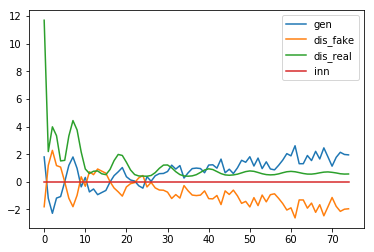

Pick prob : [0.17326934 0.16106242 0.15293994 0.15194057 0.0455016  0.17183202
 0.         0.1434541 ]
[5 0 2 5 2 1 7 2 3]
Generation 131  fitness : 0.7933334039904544
#################################
[0.1        0.31219903 0.65982502 0.33656871 0.12798134 0.2571341
 0.1        0.1021366 ]
population fitness : [-30.01148755 -41.39244266 -55.83699997 -42.40505167 -33.73782783
 -39.10438439 -28.41994628 -32.66392695]
mean fit : -37.94650841285506
population fitness : [ 0.95482998 -0.41465314 -2.15278296 -0.53650152  0.50643527 -0.13932852
  1.14634193  0.63565896]
tensor([ 0.8593, -0.9064, -2.4053, -0.8431,  0.0498, -0.8469,  0.1737,  0.1737],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


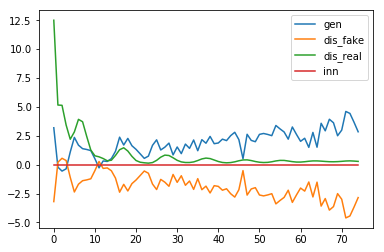

Pick prob : [0.18044161 0.10092342 0.         0.09384837 0.15440585 0.11690998
 0.19156163 0.16190914]
[0 6 6 4 5 3 6 1 7]
Generation 132  fitness : 1.1463419278719085
#################################
[0.1        0.1        0.11999346 0.1        0.45904487 0.1
 0.1        0.53553661]
population fitness : [ -29.49610074  -33.05692675  -50.71290933  -32.5929963  -115.45895617
  -27.79867977  -46.62817184 -130.06599767]
mean fit : -58.226342321859285
population fitness : [ 0.75224895  0.65901522  0.19672553  0.67116239 -1.49853156  0.79669282
  0.30367693 -1.88099029]
tensor([ 0.3268, -0.0957, -0.2560,  0.1187, -1.9394,  0.4322, -1.1576, -1.1576],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


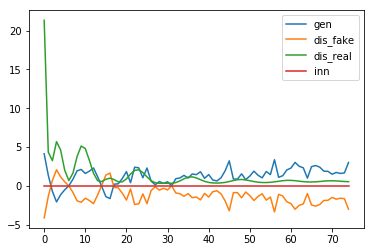

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[1 1 2 1 5 7 7 2 4]
Generation 133  fitness : 0.7966928217081282
#################################
[0.1        0.49630632 0.48801254 0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -44.0147976  -121.97134212 -120.4454876   -41.50602519  -38.87557618
  -30.66297185  -32.23583347  -33.60995826]
mean fit : -57.915249033244635
population fitness : [ 0.37777927 -1.74088334 -1.69941446  0.44596139  0.51745037  0.74064828
  0.69790186  0.66055661]
tensor([-0.1205, -2.4312, -2.4217, -0.0801,  0.4196,  0.4000,  0.3547,  0.3547],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


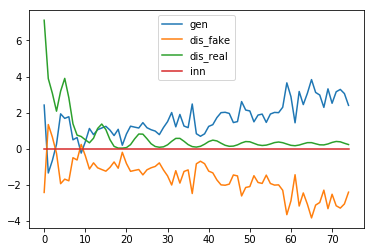

Pick prob : [0.15212554 0.         0.00297757 0.1570212  0.1621543  0.17818049
 0.17511119 0.1724297 ]
[4 7 7 3 6 7 3 4 5]
Generation 134  fitness : 0.740648282492756
#################################
[0.1        0.68722847 0.43496425 0.46354203 0.55030584 0.48166918
 0.5731175  0.65534357]
population fitness : [-28.55846442 -50.49807541 -42.44459797 -43.35693707 -46.12685194
 -43.93564214 -46.85510869 -49.4801573 ]
mean fit : -43.9069793652922
population fitness : [ 2.40385642 -1.03228544  0.22903551  0.08614662 -0.34767239 -0.00448911
 -0.46173064 -0.87286096]
tensor([ 2.0339, -1.5515, -0.3219, -0.2654, -0.8748, -0.6703, -1.1535, -1.1535],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


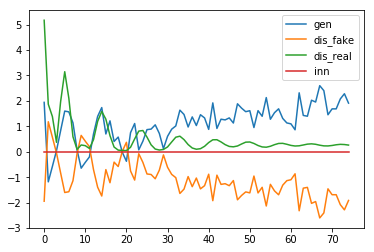

Pick prob : [0.41608427 0.         0.15273403 0.13543154 0.08290016 0.12445641
 0.06908879 0.0193048 ]
[6 0 0 5 0 0 5 0 3]
Generation 135  fitness : 2.4038564169457053
#################################
[0.62802423 0.25670533 0.4304933  0.1        0.43985025 0.28496676
 0.1        0.12248259]
population fitness : [-49.70658378 -40.15150143 -44.62355579 -35.17668039 -44.86433653
 -40.87874769 -33.54574921 -36.6975716 ]
mean fit : -40.705590803376495
population fitness : [-1.74893199  0.10766197 -0.7612776   1.07429128 -0.80806234 -0.03364513
  1.39118829  0.77877552]
tensor([-2.2320, -0.2823, -1.1381,  0.4334, -1.2688, -0.4220,  0.6022,  0.6022],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


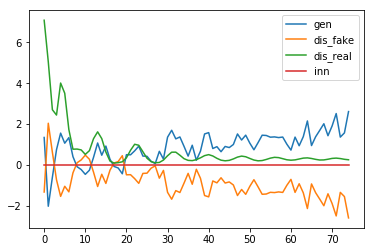

Pick prob : [0.         0.13269484 0.07058982 0.20178195 0.06724601 0.12259531
 0.22443127 0.18066079]
[3 2 2 7 3 7 6 1 2]
Generation 136  fitness : 1.3911882870288843
#################################
[0.24752714 0.5315252  0.54971681 0.51469095 0.25835173 0.1
 0.1        0.26366667]
population fitness : [-36.36645561 -39.11293008 -39.28885667 -38.9501303  -36.4711375
 -33.97268224 -34.46261994 -36.52253694]
mean fit : -36.8934186601743
population fitness : [ 0.27245121 -1.14753505 -1.23849287 -1.06336407  0.21832842  1.51008342
  1.25677512  0.19175381]
tensor([-0.4023, -1.4475, -1.3384, -1.6456, -0.3487,  0.8173,  0.1226,  0.1226],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


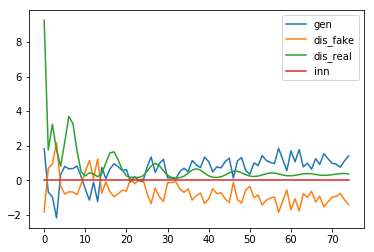

Pick prob : [0.15249826 0.00918029 0.         0.0176756  0.1470357  0.2774114
 0.25184521 0.14435354]
[5 4 5 0 6 3 5 5 6]
Generation 137  fitness : 1.5100834239771774
#################################
[0.27701385 0.50587924 0.41611057 0.73533388 0.47579523 0.1
 0.33606267 0.5071363 ]
population fitness : [-29.58575349 -38.70834232 -35.13015745 -47.85441918 -37.50919174
 -18.54396359 -31.93944294 -38.75844878]
mean fit : -34.75371493653731
population fitness : [ 0.64826302 -0.49606382 -0.04722051 -1.64333697 -0.34564378  2.03333219
  0.35301898 -0.50234911]
tensor([ 0.2731, -0.7700, -0.6983, -2.1044, -1.0197,  1.6751, -0.5777, -0.5777],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


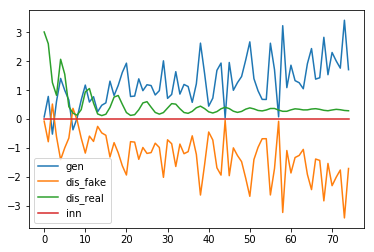

Pick prob : [0.17430996 0.08726703 0.12140818 0.         0.0987087  0.27966489
 0.1518523  0.08678895]
[7 6 0 6 6 0 5 4 0]
Generation 138  fitness : 2.033332187511542
#################################
[0.1        0.6528012  0.19928781 0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -33.47040567 -110.45824902  -50.0203009   -23.46199658  -28.09463895
  -31.09654433  -31.48943538  -32.2277195 ]
mean fit : -42.53991129058228
population fitness : [ 0.34027812 -2.54822315 -0.28065619  0.71578289  0.54197112  0.42934285
  0.414602    0.38690237]
tensor([-0.1576, -3.0835, -0.8671,  0.2583,  0.0117, -0.2544, -0.0084, -0.0084],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


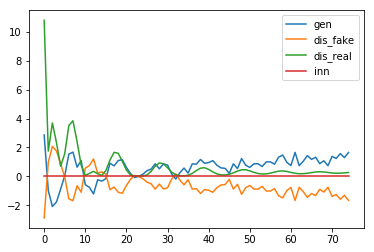

Pick prob : [0.14169193 0.         0.11123275 0.16011186 0.15158574 0.14606089
 0.1453378  0.14397903]
[4 5 6 2 3 0 4 6 7]
Generation 139  fitness : 0.7157828889914742
#################################
[0.58377854 0.29892136 0.11798815 0.25311907 0.45365061 0.1
 0.52573543 0.53840779]
population fitness : [-43.24746473 -32.5702868  -25.78844589 -30.85349924 -38.36993602
 -21.36594712 -41.07185992 -41.54685253]
mean fit : -34.35178653322229
population fitness : [-1.186642    0.23764376  1.14230972  0.46665522 -0.53600241  1.73225044
 -0.89642646 -0.95978826]
tensor([-1.6292, -0.2616,  0.4744, -0.0989, -1.2980,  1.2272, -1.2625, -1.2625],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


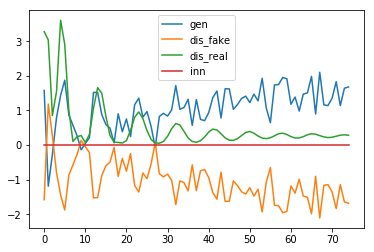

Pick prob : [0.         0.15003322 0.24533007 0.17415712 0.0685379  0.30747399
 0.03057109 0.02389661]
[2 5 4 3 5 3 5 2 7]
Generation 140  fitness : 1.7322504368596137
#################################
[0.12628652 0.1        0.45550418 0.56745026 0.29225711 0.1
 0.18831383 0.1       ]
population fitness : [-33.57536028 -32.02237194 -38.75970567 -40.52257312 -36.18897729
 -31.58666708 -34.55213348 -31.72881636]
mean fit : -34.86707565268744
population fitness : [ 0.41013386  0.90322476 -1.23595291 -1.79568275 -0.41971833  1.04156586
  0.09999761  0.9964319 ]
tensor([-0.3276,  0.2725, -1.4534, -2.4375, -1.0742,  0.5774,  0.1424,  0.1424],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


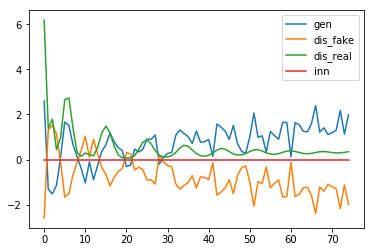

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[4 6 6 2 1 1 3 5 6]
Generation 141  fitness : 1.0415658570610713
#################################
[0.1        0.43767019 0.13689685 0.1        0.26072947 0.31334829
 0.62459904 0.40082663]
population fitness : [-29.50089039 -42.52317004 -33.5740694  -30.44871355 -37.25854033
 -38.82414161 -48.08498315 -41.42694016]
mean fit : -37.70518107920819
population fitness : [ 1.3787036  -0.80964692  0.6942195   1.21942509  0.07505648 -0.18803757
 -1.74429101 -0.62542916]
tensor([ 0.9215, -1.2845,  0.1074,  0.5681, -0.2881, -0.6754, -1.7495, -1.7495],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


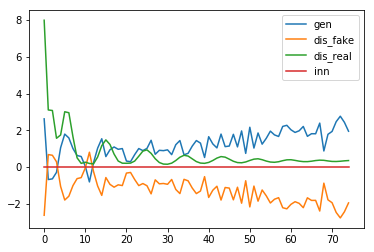

Pick prob : [0.22380115 0.0669788  0.1747494  0.21238687 0.13037872 0.11152478
 0.         0.08018027]
[4 0 0 5 2 1 0 7 2]
Generation 142  fitness : 1.3787035977146034
#################################
[0.48347731 0.62370499 0.1        0.18060462 0.22047444 0.19896244
 0.43892453 0.52507325]
population fitness : [-41.78232706 -44.85051902 -31.20380742 -35.15544995 -36.02780458
 -35.55712051 -40.80750893 -42.69244929]
mean fit : -38.50962334325634
population fitness : [-0.74787276 -1.44901083  1.66951278  0.76649007  0.56714106  0.67470099
 -0.52510895 -0.95585236]
tensor([-1.2322, -2.1405,  1.1071,  0.3805,  0.1075,  0.3059, -1.1563, -1.1563],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


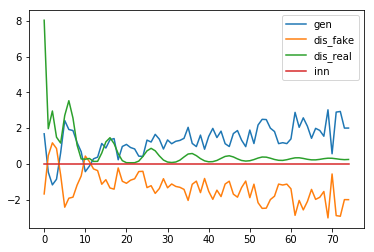

Pick prob : [0.0604842  0.         0.26902177 0.19112184 0.17392485 0.18320358
 0.07970108 0.04254268]
[2 4 2 5 5 2 3 2 3]
Generation 143  fitness : 1.6695127843549877
#################################
[0.51117765 0.24607829 0.1        0.4680073  0.44397438 0.70106434
 0.54063167 0.31596316]
population fitness : [-42.37718853 -35.90400523 -29.89527772 -41.32305691 -40.73622233
 -47.01383247 -43.09639519 -37.61045055]
mean fit : -39.744553615909744
population fitness : [-0.5390776   0.78641881  2.01680984 -0.32322589 -0.20306135 -1.48851076
 -0.68634762  0.43699457]
tensor([-0.9688,  0.2075,  1.6478, -1.0489, -0.8204, -1.7885, -0.6072, -0.6072],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


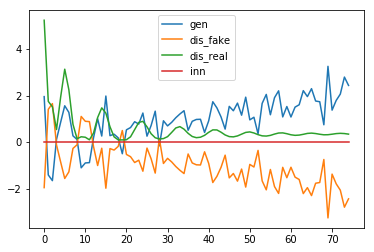

Pick prob : [0.07973012 0.19104074 0.29436474 0.0978566  0.10794761 0.
 0.06736289 0.1616973 ]
[2 4 6 2 3 3 2 2 7]
Generation 144  fitness : 2.016809842711991
#################################
[0.1        0.1        0.1        0.20580409 0.68081186 0.1066545
 0.17589833 0.19400602]
population fitness : [ -30.02524364  -34.55925685  -39.31455268  -54.68882711 -111.61380793
  -42.80673054  -51.10491836  -53.27494529]
mean fit : -52.1735353000695
population fitness : [ 0.9240768   0.73490752  0.53650583 -0.10494366 -2.47998255  0.39080427
  0.04458511 -0.04595331]
tensor([ 0.4110,  0.2628,  0.0328, -0.5276, -3.0916, -0.1430, -0.3363, -0.3363],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


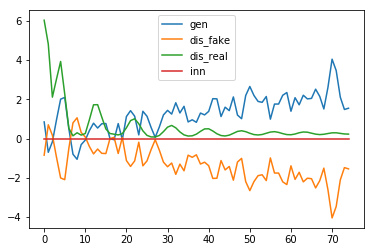

Pick prob : [0.17157678 0.16204197 0.15204181 0.11971046 0.         0.14469793
 0.12724725 0.12268379]
[3 2 6 1 5 1 5 2 0]
Generation 145  fitness : 0.9240767997409242
#################################
[0.13120999 0.1        0.1        0.1        0.21373928 0.65567926
 0.1        0.1       ]
population fitness : [ -50.05383537  -38.14668161  -32.26375015  -41.74052952  -61.24355699
 -121.16391863  -43.27481947  -36.03780238]
mean fit : -52.990611763939654
population fitness : [ 0.10830032  0.54740376  0.76435027  0.41487243 -0.30434617 -2.5140461
  0.35829199  0.62517349]
tensor([-0.1128, -0.0415,  0.5618,  0.2242, -0.9314, -3.1832, -0.1635, -0.1635],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


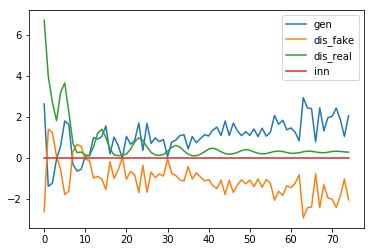

Pick prob : [0.13038476 0.15221727 0.16300399 0.14562773 0.10986771 0.
 0.14281451 0.15608403]
[6 2 7 1 7 0 7 4 0]
Generation 146  fitness : 0.7643502709536542
#################################
[0.1        0.1        0.1        0.1        0.1        0.1
 0.46218941 0.53908221]
population fitness : [ -42.93657096  -45.23103378  -44.10467461  -33.11419219  -46.56033194
  -32.28853809 -118.61852818 -132.98093976]
mean fit : -61.97935119009425
population fitness : [ 0.50975169  0.44833175  0.478483    0.77268462  0.41274808  0.79478636
 -1.51616075 -1.90062475]
tensor([-0.3355, -0.0226, -0.0776,  0.3740, -0.3226,  0.2660, -2.0375, -2.0375],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


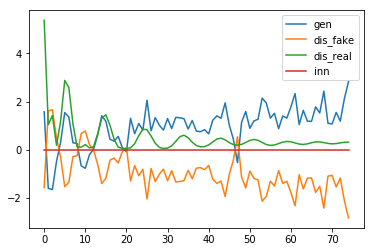

Pick prob : [0.15852527 0.15448581 0.1564688  0.1758178  0.15214555 0.17727139
 0.02528537 0.        ]
[0 5 3 3 1 3 0 2 3]
Generation 147  fitness : 0.7947863622887628
#################################
[0.60025911 0.40399851 0.37888981 0.1        0.53745858 0.1
 0.40342551 0.36671366]
population fitness : [-45.93203079 -39.42415021 -38.59156094 -26.02780797 -43.8496039
 -27.50120601 -39.40514994 -38.18780757]
mean fit : -37.36491466726031
population fitness : [-1.29180848 -0.31050565 -0.18496213  1.70948665 -0.97780589  1.48731759
 -0.30764066 -0.12408143]
tensor([-2.1056, -0.9337, -0.5137,  1.2978, -1.3797,  1.1894, -0.6995, -0.6995],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


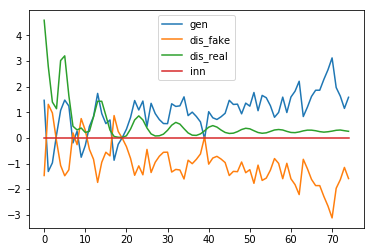

Pick prob : [0.         0.09495437 0.1071024  0.29041603 0.03038401 0.26891816
 0.09523159 0.11299344]
[7 3 3 5 5 1 2 5 1]
Generation 148  fitness : 1.7094866470832886
#################################
[0.64484867 0.15414838 0.1        0.3251789  0.1        0.1
 0.25821609 0.41133766]
population fitness : [-50.46906659 -39.53273618 -37.63726203 -43.3445259  -37.91856338
 -36.09720212 -41.85211306 -45.26476248]
mean fit : -41.5145289676699
population fitness : [-2.0088971   0.44460339  0.86984171 -0.4105489   0.80673343  1.21534496
 -0.07573498 -0.84134252]
tensor([-2.3858,  0.2516,  0.5481, -0.8425,  0.3060,  0.7399, -1.2168, -1.2168],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


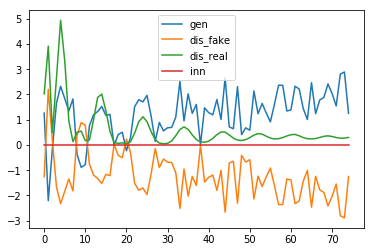

Pick prob : [0.         0.15266464 0.17912433 0.09945434 0.17519753 0.20062265
 0.12028753 0.07264898]
[1 4 7 5 5 6 6 5 5]
Generation 149  fitness : 1.2153449611926543
#################################
[0.2741981  0.35342239 0.67506711 0.36479463 0.20938728 0.51929643
 0.55025323 0.1       ]
population fitness : [-32.23204384 -34.74171186 -44.93077708 -35.10196189 -30.17896571
 -39.99627162 -40.9769216  -23.54599295]
mean fit : -35.21308081883397
population fitness : [ 0.4705214   0.07440001 -1.53382331  0.01753881  0.79457547 -0.75497004
 -0.90975403  1.8415117 ]
tensor([-0.0124, -0.3101, -2.0018, -0.5858,  0.2329, -1.3026,  0.0542,  0.0542],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


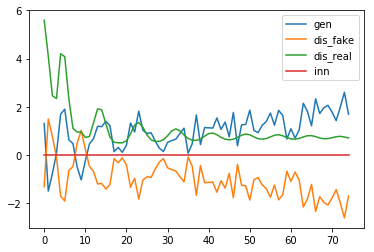

Pick prob : [0.16334547 0.13106328 0.         0.12642934 0.18975448 0.06347319
 0.05085896 0.27507528]
[4 0 7 7 4 1 4 5 7]
Generation 150  fitness : 1.8415117017691325
#################################
[0.1        0.20203726 0.32843196 0.62522557 0.1        0.49009044
 0.24422777 0.19919615]
population fitness : [-32.91831477 -35.81561401 -37.62816718 -41.88431252 -33.30686924
 -39.94641784 -36.42064376 -35.77487137]
mean fit : -36.711901337002075
population fitness : [ 1.32268857  0.31250348 -0.31946928 -1.80343563  1.18721347 -1.12776075
  0.10155115  0.32670899]
tensor([ 0.8974, -0.2179, -0.8330, -2.4247,  0.7678, -1.6911, -0.0585, -0.0585],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


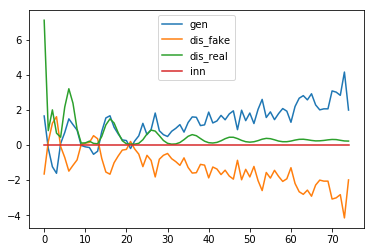

Pick prob : [0.21667839 0.14666029 0.1028569  0.         0.20728832 0.04683248
 0.13203873 0.1476449 ]
[7 2 7 7 0 2 1 4 1]
Generation 151  fitness : 1.3226885728744975
#################################
[0.22496442 0.17341625 0.67498487 0.17405303 0.1        0.14677337
 0.1        0.1       ]
population fitness : [ -53.22673357  -47.11889816 -106.54872245  -47.1943487   -37.72256905
  -43.96203798  -26.5711664   -26.60279172]
mean fit : -48.61840850424308
population fitness : [-0.19446392  0.06327693 -2.44456622  0.06009304  0.45978693  0.19649136
  0.93035821  0.92902368]
tensor([-0.7609, -0.2714, -2.9957, -0.3961, -0.1123, -0.3893,  0.5789,  0.5789],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


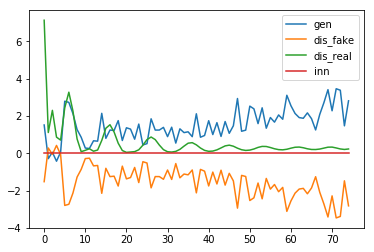

Pick prob : [0.11505632 0.12823559 0.         0.12807279 0.14851066 0.13504735
 0.17257277 0.17250453]
[0 0 6 1 7 1 5 5 7]
Generation 152  fitness : 0.9303582130410346
#################################
[0.57104038 0.44390863 0.1        0.28606864 0.1        0.48020113
 0.31937469 0.13347179]
population fitness : [-52.17522558 -47.88142382 -33.60838585 -42.55046885 -32.88866508
 -49.10718206 -43.67536167 -37.39659801]
mean fit : -42.41041386471271
population fitness : [-1.44559242 -0.80993375  1.30306097 -0.02073388  1.40960914 -0.99139621
 -0.18726413  0.74225028]
tensor([-1.7997, -1.4399,  1.0503, -0.5737,  0.8756, -1.4122, -0.3183, -0.3183],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


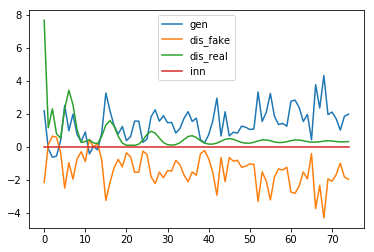

Pick prob : [0.         0.05496524 0.23767534 0.12320715 0.24688854 0.03927423
 0.10880732 0.18918219]
[3 4 4 3 4 4 3 4 2]
Generation 153  fitness : 1.4096091435377232
#################################
[0.1        0.64340247 0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -43.38104644 -134.2352308   -33.52035942  -35.2815056   -39.73628711
  -43.89865891  -42.88521633  -42.83612299]
mean fit : -51.971803451701554
population fitness : [ 0.27440408 -2.62764041  0.58937199  0.53311784  0.39082419  0.25787062
  0.29024178  0.29180991]
tensor([-0.2719, -2.9102,  0.2855, -0.0173,  0.0003, -0.1944, -0.2232, -0.2232],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


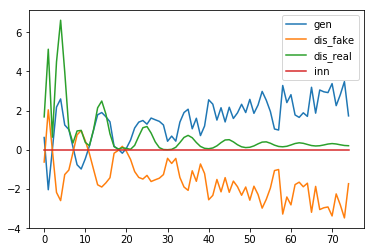

Pick prob : [0.13805373 0.         0.15303713 0.15036105 0.14359197 0.13726721
 0.13880715 0.13888175]
[4 4 2 2 0 2 6 2 6]
Generation 154  fitness : 0.5893719902627936
#################################
[0.1        0.11440677 0.10624346 0.47298335 0.53373294 0.47523215
 0.1        0.27339872]
population fitness : [-32.99947872 -34.81552573 -34.68594462 -40.50742624 -41.47174074
 -40.54312269 -33.91102592 -37.33930007]
mean fit : -37.034195588233615
population fitness : [ 1.27088804  0.69885474  0.73967125 -1.09402653 -1.39777418 -1.10527049
  0.98376147 -0.0961043 ]
tensor([ 0.5422,  0.0912,  0.2112, -1.8227, -1.7335, -1.8032,  0.2252,  0.2252],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


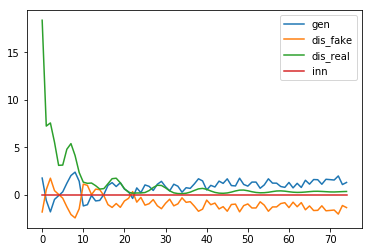

Pick prob : [0.23865284 0.18749711 0.19114724 0.02716351 0.         0.02615799
 0.21297572 0.1164056 ]
[0 0 0 6 1 6 6 7 6]
Generation 155  fitness : 1.2708880434472174
#################################
[0.1        0.1        0.1        0.1        0.1        0.1
 0.58009805 0.41391887]
population fitness : [ -30.79252532  -26.01595424  -38.09077705  -39.85050661  -42.26218386
  -40.67263164 -148.44324985 -113.37182153]
mean fit : -59.9374562641878
population fitness : [ 0.69048809  0.80365238  0.51758132  0.47589063  0.4187543   0.45641323
 -2.09683792 -1.26594202]
tensor([ 0.2869,  0.3321, -0.0887, -0.0985, -0.1579, -0.0330, -2.0987, -2.0987],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


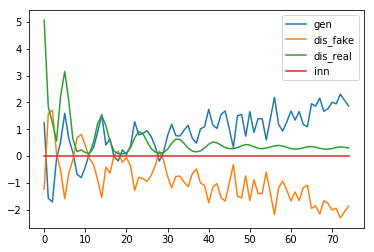

Pick prob : [0.16616246 0.17290859 0.15585487 0.15336954 0.14996344 0.15220842
 0.         0.04953267]
[3 5 3 0 3 1 3 5 4]
Generation 156  fitness : 0.8036523790491197
#################################
[0.50236872 0.3642534  0.16055024 0.69429119 0.31629936 0.1
 0.29688022 0.19171009]
population fitness : [-44.73916263 -41.92831529 -37.78265999 -48.6450638  -40.95238081
 -34.51522941 -40.55717311 -38.41680824]
mean fit : -40.942099159219495
population fitness : [-0.93287236 -0.24229613  0.77621917 -1.89248424 -0.00252602  1.57896995
  0.09456963  0.62041999]
tensor([-1.3040, -0.6674,  0.2737, -2.6229, -0.4615,  0.9204, -0.1473, -0.1473],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


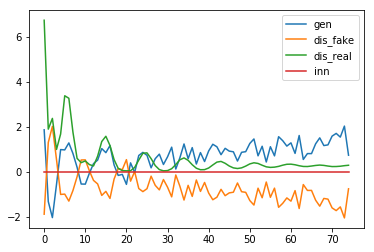

Pick prob : [0.06338308 0.10899616 0.17626986 0.         0.12483315 0.22929215
 0.13124639 0.1659792 ]
[5 7 6 1 7 1 7 7 7]
Generation 157  fitness : 1.5789699542780604
#################################
[0.1        0.50159721 0.1        0.1        0.1        0.1
 0.1        0.48728085]
population fitness : [ -47.15656368 -112.09146256  -35.77586245  -45.7029902   -36.38134427
  -42.08771981  -40.47418891 -109.91329757]
mean fit : -58.69792868165658
population fitness : [ 0.37928789 -1.75469027  0.75329583  0.42705718  0.73339767  0.54586707
  0.5988931  -1.68310848]
tensor([ 0.3346, -2.4838,  0.0883, -0.0930,  0.1534,  0.1499, -1.0949, -1.0949],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


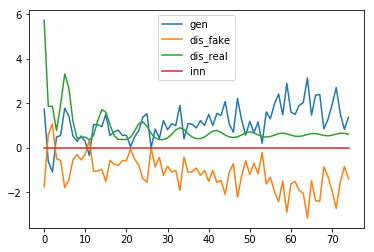

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[5 4 4 0 1 2 2 3 5]
Generation 158  fitness : 0.7532958328926344
#################################
[0.1        0.1        0.42022357 0.1        0.1        0.34299296
 0.36109692 0.51504853]
population fitness : [ -37.54084723  -42.26239608 -122.92591819  -35.66019615  -45.6007861
 -106.88782451 -110.64738263 -142.61774315]
mean fit : -80.51788675493506
population fitness : [ 1.03476857  0.9210867  -1.02106843  1.08004946  0.84070747 -0.63491537
 -0.72543516 -1.49519326]
tensor([ 0.3949,  0.4850, -1.4544,  0.5199,  0.3700, -1.0501, -1.5670, -1.5670],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


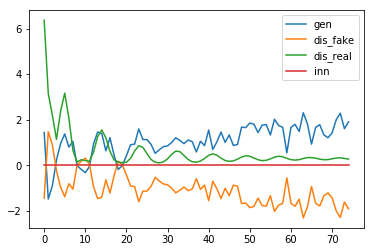

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[0 7 0 0 6 3 2 6 3]
Generation 159  fitness : 1.0800494613993892
#################################
[0.1       0.4750287 0.1       0.1       0.5087278 0.1       0.1
 0.1      ]
population fitness : [ -36.74561935 -138.10858169  -43.98886944  -39.87955785 -145.43341746
  -34.85636982  -48.8006455   -47.88187155]
mean fit : -66.96186658161442
population fitness : [ 0.69507396 -1.63661055  0.52845517  0.62298297 -1.80510608  0.73853297
  0.41776835  0.4389032 ]
tensor([ 0.1674, -2.3526,  0.0937,  0.1549, -2.4545,  0.1112, -0.0462, -0.0462],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


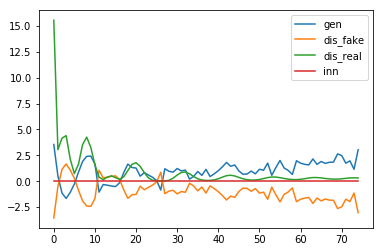

Pick prob : [0.17313249 0.01166798 0.16159447 0.16814033 0.         0.17614194
 0.15392963 0.15539317]
[7 3 3 2 7 3 0 7 2]
Generation 160  fitness : 0.7385329692085952
#################################
[0.1        0.17230544 0.452904   0.1        0.1        0.56714932
 0.1        0.1       ]
population fitness : [ -48.67134198  -63.94289812 -109.828449    -46.90456415  -47.11954795
 -128.51068959  -37.70938993  -35.76623724]
mean fit : -64.80663974478517
population fitness : [ 0.49335152  0.02640969 -1.37658309  0.54737237  0.54079905 -1.94780972
  0.82852325  0.88793693]
tensor([-0.2642, -0.5718, -1.9559,  0.1253, -0.1253, -2.3777,  0.4453,  0.4453],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


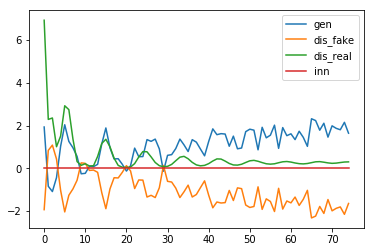

Pick prob : [0.15666066 0.12669483 0.03665827 0.16012743 0.15970559 0.
 0.17817019 0.18198304]
[6 0 7 1 2 7 0 0 0]
Generation 161  fitness : 0.8879369288374969
#################################
[0.4432602  0.1        0.1        0.43865314 0.45622537 0.1
 0.1        0.1       ]
population fitness : [-125.05487611  -40.36677537  -40.65663498 -124.08839482 -127.77474899
  -44.11508812  -38.9890301   -32.0664146 ]
mean fit : -71.63899538581816
population fitness : [-1.27312216  0.74534681  0.73843825 -1.2500869  -1.33794802  0.65600896
  0.7781842   0.94317886]
tensor([-1.8503,  0.3295,  0.1544, -2.0367, -2.0005,  0.1150,  0.5562,  0.5562],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


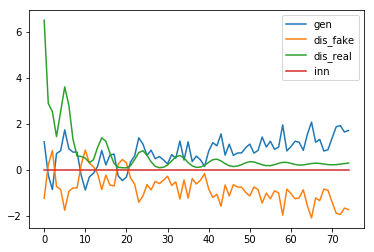

Pick prob : [0.00605646 0.19463525 0.19398981 0.00820857 0.         0.18628872
 0.19770314 0.21311804]
[5 7 2 5 1 7 7 1 1]
Generation 162  fitness : 0.9431788612455976
#################################
[0.1        0.30938112 0.1728216  0.52015198 0.49425374 0.57009437
 0.57375033 0.53349654]
population fitness : [-32.85171054 -39.1682192  -36.38013902 -43.47144231 -42.94268848
 -44.49109592 -44.56573801 -43.74389285]
mean fit : -40.9518657906083
population fitness : [ 1.98371755  0.43681274  1.11960998 -0.61704103 -0.4875499  -0.86675288
 -0.88503263 -0.68376382]
tensor([ 1.2141, -0.0110,  0.5572, -1.3247, -0.8354, -1.2032, -1.2132, -1.2132],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


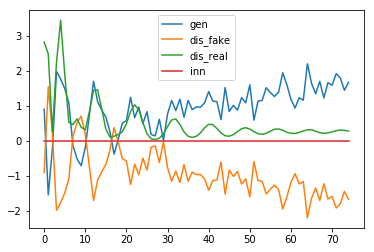

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[1 3 6 0 0 4 7 6 4]
Generation 163  fitness : 1.9837175484529332
#################################
[0.1        0.36456008 0.39511301 0.48789977 0.47826136 0.1
 0.1        0.1       ]
population fitness : [ -38.8344631  -106.70031949 -113.29478761 -133.32165094 -131.24132144
  -28.01458153  -39.90636943  -39.71833634]
mean fit : -78.87897873564832
population fitness : [ 0.92765425 -0.64449737 -0.79726202 -1.26119584 -1.21300381  1.17830304
  0.90282293  0.90717882]
tensor([ 0.4010, -1.3053, -1.4184, -1.6954, -1.7972,  0.8654,  0.3484,  0.3484],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


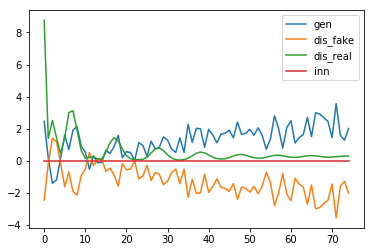

Pick prob : [0.21694193 0.06112239 0.04598154 0.         0.00477642 0.24178431
 0.21448084 0.21491256]
[5 7 0 2 0 6 5 7 7]
Generation 164  fitness : 1.1783030383157027
#################################
[0.1        0.1        0.1        0.1        0.1        0.1
 0.50049032 0.49803916]
population fitness : [ -44.39065338  -35.08654222  -45.89956283  -33.46284721  -46.01262437
  -40.15117355 -123.93262879 -123.48955099]
mean fit : -61.553197916807875
population fitness : [ 0.47472689  0.73208452  0.4329895   0.77699696  0.42986214  0.5919936
 -1.72545471 -1.7131989 ]
tensor([-0.1033,  0.2522, -0.0290,  0.2421, -0.2441,  0.0389, -2.1275, -2.1275],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


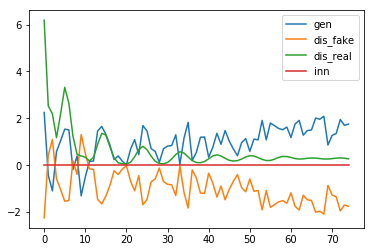

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[1 3 0 6 7 6 4 2 5]
Generation 165  fitness : 0.7769969568453807
#################################
[0.64881189 0.4354392  0.1        0.44315742 0.58368767 0.55383576
 0.67662025 0.53538652]
population fitness : [-134.43815832 -104.9917242   -44.89906705 -106.05687397 -125.45070861
 -121.33100589 -138.27584156 -118.7849238 ]
mean fit : -111.77853792447573
population fitness : [-0.82097279  0.24589068  2.42308674  0.20729961 -0.49535164 -0.34609213
 -0.96001455 -0.25384592]
tensor([-1.2038, -0.1422,  2.0989, -0.5876, -0.8960, -1.1142, -0.9807, -0.9807],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


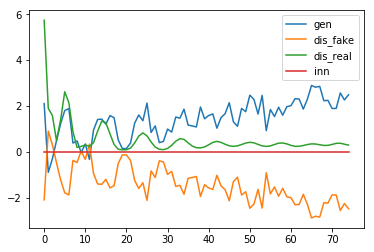

Pick prob : [0.01810412 0.15701653 0.4405013  0.15199173 0.06050207 0.0799366
 0.         0.09194765]
[2 7 3 2 7 1 3 3 2]
Generation 166  fitness : 2.423086743564534
#################################
[0.35471674 0.1        0.1        0.38276565 0.1        0.3726762
 0.1        0.51034909]
population fitness : [-111.42290993  -47.13575159  -44.16996171 -116.7408757   -47.22652575
 -114.82795369  -49.50559038 -140.93021198]
mean fit : -83.99497259100403
population fitness : [-0.72332508  0.97204535  1.05025868 -0.8635696   0.96965147 -0.81312234
  0.90954835 -1.50148682]
tensor([-1.3008,  0.6365,  0.5778, -1.4386,  0.5471, -1.1738, -0.6828, -0.6828],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


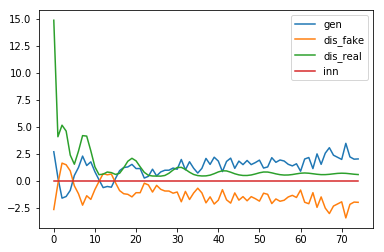

Pick prob : [0.0647826  0.20592357 0.21243489 0.05310713 0.20572427 0.0573069
 0.20072064 0.        ]
[1 0 0 4 0 2 2 6 1]
Generation 167  fitness : 1.0502586754007042
#################################
[0.1        0.1        0.1        0.49290644 0.42933159 0.40189393
 0.1        0.1       ]
population fitness : [ -54.63874508  -46.86949541  -45.72339341 -131.12413554 -119.3860421
 -114.32011094  -40.11673114  -43.94135912]
mean fit : -74.5150015901832
population fitness : [ 0.53826032  0.74865602  0.77969311 -1.53300752 -1.21513328 -1.07794498
  0.93152471  0.82795161]
tensor([ 0.2706,  0.3716,  0.3641, -1.8546, -1.9187, -1.6724,  0.2252,  0.2252],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


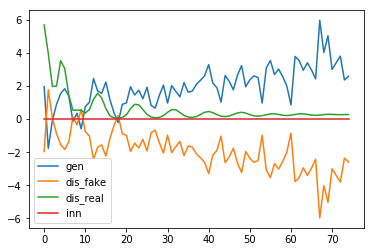

Pick prob : [0.16888924 0.18604471 0.18857545 0.         0.02591917 0.03710537
 0.20095565 0.1925104 ]
[2 2 1 0 2 7 1 6 0]
Generation 168  fitness : 0.931524713364692
#################################
[0.44358798 0.1        0.62160973 0.53498971 0.41746638 0.36554216
 0.57891632 0.68723215]
population fitness : [-116.61957188  -44.52613053 -145.55227743 -131.47449353 -112.37419846
 -103.93529682 -138.61359734 -156.21745765]
mean fit : -118.66412795489845
population fitness : [ 0.06290035  2.28084032 -0.82720842 -0.39410827  0.19350839  0.45312948
 -0.61374134 -1.1553205 ]
tensor([-0.2172,  1.8724, -1.3792, -0.8794, -0.5146, -0.0085, -1.2221, -1.2221],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


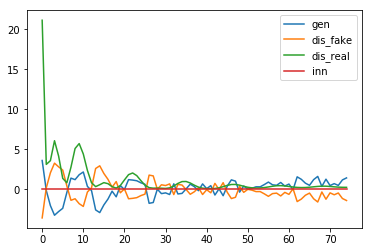

Pick prob : [0.13180551 0.37177571 0.03550012 0.08235942 0.14593666 0.17402638
 0.0585962  0.        ]
[1 0 5 1 1 4 1 4 5]
Generation 169  fitness : 2.2808403159450332
#################################
[0.42413752 0.42191249 0.46566422 0.61093556 0.1        0.1
 0.44737363 0.43950327]
population fitness : [-105.12640347 -104.78666936 -111.46698893 -133.64803021  -48.42001502
  -40.36612782 -108.67425408 -107.47255354]
mean fit : -94.99513030315234
population fitness : [-0.33176613 -0.32064095 -0.53939961 -1.26575631  1.52518301  1.78892153
 -0.44794666 -0.40859489]
tensor([-0.8738, -0.8018, -0.9715, -1.7091,  0.8849,  1.1410, -0.9013, -0.9013],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


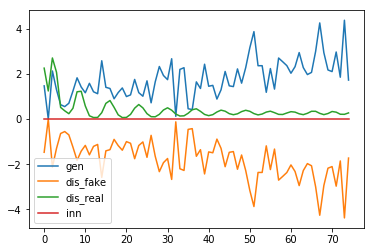

Pick prob : [0.09223637 0.09333504 0.07173149 0.         0.27561973 0.30166528
 0.08076294 0.08464914]
[4 4 4 7 7 5 5 5 5]
Generation 170  fitness : 1.7889215272275467
#################################
[0.1        0.1        0.41366273 0.1        0.1        0.1
 0.41365923 0.45757341]
population fitness : [ -46.13415087  -45.11973122 -114.85205555  -50.45824129  -42.37040697
  -42.5953028  -114.85144357 -122.5460507 ]
mean fit : -72.36592287079185
population fitness : [ 0.74854165  0.77748881 -1.212371    0.62515075  0.85594267  0.84952511
 -1.21235354 -1.43192444]
tensor([ 0.2611,  0.1352, -1.5972,  0.0109,  0.2105,  0.0043, -1.5755, -1.5755],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


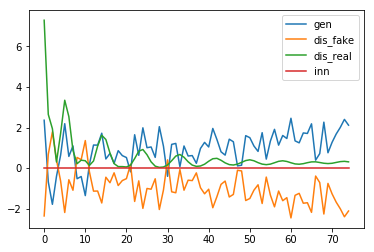

Pick prob : [0.19034402 0.19287097 0.01916594 0.1795726  0.19971961 0.19915939
 0.01916747 0.        ]
[0 0 4 0 3 3 0 1 0]
Generation 171  fitness : 0.8559426666124413
#################################
[0.4357049  0.1        0.45663011 0.1        0.1        0.1
 0.429774   0.42982392]
population fitness : [-127.88062597  -43.60582679 -132.28151666  -36.24525045  -49.07874375
  -49.64768938 -126.63326842 -126.64376729]
mean fit : -86.50208608801226
population fitness : [-0.98372668  1.0198087  -1.08835274  1.19479785  0.88969646  0.87617044
 -0.95407221 -0.95432181]
tensor([-1.5326,  0.1914, -1.6303,  0.6223,  0.5847,  0.5804, -1.4956, -1.4956],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


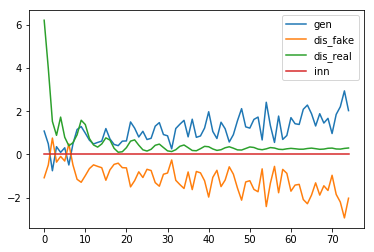

Pick prob : [0.01201656 0.24212755 0.         0.26222548 0.22718384 0.22563034
 0.01542245 0.01539378]
[4 1 4 1 1 5 3 3 1]
Generation 172  fitness : 1.194797845617402
#################################
[0.4328345  0.44054789 0.11031664 0.1        0.1        0.1
 0.46763759 0.46489077]
population fitness : [-116.71566195 -118.25848007  -52.2062171   -30.14088095  -37.18615878
  -46.25635529 -123.67691302 -123.12749934]
mean fit : -80.94602081273256
population fitness : [-0.89415964 -0.93272658  0.7184297   1.2700129   1.09389698  0.86716271
 -1.06817508 -1.05444098]
tensor([-1.5482, -1.4312,  0.1937,  0.8002,  0.5861,  0.2831, -1.4900, -1.4900],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


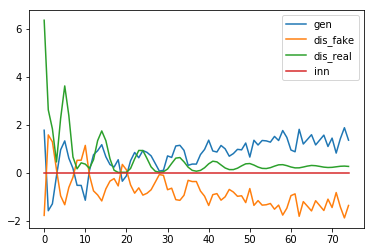

Pick prob : [0.02036364 0.01585046 0.20907209 0.27361947 0.25301003 0.22647713
 0.         0.00160719]
[5 2 4 2 0 5 5 2 3]
Generation 173  fitness : 1.2700128962417787
#################################
[0.1        0.1        0.44463772 0.57045059 0.1        0.1
 0.1        0.1       ]
population fitness : [ -50.49696998  -54.59415005 -112.84973931 -133.01990635  -41.56595903
  -48.19340112  -54.90067777  -52.53949863]
mean fit : -68.52003777959033
population fitness : [ 0.56210093  0.43431865 -1.38254857 -2.01161294  0.84064006  0.63394432
  0.42475871  0.49839883]
tensor([-0.0995, -0.0733, -1.8894, -2.4017,  0.2926,  0.1525, -0.0289, -0.0289],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


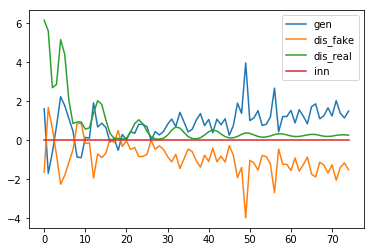

Pick prob : [0.1599285  0.15198821 0.03908955 0.         0.17723669 0.16439279
 0.15139416 0.1559701 ]
[6 7 4 7 7 7 5 7 5]
Generation 174  fitness : 0.840640063327806
#################################
[0.45347434 0.1        0.38810984 0.1        0.44881209 0.1
 0.1        0.1       ]
population fitness : [-118.08996632  -39.75156856 -106.55987236  -38.09850259 -117.26755971
  -39.46076585  -44.49289977  -46.11336301]
mean fit : -68.72931227091027
population fitness : [-1.39913619  0.82137911 -1.0723137   0.86823554 -1.37582493  0.82962196
  0.68698526  0.64105295]
tensor([-1.7108,  0.1518, -1.7910,  0.4446, -1.8115,  0.3076,  0.1647,  0.1647],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


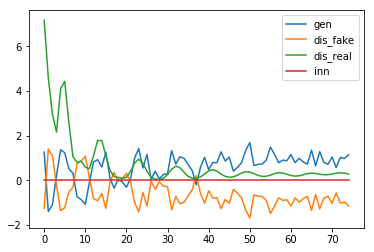

Pick prob : [0.         0.1983827  0.02919859 0.20256889 0.00208265 0.19911912
 0.18637584 0.18227221]
[5 5 7 1 6 1 3 6 3]
Generation 175  fitness : 0.8682355449051292
#################################
[0.1        0.50113658 0.1        0.1        0.50783313 0.1
 0.13459998 0.19376993]
population fitness : [ -41.40072072 -115.58878192  -39.73450126  -40.82254834 -116.60240267
  -47.56184704  -60.10815755  -69.06438736]
mean fit : -66.36041835670714
population fitness : [ 0.8244899  -1.62615305  0.87952987  0.84358858 -1.65963583  0.62097035
  0.20652998 -0.0893198 ]
tensor([ 0.3818, -2.1885,  0.4734,  0.4939, -2.1581,  0.1703, -0.4203, -0.4203],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


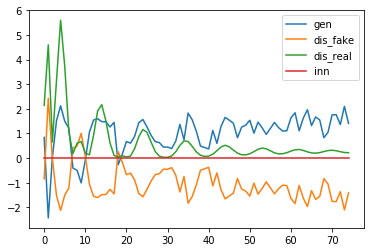

Pick prob : [0.18709871 0.00252185 0.19124419 0.18853718 0.         0.17177008
 0.14055537 0.11827264]
[6 5 3 2 6 2 0 6 3]
Generation 176  fitness : 0.8795298741628225
#################################
[0.1        0.1        0.10305691 0.1        0.1        0.1
 0.63478447 0.17844228]
population fitness : [ -47.85543076  -38.10451109  -52.97932656  -39.2856756   -42.30562651
  -38.41973071 -129.72672473  -63.86014512]
mean fit : -56.56714638240775
population fitness : [ 0.30178609  0.63957167  0.12428713  0.59865447  0.49403912  0.62865202
 -2.53435074 -0.25263974]
tensor([-0.4719, -0.0554, -0.3911,  0.1239, -0.1385,  0.2287, -1.7271, -1.7271],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


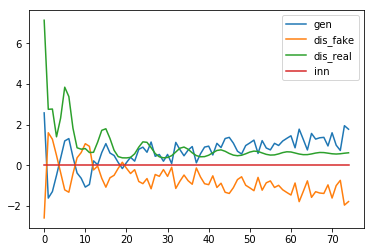

Pick prob : [0.13988478 0.15654514 0.13113013 0.15452701 0.14936714 0.15600656
 0.         0.11253923]
[1 2 7 4 5 7 3 1 4]
Generation 177  fitness : 0.6395716673255021
#################################
[0.1        0.1        0.1        0.1        0.50705977 0.1
 0.38960268 0.4032066 ]
population fitness : [ -50.52969569  -42.88550161  -59.64698815  -44.53024024 -145.72026094
  -45.69617693 -121.89926095 -124.65821736]
mean fit : -79.44579273373161
population fitness : [ 0.71290047  0.90136123  0.48812179  0.86081167 -1.63393764  0.83206654
 -1.04665223 -1.11467183]
tensor([ 0.0787,  0.3217,  0.1997,  0.3793, -2.1272,  0.5334, -1.5201, -1.5201],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


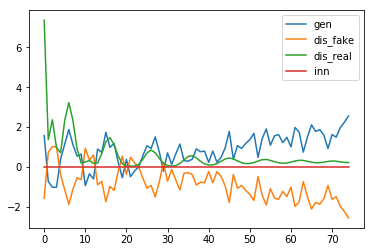

Pick prob : [0.17953853 0.19395621 0.16234244 0.19085408 0.         0.18865501
 0.04492869 0.03972503]
[3 6 2 6 5 3 0 5 7]
Generation 178  fitness : 0.9013612264522293
#################################
[0.1        0.36010953 0.1183872  0.1        0.1        0.1
 0.4925611  0.50167501]
population fitness : [ -56.0731452  -107.71084837  -63.29817235  -42.20500672  -41.54638756
  -53.67212175 -132.04674024 -133.7212777 ]
mean fit : -78.78421248747702
population fitness : [ 0.61804115 -0.78718676  0.42142494  0.99543779  1.01336093  0.68338072
 -1.44944461 -1.49501416]
tensor([ 0.2282, -1.3759, -0.0243,  0.4381,  0.5038,  0.2706, -1.9685, -1.9685],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


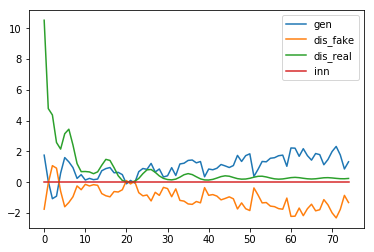

Pick prob : [0.17667519 0.05918233 0.16023587 0.2082298  0.20972837 0.18213832
 0.00381013 0.        ]
[4 1 3 3 1 4 0 5 5]
Generation 179  fitness : 1.0133609323563255
#################################
[0.47690622 0.1        0.44651894 0.1        0.1        0.47386681
 0.1        0.1       ]
population fitness : [-122.92868991  -39.68667135 -116.85639784  -41.41610084  -43.29738921
 -122.32132513  -27.62848825  -41.68678258]
mean fit : -69.47773063833037
population fitness : [-1.33741036  0.74540985 -1.18547396  0.70213734  0.65506514 -1.32221333
  1.04712078  0.69536454]
tensor([-1.7676,  0.0878, -1.7270,  0.1107,  0.1516, -1.7112,  0.2820,  0.2820],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


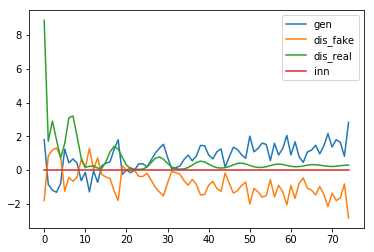

Pick prob : [0.         0.19466914 0.01420062 0.19062471 0.18622514 0.00142038
 0.22286831 0.1899917 ]
[1 6 7 6 4 6 7 3 3]
Generation 180  fitness : 1.047120784019625
#################################
[0.38474035 0.1        0.1        0.1        0.40107348 0.1
 0.1        0.50155861]
population fitness : [-108.72850078  -40.07516037  -39.14482863  -34.1314778  -111.89531795
  -38.45914143  -39.80041589 -131.37830696]
mean fit : -67.9516437260277
population fitness : [-1.05155018  0.71887642  0.74286774  0.87215161 -1.1332158   0.76055019
  0.72596151 -1.63564149]
tensor([-1.9672,  0.4389,  0.2438,  0.5315, -2.0343,  0.5861, -0.8591, -0.8591],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


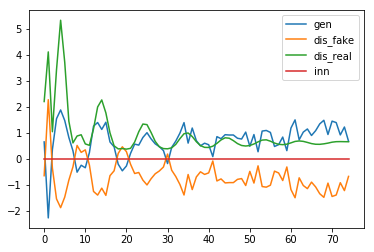

Pick prob : [0.04463779 0.17993842 0.1817719  0.19165211 0.03839669 0.18312323
 0.18047988 0.        ]
[2 1 6 3 3 3 2 6 1]
Generation 181  fitness : 0.8721516139168184
#################################
[0.51395863 0.1        0.1        0.1        0.1        0.1
 0.47559128 0.1       ]
population fitness : [-140.648216    -45.67123973  -39.82506251  -32.05219101  -43.72955617
  -41.30339602 -132.48053556  -31.23615886]
mean fit : -63.36829448386671
population fitness : [-1.81509625  0.41565593  0.55296682  0.73553054  0.46126082  0.51824476
 -1.62325954  0.75469692]
tensor([-2.5393, -0.1950,  0.0143,  0.3268, -0.2226, -0.0219, -0.8210, -0.8210],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


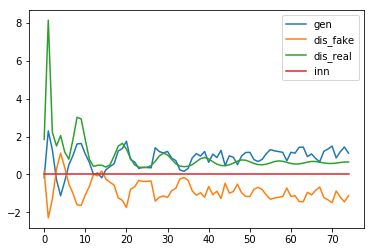

Pick prob : [0.         0.15362492 0.16308109 0.17565369 0.15676559 0.1606899
 0.01321119 0.17697362]
[4 2 2 7 5 4 2 5 3]
Generation 182  fitness : 0.7546969228583621
#################################
[0.1        0.48559654 0.1        0.1        0.1        0.53043665
 0.1        0.1       ]
population fitness : [ -43.45936131 -127.13383119  -46.8085075   -33.44114557  -42.21987852
 -135.78543922  -45.82489615  -45.92010831]
mean fit : -65.07414597007613
population fitness : [ 0.56013256 -1.60823487  0.4733417   0.81974786  0.59225292 -1.83243545
  0.49883132  0.49636396]
tensor([ 0.2106, -2.3339, -0.1199,  0.3493,  0.2345, -2.3086, -0.1450, -0.1450],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


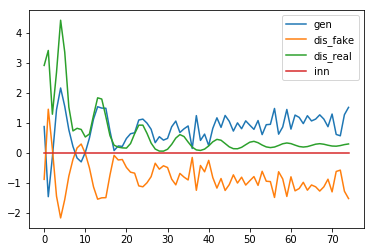

Pick prob : [0.16320957 0.01529389 0.15728911 0.18091929 0.16540067 0.
 0.15902789 0.15885958]
[4 6 0 2 7 2 6 6 3]
Generation 183  fitness : 0.8197478608682974
#################################
[0.1        0.1        0.1        0.66600999 0.1        0.1
 0.11078634 0.1       ]
population fitness : [ -47.18956057  -40.71776179  -46.44768771 -129.89959483  -33.96962503
  -46.08975719  -49.92693852  -42.98352181]
mean fit : -54.65305593140564
population fitness : [ 0.25908288  0.48374066  0.28483577 -2.61205898  0.71799105  0.29726073
  0.16405934  0.40508855]
tensor([-0.2381, -0.1670, -0.2684, -3.0239,  0.4428, -0.2980, -0.0487, -0.0487],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


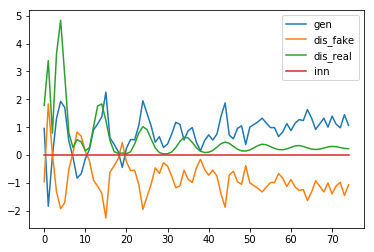

Pick prob : [0.1373984  0.14814939 0.13863081 0.         0.15935944 0.1392254
 0.13285105 0.1443855 ]
[2 6 1 6 0 1 7 6 5]
Generation 184  fitness : 0.717991048206038
#################################
[0.61044892 0.37048183 0.1        0.2157995  0.45703753 0.22625225
 0.1        0.1       ]
population fitness : [-50.62662092 -44.85454002 -38.27185064 -41.13386773 -46.93651919
 -41.38529454 -36.85263667 -35.94310552]
mean fit : -42.00055440469869
population fitness : [-1.79308944 -0.59325435  0.77508089  0.18015705 -1.0260327   0.12789328
  1.07009109  1.25915417]
tensor([-2.3229, -1.0557,  0.3188, -0.3615, -1.4546, -0.2801,  0.5280,  0.5280],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


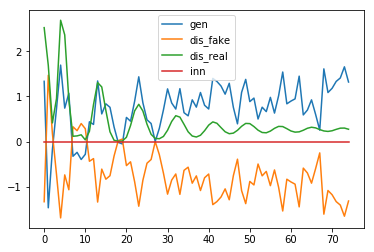

Pick prob : [0.         0.083643   0.1790325  0.13755912 0.05347312 0.13391571
 0.19959828 0.21277826]
[6 7 5 6 5 5 5 1 1]
Generation 185  fitness : 1.2591541688405605
#################################
[0.66012122 0.1        0.1        0.1        0.1        0.10623878
 0.1        0.1       ]
population fitness : [-135.68825538  -32.74562002  -44.05791724  -36.54574     -44.44095269
  -49.31303153  -45.60647401  -45.60214771]
mean fit : -54.25001732290642
population fitness : [-2.61111976  0.68948639  0.32678499  0.56764475  0.31450389  0.15829249
  0.27713427  0.27727298]
tensor([-3.0908,  0.2114, -0.2376,  0.0733, -0.0879, -0.2008, -0.2114, -0.2114],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


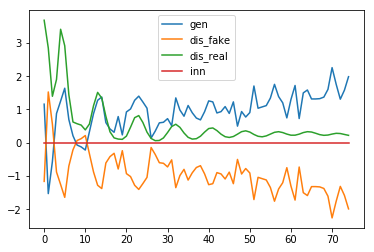

Pick prob : [0.         0.15800722 0.14064391 0.15217439 0.14005599 0.13257781
 0.13826702 0.13827366]
[5 5 4 3 1 2 2 5 1]
Generation 186  fitness : 0.6894863896387572
#################################
[0.1        0.66390451 0.1        0.10359171 0.1        0.1
 0.1        0.1       ]
population fitness : [ -36.25938287 -134.84845989  -42.96726315  -45.88308673  -43.27747915
  -41.02892358  -40.53386649  -29.43499652]
mean fit : -51.77918229586747
population fitness : [ 0.48872623 -2.61589303  0.27749173  0.18567099  0.26772288  0.33853101
  0.35412061  0.70362957]
tensor([ 0.0428, -3.1492, -0.1837, -0.5332, -0.3957, -0.1728,  0.0908,  0.0908],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


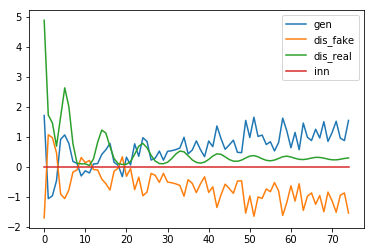

Pick prob : [0.1483537  0.         0.13825989 0.13387226 0.13779309 0.14117665
 0.14192159 0.15862282]
[5 7 6 6 0 7 2 5 0]
Generation 187  fitness : 0.7036295665548384
#################################
[0.55272509 0.34834367 0.49422353 0.1        0.30076282 0.26115814
 0.54485318 0.1       ]
population fitness : [-50.17884292 -42.9191918  -48.10086083 -30.54598528 -41.22911444
 -39.82235194 -49.89923162 -31.99684648]
mean fit : -41.83655316334097
population fitness : [-1.17430495 -0.15239796 -0.88179717  1.58932022  0.0855063   0.28352965
 -1.13494538  1.3850893 ]
tensor([-1.6930, -0.7576, -1.5112,  0.9671, -0.4599, -0.2076, -0.2862, -0.2862],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


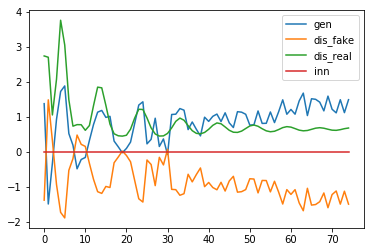

Pick prob : [0.         0.10877786 0.03113627 0.29417669 0.1341018  0.15518058
 0.00418967 0.27243714]
[5 1 7 5 1 3 4 2 3]
Generation 188  fitness : 1.5893202170816356
#################################
[0.13454339 0.1        0.33852985 0.62816712 0.49339133 0.14702739
 0.14452778 0.13850595]
population fitness : [-35.93549747 -29.87929564 -45.1175405  -58.15498392 -52.08832092
 -36.4974398  -36.38492511 -36.11386447]
mean fit : -41.27148347947838
population fitness : [ 0.59271605  1.26543295 -0.42721621 -1.87540252 -1.2015236   0.53029605
  0.54279407  0.57290322]
tensor([ 0.1140,  0.6531, -0.9113, -2.3349, -1.6847,  0.1076,  0.1605,  0.1605],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


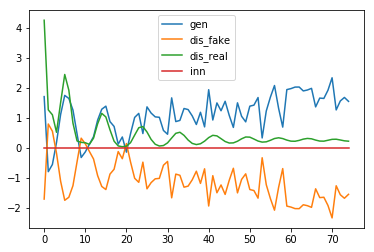

Pick prob : [0.16450592 0.20934409 0.09652503 0.         0.04491562 0.16034548
 0.1611785  0.16318535]
[7 1 1 4 1 6 0 7 7]
Generation 189  fitness : 1.265432952717604
#################################
[0.20418189 0.46941662 0.17890748 0.1        0.59150252 0.41816139
 0.21426158 0.1       ]
population fitness : [-38.72572074 -44.324432   -38.1922154  -34.41574431 -46.90148403
 -43.24251013 -38.93848801 -34.65394509]
mean fit : -39.92431746405206
population fitness : [ 0.28391296 -1.04226009  0.41028497  1.30482193 -1.65268931 -0.78598404
  0.23351453  1.24839905]
tensor([-0.1712, -1.7241, -0.2551,  0.8029, -2.1728, -1.1965,  0.2871,  0.2871],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


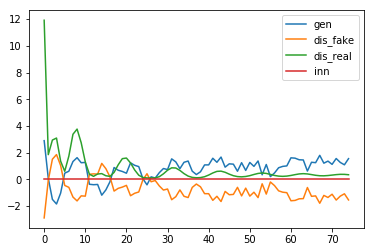

Pick prob : [0.14647356 0.04616939 0.15603162 0.22368929 0.         0.06555265
 0.14266171 0.21942179]
[5 0 3 2 3 6 6 6 7]
Generation 190  fitness : 1.3048219333292956
#################################
[0.44278613 0.144187   0.51610504 0.61142692 0.36564493 0.37680915
 0.11281006 0.1       ]
population fitness : [-48.35722212 -23.61356096 -54.43285344 -62.3317794  -41.96485346
 -42.88998615 -21.0134852  -11.66538755]
mean fit : -38.28364103533288
population fitness : [-0.60782488  0.88517079 -0.97441943 -1.45102886 -0.22211888 -0.27794001
  1.04205549  1.60610578]
tensor([-1.2570,  0.4063, -1.5945, -1.8971, -0.6902, -0.6688,  0.8007,  0.8007],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


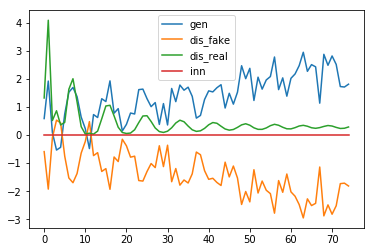

Pick prob : [0.07263846 0.20125372 0.04105789 0.         0.1058654  0.10105664
 0.21476867 0.26335922]
[1 4 1 5 7 5 6 4 1]
Generation 191  fitness : 1.6061057822626663
#################################
[0.1        0.1        0.1        0.1        0.64536657 0.1
 0.1        0.1       ]
population fitness : [ -43.2465695   -42.57494399  -37.40461097  -40.5225471  -122.77400151
  -33.08746416  -39.50492944  -38.18854945]
mean fit : -49.6629520144112
population fitness : [ 0.2308551   0.25501952  0.44104299  0.32886273 -2.63046326  0.59636966
  0.36547561  0.41283766]
tensor([-0.3440, -0.1051, -0.1012,  0.0178, -3.1133,  0.2100, -0.1652, -0.1652],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


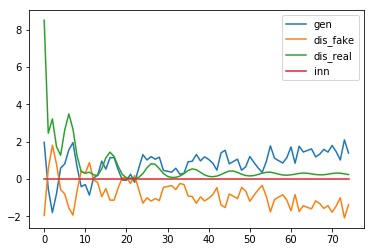

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[7 3 7 4 2 4 4 1 5]
Generation 192  fitness : 0.5963696615552747
#################################
[0.53894998 0.1        0.17702459 0.57599354 0.1        0.11627104
 0.14083751 0.13554534]
population fitness : [-108.04784476  -31.51304332  -46.48353997 -114.3490357   -16.37126745
  -36.14922695  -40.32803818  -39.42782892]
mean fit : -54.0837281561897
population fitness : [-1.58622632  0.66344483  0.22340065 -1.77144412  1.10852362  0.52716842
  0.40433604  0.43079688]
tensor([-2.2968,  0.1132, -0.1320, -2.2526,  0.6109, -0.0754,  0.0497,  0.0497],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


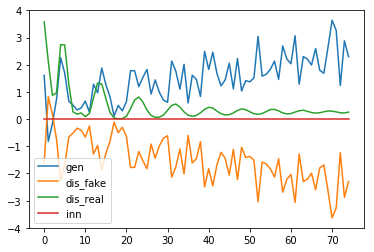

Pick prob : [0.01306969 0.17181525 0.14076402 0.         0.20322175 0.16219906
 0.15353153 0.15539871]
[5 7 1 2 5 1 1 1 2]
Generation 193  fitness : 1.108523616703561
#################################
[0.23988851 0.1        0.20067751 0.16456935 0.72942624 0.19398445
 0.1692855  0.14367755]
population fitness : [ -48.67369699   -8.31591694  -42.07701116  -36.00233467 -131.03135443
  -40.95100153  -36.79575962  -32.48759037]
mean fit : -47.04183321317702
population fitness : [-0.04849937  1.15094321  0.14755566  0.32809646 -2.49618805  0.18102093
  0.30451568  0.43255547]
tensor([-0.4887,  0.6300, -0.3910, -0.1525, -3.0732, -0.5308, -0.1986, -0.1986],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


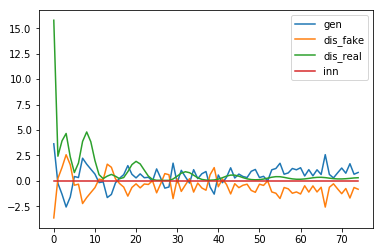

Pick prob : [0.12257133 0.18263504 0.13238905 0.14142987 0.         0.13406487
 0.14024904 0.1466608 ]
[5 1 1 6 2 5 7 5 0]
Generation 194  fitness : 1.1509432133167443
#################################
[0.1        0.4473137  0.42211817 0.4228985  0.1        0.1
 0.1        0.1       ]
population fitness : [ -29.19447599 -140.21180436 -133.95860838 -134.15227758  -41.55101025
  -32.36611888  -32.17135385  -34.05228512]
mean fit : -72.2072418020293
population fitness : [ 0.86654038 -1.37002813 -1.24405049 -1.24795218  0.61760414  0.80264408
  0.80656784  0.76867437]
tensor([ 0.5011, -1.8446, -1.9125, -1.7517, -0.0657,  0.4155,  0.3882,  0.3882],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


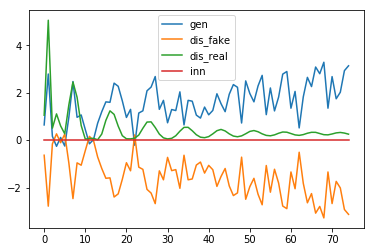

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 3 7 5 2 3 4 3 1]
Generation 195  fitness : 0.8665403768511988
#################################
[0.50708027 0.1        0.1        0.1        0.1        0.46873511
 0.1        0.1       ]
population fitness : [-139.84475755  -39.63386353  -37.61175611  -37.85443067  -40.57172978
 -131.53254023  -30.61225485  -29.92314435]
mean fit : -60.94805963342888
population fitness : [-1.81979495  0.49162344  0.53826444  0.53266702  0.46999105 -1.62806917
  0.69971172  0.71560643]
tensor([-2.4499, -0.1346,  0.0153, -0.0266,  0.0702, -2.0301,  0.1866,  0.1866],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


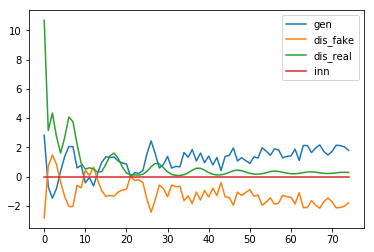

Pick prob : [0.         0.15876915 0.16197288 0.1615884  0.15728324 0.01316946
 0.17306254 0.17415433]
[1 4 7 1 7 6 7 4 1]
Generation 196  fitness : 0.7156064272407219
#################################
[0.1        0.64413564 0.10036931 0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -45.82411395 -142.46988806  -46.09842823  -35.04157726  -28.31002059
  -33.7549459   -40.16558888  -29.6688902 ]
mean fit : -50.16668163327301
population fitness : [ 0.12251252 -2.60405813  0.11477357  0.42670946  0.61662014  0.4630079
  0.28215084  0.57828371]
tensor([-0.4577, -3.2641, -0.3133, -0.0450,  0.2497,  0.0205, -0.0046, -0.0046],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


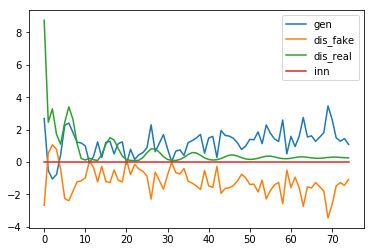

Pick prob : [0.13088085 0.         0.13050936 0.14548291 0.154599   0.14722531
 0.1385438  0.15275877]
[5 3 7 3 2 5 3 5 2]
Generation 197  fitness : 0.6166201378850027
#################################
[0.1        0.2236197  0.65666771 0.30893917 0.12077624 0.12929787
 0.4373312  0.43329695]
population fitness : [-27.76976151 -36.42747363 -53.19346069 -39.73072208 -32.44576253
 -32.77568778 -44.70157752 -44.54538669]
mean fit : -38.948729054371114
population fitness : [ 1.44370541  0.325607   -1.83963286 -0.10099032  0.83982424  0.79721611
 -0.7429504  -0.72277917]
tensor([ 0.8887, -0.3845, -2.5334, -0.4774,  0.2395,  0.2483, -1.1621, -1.1621],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


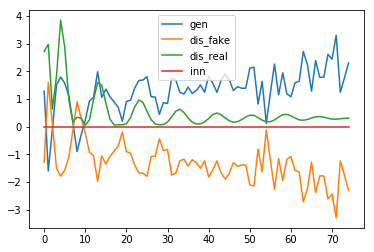

Pick prob : [0.22309739 0.14712446 0.         0.11813788 0.18206466 0.17916951
 0.07451775 0.07588835]
[3 5 5 0 6 0 1 7 4]
Generation 198  fitness : 1.443705406931345
#################################
[0.45586427 0.1        0.10317563 0.1        0.55849696 0.1
 0.1        0.1       ]
population fitness : [-111.97947662  -37.6852463   -48.06596289  -40.17983563 -130.57836196
  -29.36868648  -43.30901107  -35.98858719]
mean fit : -59.64439601736176
population fitness : [-1.4439817   0.60587678  0.31946154  0.53704835 -1.95714514  0.8353397
  0.45071101  0.65268945]
tensor([-1.6010, -0.0163, -0.0041,  0.0801, -2.5305,  0.1975,  0.0173,  0.0173],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


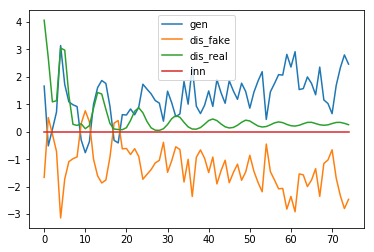

Pick prob : [0.032775   0.16369646 0.14540354 0.15930049 0.         0.17835193
 0.15378625 0.16668632]
[7 1 1 3 1 5 2 6 2]
Generation 199  fitness : 0.8353396976472057
#################################
[0.38878625 0.73274318 0.31167097 0.1        0.47382963 0.35587224
 0.17152604 0.37889806]
population fitness : [-41.79570929 -61.56352563 -37.3637571  -19.45147256 -46.68330353
 -39.90408297 -29.30937909 -41.22741723]
mean fit : -39.66233092368482
population fitness : [-0.18560226 -1.90538692  0.19997414  1.75832897 -0.61081916 -0.02103224
  0.90069876 -0.13616129]
tensor([-0.6922, -2.2597, -0.2141,  1.1853, -1.0420, -0.4802, -0.1088, -0.1088],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


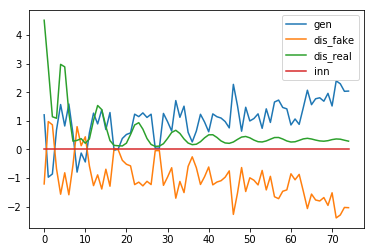

Pick prob : [0.11282385 0.         0.138119   0.24035249 0.08492814 0.12362021
 0.18408897 0.11606735]
[7 2 7 7 6 4 3 4 6]
Generation 200  fitness : 1.7583289697247375
#################################
[0.49683928 0.46723433 0.63981204 0.42207574 0.46077369 0.47670291
 0.11657951 0.1       ]
population fitness : [-38.08877968 -36.71473123 -44.72454497 -34.61879487 -36.41487498
 -37.1541943  -20.43986141 -15.02908047]
mean fit : -32.89810773710052
population fitness : [-0.55918544 -0.4111607  -1.27404922 -0.18536775 -0.37885751 -0.45850358
  1.34211333  1.92501087]
tensor([-1.1075, -0.6235, -1.9006, -0.5188, -0.9031, -1.0206,  1.1768,  1.1768],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


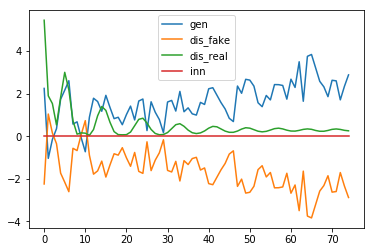

Pick prob : [0.07013699 0.08466005 0.         0.10681313 0.08782939 0.08001512
 0.25667793 0.3138674 ]
[7 0 3 3 6 4 6 0 3]
Generation 201  fitness : 1.9250108723999493
#################################
[0.41657759 0.24272379 0.1        0.20308608 0.1        0.1
 0.44697166 0.58877765]
population fitness : [-40.91076088 -36.37948621 -30.05320426 -35.34638057 -31.25784479
 -31.87559299 -41.70294291 -45.39893275]
mean fit : -36.61564317046418
population fitness : [-0.823965    0.04530378  1.25892241  0.24349227  1.02782708  0.90931976
 -0.97593528 -1.68496503]
tensor([-1.2925, -0.2032,  0.7674, -0.3191,  0.5053,  0.3259, -1.8171, -1.8171],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


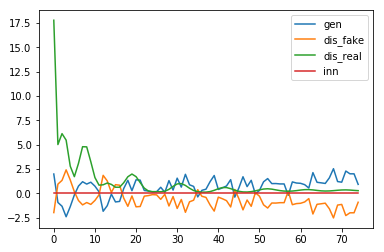

Pick prob : [0.06387373 0.12836088 0.21839381 0.1430636  0.20124988 0.19245836
 0.05259974 0.        ]
[5 2 5 4 0 5 0 1 3]
Generation 202  fitness : 1.2589224097998204
#################################
[0.12792316 0.15196604 0.1        0.1        0.1        0.10993703
 0.1        0.68237046]
population fitness : [ -43.88377849  -47.04541381  -27.06189429  -35.94623444  -38.71372678
  -41.51860317  -39.28009878 -116.79354588]
mean fit : -48.78041195334346
population fitness : [ 0.18618392  0.06596956  0.82579975  0.4879919   0.38276397  0.2761146
  0.3612289  -2.58605261]
tensor([-0.4188, -0.3354,  0.3397,  0.2304, -0.0756, -0.1006, -1.7897, -1.7897],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


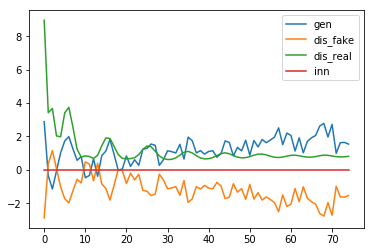

Pick prob : [0.13399943 0.12818872 0.16491604 0.14858768 0.14350136 0.13834634
 0.14246044 0.        ]
[3 1 1 3 1 2 1 0 2]
Generation 203  fitness : 0.8257997541957455
#################################
[0.49985847 0.1        0.1        0.49191479 0.1        0.1
 0.1        0.1       ]
population fitness : [-107.74380028  -45.77057143  -36.09062134 -106.55947765  -35.19681139
  -33.21990524  -44.42121702  -38.89955883]
mean fit : -55.98774539575659
population fitness : [-1.73573207  0.34265124  0.66728572 -1.69601369  0.69726124  0.76356033
  0.38790426  0.57308297]
tensor([-2.1078, -0.5095,  0.1475, -1.8556,  0.1865,  0.2380, -0.0016, -0.0016],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


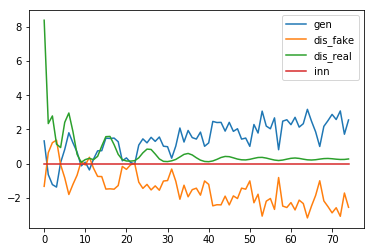

Pick prob : [0.         0.14967628 0.17305506 0.00286035 0.17521377 0.17998835
 0.15293521 0.16627098]
[1 4 5 5 2 6 6 7 2]
Generation 204  fitness : 0.7635603298812429
#################################
[0.1        0.50661306 0.1        0.46133176 0.1        0.1
 0.1        0.1       ]
population fitness : [ -36.03183888 -146.29369808  -36.71780137 -136.29708418  -49.87765324
  -45.29787024  -38.23567403  -34.45029991]
mean fit : -65.40023998906342
population fitness : [ 0.66514502 -1.83210113  0.64960912 -1.6056946   0.35156055  0.45528495
  0.61523185  0.70096423]
tensor([ 0.1505, -2.2434,  0.3968, -2.0379, -0.0735, -0.0662, -0.0224, -0.0224],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


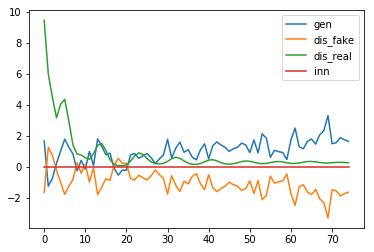

Pick prob : [0.1703813  0.         0.16932132 0.01544719 0.14898616 0.15606303
 0.16697584 0.17282516]
[7 0 5 7 2 5 7 0 0]
Generation 205  fitness : 0.7009642264848905
#################################
[0.1        0.44163991 0.1        0.1        0.47018597 0.45294301
 0.1        0.1       ]
population fitness : [ -53.68060677 -129.61206144  -48.87507369  -33.34950622 -135.8341357
 -132.07575347  -39.74100518  -40.77486927]
mean fit : -76.74287646737791
population fitness : [ 0.52903327 -1.21278427  0.63926903  0.99541532 -1.35551455 -1.26929974
  0.84879855  0.82508239]
tensor([ 0.1265, -1.6997,  0.0983,  0.3884, -1.7323, -1.7903,  0.4364,  0.4364],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


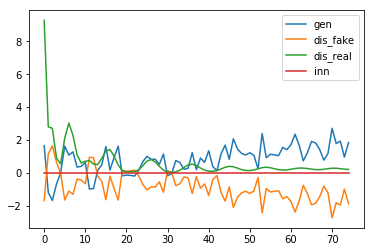

Pick prob : [0.17378528 0.013162   0.18395077 0.21679312 0.         0.00795038
 0.20327273 0.20108572]
[3 7 2 7 0 6 0 6 0]
Generation 206  fitness : 0.9954153220929978
#################################
[0.1        0.1        0.10197185 0.6550174  0.1        0.1
 0.1        0.1       ]
population fitness : [ -41.60534589  -31.32450839  -46.88131372 -131.25383317  -36.32028293
  -44.23348792  -40.01974735  -39.4183781 ]
mean fit : -51.38211218413298
population fitness : [ 0.32042407  0.65736858  0.14750932 -2.61771846  0.4936369   0.23428925
  0.37239053  0.39209982]
tensor([-0.2119,  0.2737, -0.4594, -2.8843, -0.2169, -0.4527,  0.0108,  0.0108],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


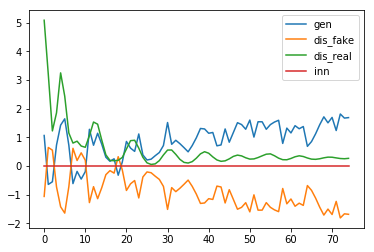

Pick prob : [0.14030073 0.15639034 0.13204379 0.         0.14857191 0.13618766
 0.14278221 0.14372336]
[6 2 1 2 4 4 7 4 7]
Generation 207  fitness : 0.6573685790895913
#################################
[0.26907071 0.54588485 0.30771672 0.1        0.57674171 0.44006081
 0.65920045 0.52184911]
population fitness : [-36.82690774 -44.42727981 -37.88799539 -29.43914357 -45.27450412
 -41.52171266 -47.53853978 -43.76734052]
mean fit : -40.83542794860977
population fitness : [ 0.72997399 -0.65409635  0.53674398  2.07532724 -0.80838065 -0.12497629
 -1.22067423 -0.53391771]
tensor([ 0.4435, -1.5653, -0.1777,  1.6759, -1.4026, -0.6459, -1.0808, -1.0808],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


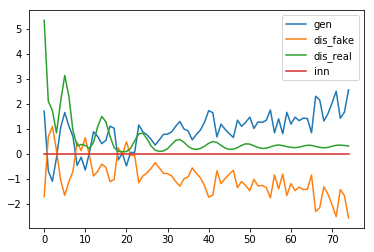

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[5 4 6 5 7 2 7 7 0]
Generation 208  fitness : 2.0753272446866036
#################################
[0.1        0.63566028 0.1        0.1        0.1        0.1076299
 0.1        0.1       ]
population fitness : [ -42.66610956 -129.13352205  -41.32192648  -41.9771385   -38.52069287
  -52.16997825  -40.57670633  -36.4822856 ]
mean fit : -52.856044955311035
population fitness : [ 0.34955482 -2.61661718  0.39566558  0.37318924  0.4917589   0.02353478
  0.42122956  0.56168428]
tensor([-0.3166, -3.0563, -0.0480,  0.0501,  0.0471, -0.5741, -0.0719, -0.0719],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


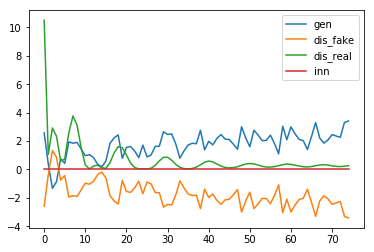

Pick prob : [0.14169879 0.         0.14390158 0.14282785 0.14849211 0.12612429
 0.14512281 0.15183256]
[4 6 6 7 7 5 0 2 7]
Generation 209  fitness : 0.5616842822517782
#################################
[0.25261105 0.1        0.22744069 0.1        0.68492428 0.12348926
 0.1        0.30292779]
population fitness : [-45.17847452 -38.27960139 -44.49106541 -40.34935092 -56.98506055
 -41.65212504 -40.69159168 -46.55263763]
mean fit : -44.272488393038046
population fitness : [-0.16586916  1.0971858  -0.04001737  0.71825328 -2.32743478  0.47973964
  0.65559538 -0.41745278]
tensor([-0.5838,  0.2758, -0.6143,  0.0435, -2.9234,  0.0889, -0.2053, -0.2053],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


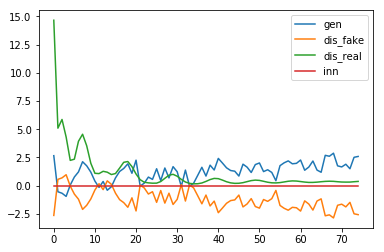

Pick prob : [0.11609163 0.18392677 0.12285078 0.16357537 0.         0.15076547
 0.16021019 0.10257978]
[6 1 3 6 7 0 2 2 0]
Generation 210  fitness : 1.0971857972545154
#################################
[0.3837785  0.1        0.53538028 0.59019068 0.26822083 0.47362581
 0.61514639 0.61453008]
population fitness : [-43.26297929 -29.90319388 -48.54041701 -50.44843214 -39.24027959
 -46.39067071 -51.31716999 -51.29571566]
mean fit : -45.0498572830095
population fitness : [ 0.25665281  2.17554511 -0.50135597 -0.77540795  0.83444109 -0.19258367
 -0.90018647 -0.89710495]
tensor([ 0.0161,  1.4087, -1.1802, -1.2279,  0.4132, -0.6550, -1.4317, -1.4317],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


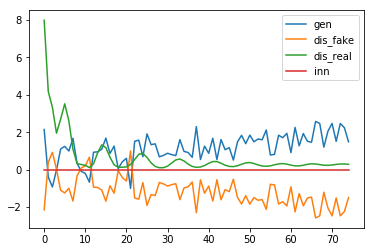

Pick prob : [0.16063884 0.42709645 0.05538165 0.01732676 0.24087059 0.09825781
 0.         0.0004279 ]
[1 1 5 4 1 5 4 4 1]
Generation 211  fitness : 2.17554511243715
#################################
[0.1        0.49378204 0.50064706 0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [ -45.73678244 -129.47075505 -130.64879548  -55.36932297  -44.73750658
  -55.44317355  -53.95153721  -52.52796288]
mean fit : -70.98572952032669
population fitness : [ 0.73568977 -1.70410414 -1.73842923  0.45502217  0.76480612  0.45287035
  0.49633282  0.53781214]
tensor([ 0.1102, -2.2700, -2.4886, -0.0678,  0.1039, -0.1158,  0.2725,  0.2725],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


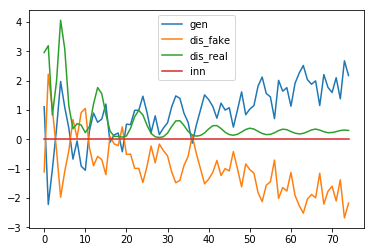

Pick prob : [0.17789903 0.00246811 0.         0.15771791 0.17999261 0.15756319
 0.16068831 0.16367084]
[4 0 0 6 7 0 6 5 5]
Generation 212  fitness : 0.7648061188322748
#################################
[0.1        0.1        0.10029209 0.1        0.1        0.64502675
 0.17615176 0.25651303]
population fitness : [ -41.30629957  -41.26127253  -48.32803522  -44.02272163  -38.63226241
 -100.99044992  -55.66179567  -63.43075009]
mean fit : -54.20419838150352
population fitness : [ 0.66707278  0.66940155  0.30391217  0.52658081  0.80537262 -2.41976117
 -0.07538619 -0.47719257]
tensor([ 0.1713,  0.3849, -0.3871, -0.2272,  0.3122, -2.8720, -0.8278, -0.8278],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


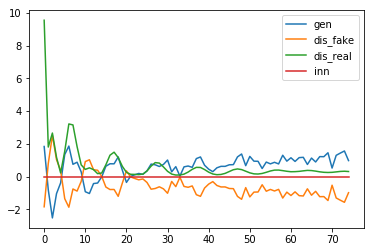

Pick prob : [0.15945964 0.15957994 0.14069949 0.15220211 0.16660393 0.
 0.1211057  0.10034919]
[2 6 1 6 0 1 3 3 7]
Generation 213  fitness : 0.8053726192592295
#################################
[0.63957206 0.36268606 0.1        0.3403508  0.1        0.10411914
 0.1        0.11601388]
population fitness : [-103.15714654  -69.98010605  -26.52232846  -67.30384911  -37.90113535
  -38.99809494  -35.54781169  -40.42334564]
mean fit : -52.47922722161938
population fitness : [-2.11471645 -0.73028642  1.08314393 -0.61861008  0.60832274  0.5625482
  0.70652354  0.50307454]
tensor([-2.7328, -1.0019,  0.5472, -0.8090, -0.0019,  0.0433, -0.0902, -0.0902],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


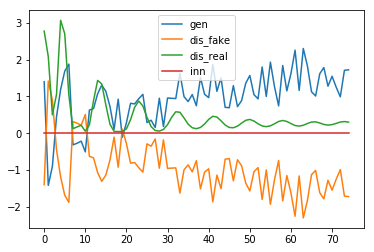

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[6 3 0 1 5 2 7 1 1]
Generation 214  fitness : 1.083143930883222
#################################
[0.1        0.56643873 0.34569564 0.1        0.1        0.43268893
 0.1        0.1       ]
population fitness : [ -43.47363403 -153.93934369 -105.35214323  -36.16576447  -29.26195355
 -124.50001396  -48.75335053  -49.96888419]
mean fit : -73.92688595726713
population fitness : [ 0.69178147 -1.81757718 -0.71386172  0.85778833  1.01461653 -1.14882815
  0.5718465   0.54423422]
tensor([-0.0528, -2.1803, -1.1954,  0.4466,  0.4484, -1.8192,  0.1251,  0.1251],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


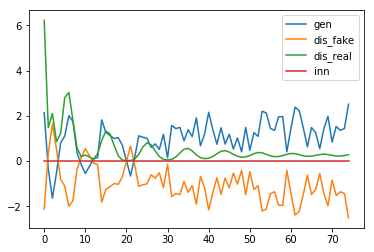

Pick prob : [0.1725758  0.         0.07590568 0.18399257 0.19477809 0.04599179
 0.16432752 0.16242855]
[7 6 6 7 4 3 6 6 6]
Generation 215  fitness : 1.0146165266969562
#################################
[0.1        0.1        0.1        0.19914412 0.1        0.66067945
 0.1576462  0.1       ]
population fitness : [ -47.68819538  -36.0870229   -42.93596642  -60.99961027  -38.24207038
 -118.73688589  -55.80829102  -46.22797171]
mean fit : -55.84075174591338
population fitness : [ 3.25846066e-01  7.89528406e-01  5.15785889e-01 -2.06192227e-01
  7.03394228e-01 -2.51386890e+00  1.29740900e-03  3.84209126e-01]
tensor([-0.1940,  0.1733, -0.2655, -0.8620,  0.4381, -3.0948, -0.2357, -0.2357],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


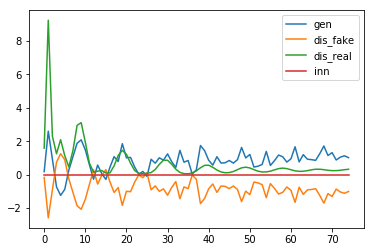

Pick prob : [0.14120242 0.16425863 0.15064702 0.11474727 0.15997568 0.
 0.12506451 0.14410447]
[3 4 4 4 1 1 3 3 2]
Generation 216  fitness : 0.7895284059040393
#################################
[0.1        0.1        0.56906272 0.51002495 0.1        0.13345133
 0.11275365 0.15732444]
population fitness : [ -37.04638415  -44.40988842 -114.71966915 -105.92853115  -29.98222857
  -49.85406984  -46.77203962  -53.40894468]
mean fit : -60.26521944626414
population fitness : [ 0.77964201  0.53239028 -1.82847142 -1.5332826   1.01684222  0.34958556
  0.45307397  0.23021998]
tensor([ 0.2176,  0.1639, -2.5039, -1.9166,  0.5399, -0.0348, -0.1101, -0.1101],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


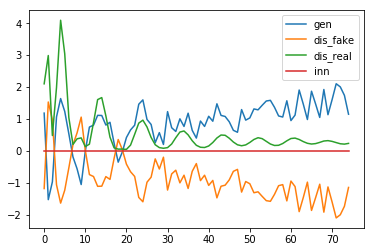

Pick prob : [0.17829876 0.16139586 0.         0.02018003 0.1945145  0.14889876
 0.15597355 0.14073855]
[1 0 7 4 1 0 4 4 4]
Generation 217  fitness : 1.016842216552892
#################################
[0.22035238 0.57125838 0.54516135 0.56798677 0.26426038 0.51012794
 0.53631694 0.1       ]
population fitness : [-36.43904196 -47.42556259 -46.60849045 -47.3231317  -37.81375797
 -45.51162897 -46.33158069 -29.54002623]
mean fit : -42.12415256839524
population fitness : [ 0.90790304 -0.84662667 -0.71614156 -0.83026862  0.6883631  -0.54097454
 -0.67191952  2.00966477]
tensor([ 0.4971, -1.4114, -1.3228, -1.3982,  0.3468, -1.1981,  0.3262,  0.3262],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


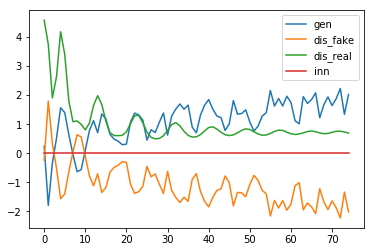

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[5 5 5 1 5 2 4 2 4]
Generation 218  fitness : 2.0096647729901926
#################################
[0.67843675 0.24541022 0.13036057 0.15674526 0.15146981 0.17359362
 0.1        0.1       ]
population fitness : [-108.73490046  -62.54418139  -50.27189499  -53.08633615  -52.52360675
  -54.88354153  -36.42904     -36.36639917]
mean fit : -56.854987554460564
population fitness : [-2.43180664 -0.26667391  0.30857431  0.17665086  0.20302811  0.09240909
  0.95744098  0.96037719]
tensor([-2.8793, -0.8000, -0.3447, -0.3130, -0.2624, -0.2507,  0.5047,  0.5047],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


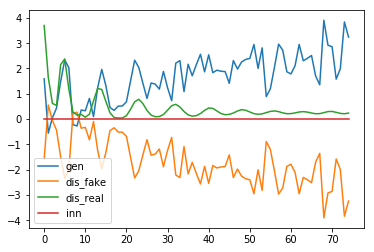

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[0 7 2 7 1 7 2 2 1]
Generation 219  fitness : 0.960377193960921
#################################
[0.2289629  0.49093234 0.16054431 0.49665327 0.61043361 0.1
 0.14997329 0.18971227]
population fitness : [ -54.30597228 -103.44979011  -41.47107542 -104.52299921 -125.86747489
  -11.35397304  -39.4880183   -46.9428008 ]
mean fit : -65.92526300624704
population fitness : [ 0.30969299 -1.00015424  0.65178594 -1.02875885 -1.59766056  1.45450752
  0.70464105  0.50594615]
tensor([-0.3050, -1.3160,  0.1011, -1.3028, -1.9506,  1.0058,  0.0443,  0.0443],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


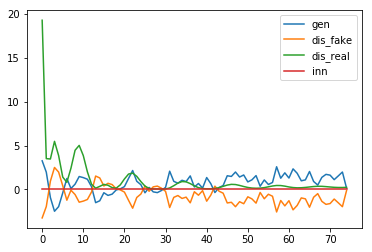

Pick prob : [0.14923019 0.04674854 0.17599534 0.04451053 0.         0.23879979
 0.18013069 0.16458492]
[7 5 5 5 7 6 2 5 5]
Generation 220  fitness : 1.454507519873857
#################################
[0.25616882 0.1        0.76929077 0.23030716 0.32798228 0.26603199
 0.31091687 0.26784822]
population fitness : [ -41.14055034   -4.88487165 -113.76291124  -37.48033879  -51.30433951
  -42.53648845  -48.88906501  -42.79354037]
mean fit : -47.849013169886454
population fitness : [ 0.23699722  1.51784135 -2.32861256  0.36630553 -0.1220701   0.18768139
 -0.03674305  0.17860023]
tensor([-0.1123,  0.9683, -3.1157, -0.2809, -0.2088, -0.4310, -0.4554, -0.4554],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


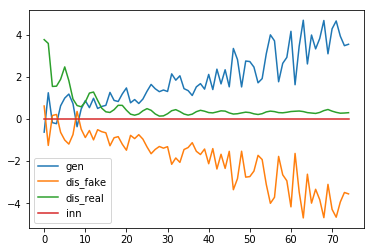

Pick prob : [0.13772202 0.20647777 0.         0.14466329 0.11844727 0.13507474
 0.12302763 0.13458727]
[6 7 5 4 1 6 5 4 4]
Generation 221  fitness : 1.517841345004518
#################################
[0.51543803 0.1        0.13585466 0.4803079  0.1        0.1
 0.1        0.1       ]
population fitness : [-128.35670326  -52.82941763  -62.82519336 -122.29181523  -41.51739357
  -42.8983332   -44.54800362  -39.37115919]
mean fit : -66.82975238386128
population fitness : [-1.78193723  0.40547626  0.11597963 -1.60628657  0.73309394  0.6930993
  0.64532172  0.79525295]
tensor([-2.4597, -0.0099, -0.3541, -2.2257,  0.2001,  0.1672,  0.2859,  0.2859],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


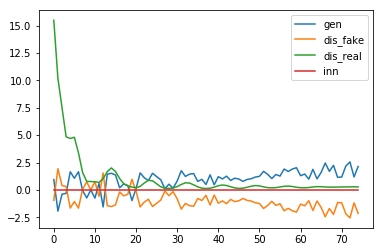

Pick prob : [0.         0.1534435  0.13313578 0.01232161 0.17642535 0.17361979
 0.17026827 0.1807857 ]
[6 2 7 1 5 7 7 2 4]
Generation 222  fitness : 0.7952529547777702
#################################
[0.1        0.64135897 0.1        0.1        0.1        0.1
 0.1        0.1       ]
population fitness : [-48.63457783 -98.89500712 -45.51041682 -42.19025306 -48.40148153
 -43.82287825 -49.54311138 -43.66498214]
mean fit : -52.582838517550755
population fitness : [ 0.22328396 -2.61906835  0.39996304  0.58772656  0.23646614  0.49539755
  0.17190413  0.50432696]
tensor([-0.3251, -3.1667, -0.2061, -0.0313, -0.4200,  0.1204,  0.0112,  0.0112],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


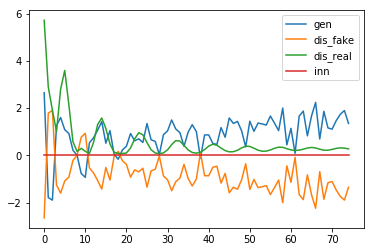

Pick prob : [0.13565665 0.         0.14408899 0.15305036 0.13628579 0.14864379
 0.13320445 0.14906996]
[2 4 2 2 4 2 5 4 4]
Generation 223  fitness : 0.5877265614601194
#################################
[0.1        0.39904679 0.18662486 0.55634426 0.16005088 0.46686078
 0.1        0.1       ]
population fitness : [-44.69434551 -53.54567914 -48.77030724 -57.08182049 -48.17290846
 -55.07017822 -44.57486894 -46.66673231]
mean fit : -49.82210503846903
population fitness : [ 1.14048514 -0.82817474  0.23393448 -1.61466183  0.36680429 -1.16724457
  1.16705839  0.70179884]
tensor([ 0.5591, -1.3320, -0.2206, -2.1218, -0.1706, -1.6942,  0.3567,  0.3567],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


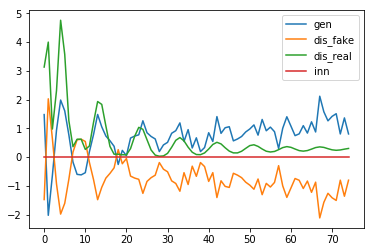

Pick prob : [0.21329133 0.06088636 0.14311018 0.         0.15339637 0.03463707
 0.21534852 0.17933017]
[5 4 2 7 6 6 2 7 4]
Generation 224  fitness : 1.167058392343819
#################################
[0.1        0.1        0.46004276 0.1        0.51494205 0.1
 0.1        0.1       ]
population fitness : [ -54.65888651  -56.97758415 -127.38862825  -45.80395524 -137.12455117
  -46.84395251  -50.98835781  -50.26565151]
mean fit : -71.25644589427716
population fitness : [ 0.46795475  0.40258095 -1.58260145  0.71761237 -1.85709792  0.68829049
  0.57144234  0.59181846]
tensor([ 0.0229, -0.0142, -2.0776,  0.2323, -2.2200, -0.0032,  0.1541,  0.1541],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


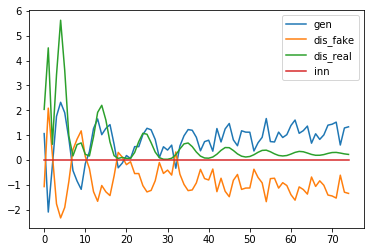

Pick prob : [0.15649772 0.15209745 0.01847617 0.173302   0.         0.17132837
 0.1634634  0.1648349 ]
[3 7 7 5 5 6 7 1 5]
Generation 225  fitness : 0.7176123730869398
#################################
[0.43135457 0.1        0.54330687 0.1        0.1        0.1013838
 0.1        0.1       ]
population fitness : [-134.92244534  -46.01224864 -159.2970046   -49.65484991  -47.72566646
  -63.08031303  -43.78296241  -41.00675605]
mean fit : -73.185280806143
population fitness : [-1.41779338  0.62402842 -1.9775549   0.54037612  0.5846798   0.23206049
  0.67522396  0.73897951]
tensor([-1.8334,  0.0123, -2.4857, -0.0301,  0.0955, -0.3821,  0.2152,  0.2152],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


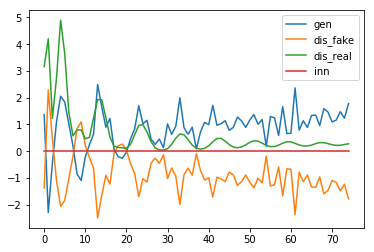

Pick prob : [0.03538217 0.16444444 0.         0.15915683 0.16195724 0.1396684
 0.16768048 0.17171043]
[3 6 0 1 5 4 5 3 6]
Generation 226  fitness : 0.7389795072820706
#################################
[0.30271104 0.1        0.59479991 0.1        0.45619948 0.1
 0.28011555 0.24832371]
population fitness : [-44.700987   -34.74624262 -54.30641775 -37.13297491 -49.74850067
 -34.83523655 -43.95792734 -42.91244302]
mean fit : -42.79259123227269
population fitness : [-0.29015933  1.22339568 -1.75060345  0.86050835 -1.0576014   1.20986473
 -0.17718188 -0.01822269]
tensor([-0.7101,  0.6404, -2.3240,  0.3530, -1.3332,  0.6560, -0.5764, -0.5764],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


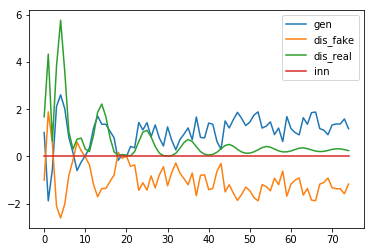

Pick prob : [0.10428148 0.21235528 0.         0.18644369 0.04948308 0.21138912
 0.11234851 0.12369883]
[6 6 5 5 7 1 5 6 3]
Generation 227  fitness : 1.2233956834154733
#################################
[0.51369167 0.1        0.5028757  0.1        0.11018114 0.1
 0.1        0.1       ]
population fitness : [-129.34819737  -48.67658309 -127.26796896  -35.26632058  -51.74129579
  -30.55023417  -44.11615369  -34.81352243]
mean fit : -62.72253450996443
population fitness : [-1.73207258  0.3651537  -1.67799272  0.71378135  0.28548012  0.83638582
  0.48371154  0.72555278]
tensor([-2.1356, -0.1089, -2.2313,  0.1798, -0.1414,  0.3659,  0.1813,  0.1813],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


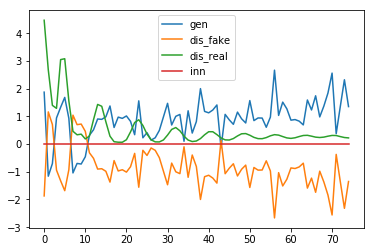

Pick prob : [0.         0.15135237 0.00390283 0.17651208 0.14560249 0.18536019
 0.15990843 0.1773616 ]
[6 6 3 7 4 5 5 4 3]
Generation 228  fitness : 0.836385815380034
#################################
[0.5462133  0.47444012 0.1        0.1        0.1        0.10200251
 0.10984411 0.1       ]
population fitness : [-109.72428587  -99.91377668  -37.40646249  -35.06365675  -45.09101753
  -49.00614262  -50.07799381  -41.04460419]
mean fit : -58.41599249131903
population fitness : [-1.87684414 -1.51797825  0.76852319  0.85422242  0.48742415  0.34420988
  0.30500184  0.6354409 ]
tensor([-2.3792, -2.0985,  0.2692,  0.2967, -0.0790, -0.1803, -0.0621, -0.0621],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


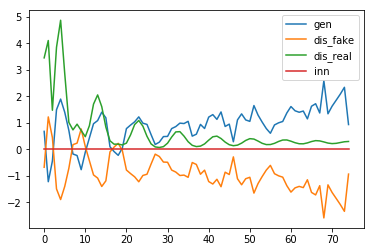

Pick prob : [0.         0.02390089 0.17618454 0.18189221 0.15746301 0.14792478
 0.14531348 0.1673211 ]
[7 3 5 3 6 2 3 3 2]
Generation 229  fitness : 0.8542224199902828
#################################
[0.19143773 0.20309968 0.18877292 0.1        0.1        0.70681657
 0.19260848 0.1630704 ]
population fitness : [ -46.30231903  -47.61798151  -46.00168452  -30.29122611  -24.70495797
 -104.44562697  -46.4343991   -43.10201197]
mean fit : -48.61252589523923
population fitness : [ 0.10238769  0.04407791  0.11571172  0.8119946   1.05957635 -2.47450656
  0.09653394  0.24422435]
tensor([-0.5314, -0.4110, -0.5125,  0.2496,  0.3212, -3.0698, -0.1452, -0.1452],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


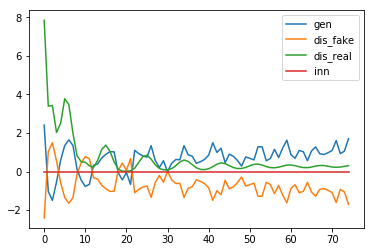

Pick prob : [0.13017213 0.1272266  0.13084519 0.16601801 0.17852463 0.
 0.12987642 0.13733702]
[7 0 1 6 4 2 7 4 3]
Generation 230  fitness : 1.0595763524899489
#################################
[0.1        0.1        0.66391278 0.1        0.1        0.1906965
 0.1        0.1       ]
population fitness : [ -40.32211019  -48.22356577 -107.32387144  -47.98149438  -43.40442718
  -59.56711034  -49.73224183  -49.34350495]
mean fit : -55.737290757908774
population fitness : [ 0.76373632  0.37226321 -2.55582767  0.3842565   0.61102468 -0.18974622
  0.29751672  0.31677647]
tensor([ 0.0531,  0.0595, -2.8534, -0.2088,  0.4545, -0.6077, -0.2400, -0.2400],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


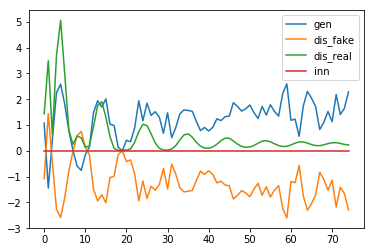

Pick prob : [0.16235269 0.14320659 0.         0.14379315 0.15488389 0.11571992
 0.1395509  0.14049285]
[7 3 3 5 4 1 7 6 6]
Generation 231  fitness : 0.7637363151036195
#################################
[0.1        0.57182286 0.1        0.35099267 0.30220446 0.35085074
 0.4996458  0.1       ]
population fitness : [-39.07722451 -53.61936223 -38.02633333 -47.59754722 -46.26714235
 -47.59367687 -51.65116715 -40.23584041]
mean fit : -45.50853675747561
population fitness : [ 1.17923544 -1.48718838  1.37192522 -0.38303772 -0.13909674 -0.38232806
 -1.12630319  0.96679343]
tensor([ 0.6068, -1.8844,  0.9192, -1.0306, -0.7721, -1.0401, -0.2863, -0.2863],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


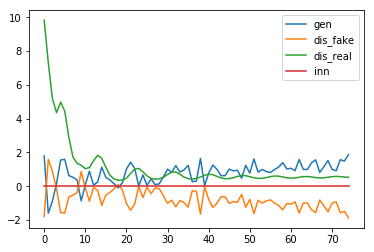

Pick prob : [0.22411618 0.         0.24031199 0.09280521 0.11330875 0.09286486
 0.03033284 0.20626017]
[0 0 3 5 7 7 0 3 7]
Generation 232  fitness : 1.371925221224325
#################################
[0.57733395 0.62460782 0.53715742 0.52606614 0.29353963 0.1
 0.26199235 0.28069067]
population fitness : [-52.16145596 -54.3367486  -50.31274477 -49.80238306 -39.10274534
 -25.59560732 -37.65110664 -38.51150432]
mean fit : -43.43428700264026
population fitness : [-0.94830224 -1.18467155 -0.74741958 -0.6919632   0.47066932  1.93836742
  0.62840572  0.53491411]
tensor([-1.5259, -1.7686, -1.2206, -1.0270, -0.0984,  1.4418,  0.0137,  0.0137],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


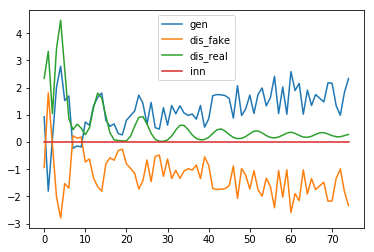

Pick prob : [0.02494038 0.         0.04613641 0.05198786 0.17466243 0.32952583
 0.1913059  0.18144118]
[4 4 6 5 3 2 5 6 7]
Generation 233  fitness : 1.9383674171133165
#################################
[0.1        0.1        0.15426256 0.1        0.1        0.65514485
 0.1        0.1       ]
population fitness : [ -29.59105802  -45.28753824  -61.84023596  -44.95048569  -42.82866896
 -166.55159611  -41.34968173  -34.72391863]
mean fit : -58.390397917835955
population fitness : [ 0.68880204  0.31338484 -0.08251076  0.32144622  0.37219432 -2.58692228
  0.40756768  0.56603795]
tensor([ 0.1698, -0.3873, -0.4144, -0.2407,  0.0451, -3.0651, -0.0749, -0.0749],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


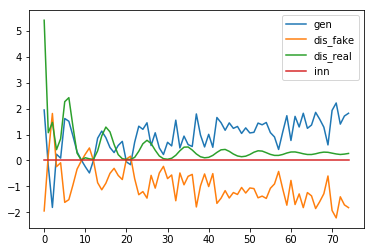

Pick prob : [0.15828289 0.14014275 0.12101308 0.14053227 0.14298442 0.
 0.14469366 0.15235094]
[0 4 3 3 0 7 0 7 3]
Generation 234  fitness : 0.6888020412938654
#################################
[0.41965046 0.66059889 0.20317482 0.1        0.17823553 0.26632669
 0.1        0.1       ]
population fitness : [-47.54791157 -60.36474702 -36.03286334 -30.40989903 -34.7062611
 -39.39211823 -25.22532989 -29.23690753]
mean fit : -37.86450471466921
population fitness : [-0.91020971 -2.11495182  0.17216851  0.70070942  0.29686494 -0.14359085
  1.18804257  0.81096693]
tensor([-1.4359, -2.6704, -0.2202,  0.2183, -0.2330, -0.6305,  0.4368,  0.4368],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


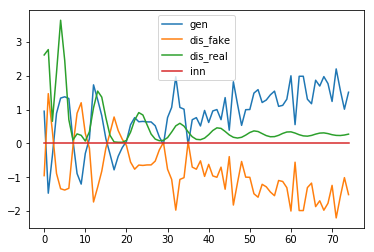

Pick prob : [0.07120387 0.         0.13517568 0.16641403 0.14254561 0.11651335
 0.19521688 0.17293058]
[3 2 4 0 6 3 3 6 2]
Generation 235  fitness : 1.1880425733151643
#################################
[0.60244282 0.43030377 0.52179954 0.17628114 0.61291574 0.29234032
 0.1        0.36449479]
population fitness : [-44.57065774 -40.2561321  -42.5493993  -33.8892609  -44.83315286
 -36.79819005 -29.47091703 -38.6066834 ]
mean fit : -38.871799173010466
population fitness : [-1.13685244 -0.27615745 -0.73363615  0.99395532 -1.189217    0.41365961
  1.87536077  0.05288735]
tensor([-1.8062, -0.9030, -0.9999,  0.6661, -1.5131, -0.3219,  0.3489,  0.3489],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


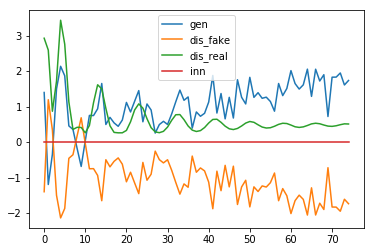

Pick prob : [0.0055041  0.09597276 0.04788664 0.22947581 0.         0.16848025
 0.32212138 0.13055905]
[6 6 0 5 6 6 6 1 6]
Generation 236  fitness : 1.8753607727335366
#################################
[0.1        0.52185469 0.1        0.1        0.43576071 0.1
 0.38615383 0.37857851]
population fitness : [ -31.59576199 -141.09768008  -41.86695077  -43.83792815 -123.03239164
  -42.84565553 -112.62327016 -111.03372341]
mean fit : -80.99167021550434
population fitness : [ 1.17703357 -1.43223992  0.93228589  0.88532033 -1.00177003  0.90896476
 -0.75373561 -0.71585899]
tensor([ 0.4710, -2.1483,  0.5054,  0.3830, -1.3132,  0.4808, -0.9940, -0.9940],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


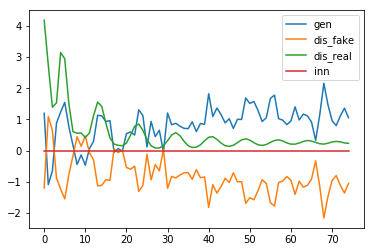

Pick prob : [0.22772664 0.         0.20636607 0.20226711 0.03756964 0.2043307
 0.05921706 0.06252278]
[4 7 2 0 3 3 6 5 3]
Generation 237  fitness : 1.1770335726098198
#################################
[0.25457496 0.56060493 0.24308034 0.12038429 0.5760495  0.49829658
 0.1        0.44060549]
population fitness : [-33.02336544 -50.02312979 -32.38484675 -25.56916142 -50.8810657
 -46.56194169 -18.88189292 -43.35723933]
mean fit : -37.585330380963335
population fitness : [ 0.41062274 -1.11952707  0.46809584  1.08157609 -1.19674994 -0.80798532
  1.68349753 -0.51952987]
tensor([-0.0292, -1.5847,  0.1251,  0.6021, -1.8459, -1.4266,  0.0854,  0.0854],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


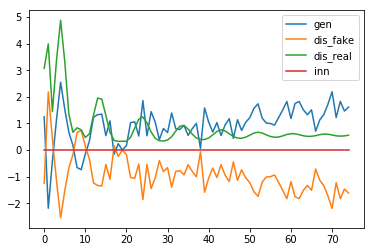

Pick prob : [0.16788936 0.00806589 0.1738924  0.23797014 0.         0.04060629
 0.30084057 0.07073534]
[3 2 5 6 3 2 2 0 3]
Generation 238  fitness : 1.683497531083337
#################################
[0.1        0.14373918 0.26315403 0.1        0.67366133 0.15476658
 0.11594382 0.26101248]
population fitness : [ -18.22328316  -40.17368018  -58.4095094   -19.9015344  -121.09804088
  -41.85767258  -35.9290527   -58.08247372]
mean fit : -49.20940587685042
population fitness : [ 1.01454203  0.2958461  -0.30122813  0.95959303 -2.35376469  0.24070912
  0.43482292 -0.29052038]
tensor([ 0.4475, -0.3683, -0.9680,  0.5013, -2.9069, -0.2618, -0.3261, -0.3261],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


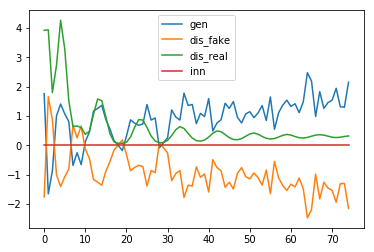

Pick prob : [0.17887869 0.14071133 0.10900285 0.17596054 0.         0.1377832
 0.14809189 0.1095715 ]
[1 2 0 3 5 6 6 2 6]
Generation 239  fitness : 1.0145420288423501
#################################
[0.18560705 0.10338725 0.1        0.10596839 0.70243373 0.11411332
 0.180898   0.15829136]
population fitness : [ -57.81777778  -45.72901146  -30.52799702  -46.10851596 -133.80674084
  -47.30606432  -57.12540791  -53.80155578]
mean fit : -59.02788388514003
population fitness : [ 0.04115171  0.4522507   0.96918696  0.439345   -2.54298178  0.39862034
  0.06469692  0.17773015]
tensor([-0.3753, -0.0441,  0.5081, -0.1361, -3.0685, -0.2076, -0.3488, -0.3488],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


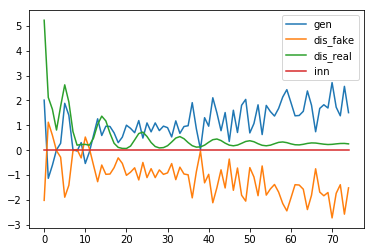

Pick prob : [0.12702281 0.14723034 0.17264028 0.14659596 0.         0.14459414
 0.12818017 0.13373631]
[6 0 7 2 6 5 0 5 3]
Generation 240  fitness : 0.9691869602429184
#################################
[0.11114797 0.23529641 0.19963961 0.7345239  0.1        0.25810059
 0.25209219 0.28739951]
population fitness : [ -35.18184657  -49.00522215  -45.03499713 -104.59198029  -22.80601514
  -51.54436653  -50.87535789  -54.8066707 ]
mean fit : -51.73080704995077
population fitness : [ 0.74313528  0.12239308  0.30067705 -2.37374443  1.29887514  0.00837216
  0.03841416 -0.13812244]
tensor([ 0.3590, -0.5191, -0.0479, -3.0396,  0.8557, -0.5236, -0.4505, -0.4505],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


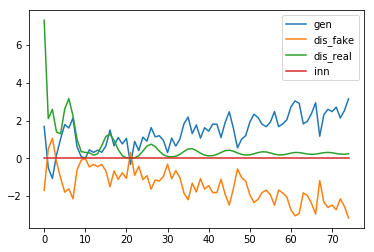

Pick prob : [0.16413307 0.13144515 0.14083348 0.         0.19339801 0.12544087
 0.12702287 0.11772655]
[0 5 6 4 2 1 1 1 6]
Generation 241  fitness : 1.298875138608278
#################################
[0.1        0.42598511 0.1        0.1        0.1        0.51487104
 0.39685515 0.36267402]
population fitness : [-27.82841225 -49.48884277 -28.92608146 -25.72646983 -28.07516855
 -54.44709264 -47.86391025 -45.95721292]
mean fit : -38.539148833035014
population fitness : [ 0.96005022 -0.98146901  0.86166132  1.14845652  0.93793237 -1.42589866
 -0.8358192  -0.66491357]
tensor([ 0.6222, -1.3622,  0.3878,  0.7096,  0.4134, -1.9935, -1.4609, -1.4609],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


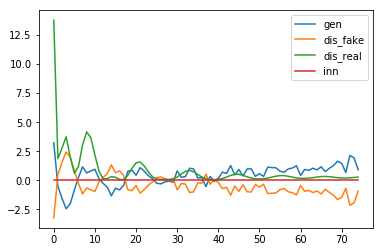

Pick prob : [0.20916186 0.03896049 0.20053669 0.22567831 0.20722292 0.
 0.05172873 0.06671101]
[2 6 7 3 1 3 4 7 4]
Generation 242  fitness : 1.1484565244717095
#################################
[0.5173465  0.56527553 0.56611773 0.1        0.22306771 0.39298528
 0.1219868  0.25110455]
population fitness : [-49.75902541 -53.05903852 -53.11702577 -14.13864799 -29.49732159
 -41.1964982  -22.53769148 -31.42771593]
mean fit : -36.84162061106808
population fitness : [-0.93805494 -1.1777001  -1.1819111   1.64867757  0.53333901 -0.31624885
  1.03874358  0.39315482]
tensor([-1.6674, -1.4822, -1.6414,  0.8942,  0.0328, -0.8934,  0.3977,  0.3977],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


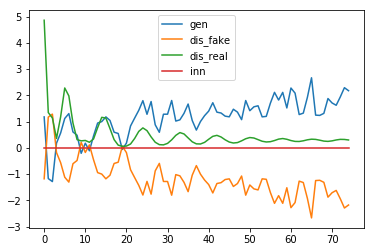

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[3 6 6 2 0 2 2 3 4]
Generation 243  fitness : 1.6486775678722576
#################################
[0.21284615 0.1        0.1        0.1        0.1        0.67022363
 0.1        0.13117707]
population fitness : [ -65.71270098  -41.2665424   -40.30847433  -43.67045818  -30.53603694
 -141.30257683  -45.46990334  -52.21541234]
mean fit : -57.560263166259176
population fitness : [-0.24664292  0.49294836  0.52193364  0.42022057  0.81758784 -2.53353036
  0.36578036  0.1617025 ]
tensor([-0.6583, -0.0368, -0.0667, -0.1063,  0.4009, -2.9125, -0.1622, -0.1622],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


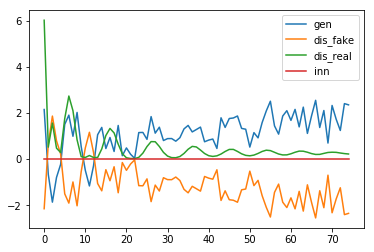

Pick prob : [0.11283107 0.14932122 0.1507513  0.14573296 0.16533837 0.
 0.14304697 0.13297812]
[7 3 7 6 6 1 2 4 4]
Generation 244  fitness : 0.8175878436710987
#################################
[0.1        0.24963515 0.32796782 0.17699367 0.16691111 0.48434754
 0.66649954 0.46723525]
population fitness : [-27.50519391 -36.44082133 -39.24471962 -33.84063796 -33.47973533
 -44.84229245 -51.36237779 -44.22976228]
mean fit : -38.868192583434805
population fitness : [ 1.58724363  0.33906803 -0.05259528  0.70227537  0.75268815 -0.8344938
 -1.74525374 -0.74893236]
tensor([ 1.3989, -0.1125, -0.4810,  0.4829,  0.3871, -1.4786, -1.8425, -1.8425],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


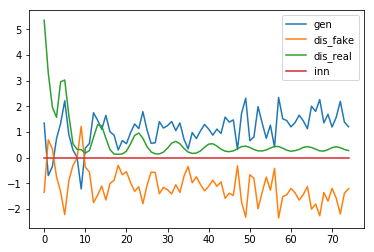

Pick prob : [0.23868287 0.14928501 0.12123298 0.17529894 0.17890965 0.0652312
 0.         0.07135935]
[3 2 4 3 4 2 2 2 1]
Generation 245  fitness : 1.587243634737917
#################################
[0.11407662 0.15314777 0.54058512 0.55353873 0.1        0.1
 0.11097575 0.12780766]
population fitness : [ -50.08725106  -55.15572326 -105.41571024 -107.09610747  -35.2887564
  -44.36387926  -49.68499362  -51.86849834]
mean fit : -62.3701149587588
population fitness : [ 0.47342236  0.27806661 -1.65912016 -1.72388825  1.04380547  0.69402011
  0.48892669  0.40476717]
tensor([-0.1831, -0.4047, -2.2830, -2.1248,  0.6051,  0.2510,  0.0167,  0.0167],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


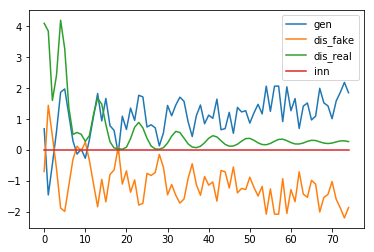

Pick prob : [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
[4 4 2 7 7 2 4 6 1]
Generation 246  fitness : 1.0438054723431691
#################################
[0.1        0.18607648 0.1        0.1        0.1        0.64686672
 0.1        0.1       ]
population fitness : [ -33.00538797  -54.41704124  -34.14237781  -38.22701197  -30.46290372
 -133.04208622  -23.32679429  -22.66664752]
mean fit : -46.161281341663326
population fitness : [ 0.3855074  -0.2419187   0.35219017  0.23249805  0.46000987 -2.54586994
  0.66911943  0.68846372]
tensor([ 0.0138, -0.9422, -0.2733, -0.2809, -0.1612, -3.1229,  0.2930,  0.2930],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


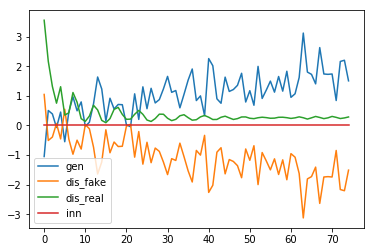

Pick prob : [0.14392808 0.113122   0.14229223 0.13641545 0.14758608 0.
 0.15785318 0.15880297]
[0 0 3 3 6 2 6 2 2]
Generation 247  fitness : 0.6884637199409025
#################################
[0.1        0.65739979 0.1        0.16560731 0.10713478 0.1
 0.1        0.10495729]
population fitness : [ -31.15025234 -111.93559662  -41.71003397  -50.21164248  -42.87286564
  -29.4265796   -33.02261088  -42.59957295]
mean fit : -47.866144308662285
population fitness : [ 0.66592868 -2.55240257  0.24524748 -0.09344009  0.19892253  0.73459645
  0.59133755  0.20980998]
tensor([ 0.1447, -3.0416, -0.4065, -0.5434, -0.4276,  0.2300, -0.0223, -0.0223],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


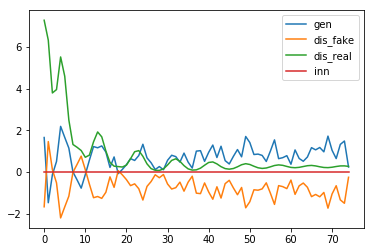

Pick prob : [0.15761284 0.         0.13701062 0.12042391 0.13474193 0.16097573
 0.15395985 0.13527512]
[5 2 0 6 3 5 5 0 0]
Generation 248  fitness : 0.7345964512584636
#################################
[0.1        0.1        0.1        0.1        0.1        0.64966407
 0.1        0.1       ]
population fitness : [ -43.13039717  -45.75760963  -28.00927834  -27.96608858  -34.53317017
 -146.73751376  -43.20401812  -43.75634421]
mean fit : -51.636802496148704
population fitness : [ 0.23264459  0.16079206  0.64619725  0.64737846  0.4677731  -2.60094193
  0.23063111  0.21552535]
tensor([-0.0392, -0.6665,  0.1773,  0.2372, -0.2947, -2.9771, -0.1062, -0.1062],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


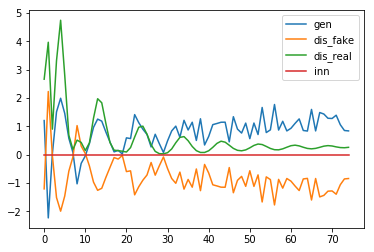

Pick prob : [0.13618079 0.13272759 0.15605592 0.15611269 0.14748095 0.
 0.13608402 0.13535804]
[7 2 3 6 3 0 0 7 3]
Generation 249  fitness : 0.6473784641049433
#################################
[0.12284135 0.35542685 0.1        0.52995529 0.1        0.1
 0.50955091 0.1       ]
population fitness : [ -56.66362305 -105.20596085  -43.69163001 -141.6313528   -49.60217898
  -46.4011141  -137.37280579  -31.02571425]
mean fit : -76.4492974778637
population fitness : [ 0.4740049  -0.68892266  0.78477461 -1.56156486  0.64317574  0.71986357
 -1.45954295  1.08821164]
tensor([ 0.0203, -0.9331,  0.3270, -2.0698,  0.2613,  0.0737, -0.7883, -0.7883],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


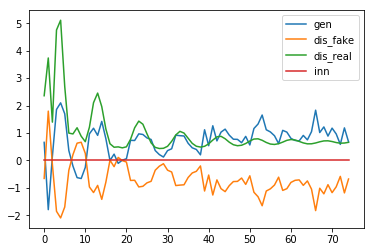

Pick prob : [0.1629431  0.06985318 0.18781957 0.         0.17648487 0.18262357
 0.00816664 0.21210907]
[5 5 2 4 4 7 2 4 5]
Generation 250  fitness : 1.088211639421766
#################################
[0.4321615  0.46223539 0.77162361 0.50034757 0.1        0.53535817
 0.50883239 0.48948788]
population fitness : [-37.88102072 -39.49738991 -56.12594978 -41.54578937 -14.65381682
 -43.42748924 -42.00181958 -40.96211816]
mean fit : -39.51192419816083
population fitness : [ 1.51721593e-01  1.35211263e-03 -1.54558897e+00 -1.89208784e-01
  2.31252904e+00 -3.64261756e-01 -2.31632895e-01 -1.34910338e-01]
tensor([-0.2719, -0.4781, -1.9472, -0.6145,  1.6601, -0.9097, -0.6320, -0.6320],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


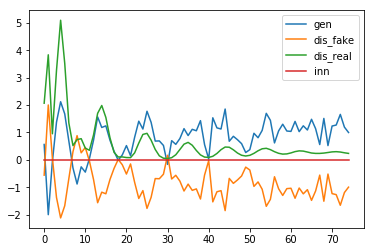

KeyboardInterrupt: 

In [5]:
#randomly inititialise starting population
population_size = 2
max_population = 8

batch_size = population_size
out_size = population_size
ranking = np.zeros([population_size])
parent_fitness = np.zeros([population_size])
population = []

for p in range(population_size):
    population.append(Creature().to(device))
old_population = population 

gen = Generator().to(device)
dis = Discriminator().to(device)
inn = Generator().to(device)

lr = 0.0001

print("starting training")
print(len(get_params(Creature())))
n_generations = 300000


fit_bank = np.array([])
def get_pick_probabilities(p_fitness):
    #if(np.max(p_fitness)-np.min(p_fitness) == 0):
    if(np.sum(p_fitness) == 0):
        return np.ones(p_fitness.shape)/p_fitness.size
    
    
    normed = p_fitness #** 3
    pick_probabilities = (normed-np.min(normed))
    pick_probabilities = pick_probabilities/np.sum(pick_probabilities)
    return pick_probabilities

for i in range(n_generations):

    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr,betas=(0.9,0.999))
    inn_optimizer = torch.optim.Adam(inn.parameters(), lr=lr,betas=(0.9,0.999))

    p_fitness, behavior_samples = measure_population_fitness(population,env,device,discrete_actions,
                                                             max_steps = 500)
    mutation_rate = ((-p_fitness-np.min(-p_fitness))/(np.std(p_fitness)+0.000001))*0.2
    mutation_rate = np.clip(mutation_rate,0.1,1)
    print(mutation_rate)
    #print(normed)
    if i == 0:
        old_fitness = p_fitness
    print("population fitness : {}".format(p_fitness))
    print("mean fit : {}".format(np.mean(p_fitness)))
    
    #p_fitness = (p_fitness - np.min(np.concatenate([p_fitness,old_fitness])))/np.sqrt(np.var(p_fitness)+0.000001)
    #p_fitness = (p_fitness - np.mean(np.concatenate([p_fitness,old_fitness])))/np.sqrt(np.var(p_fitness)+0.000001)
    
    cubed = (p_fitness-np.min(p_fitness))*0.2
    p_fitness = ((cubed - np.mean(cubed))/np.sqrt(np.var(cubed)+0.000001))#**3
    print("population fitness : {}".format(p_fitness))
    
    
    cat = np.concatenate([p_fitness,old_fitness])
    #min_fit = np.mean(np.sort(cat)[cat.size-cat.size//4:])
    min_fit = np.mean(np.sort(p_fitness)[p_fitness.size-p_fitness.size//4:])
    
    
    
    fit_bank = np.array(old_population)[np.where(old_fitness>min_fit)]
    fit_bank_fitness = np.array(old_fitness)[np.where(old_fitness>min_fit)]
    
    new_population = population
    new_population = np.concatenate((population,fit_bank))
    new_fitness = p_fitness
    new_fitness = np.concatenate((p_fitness,fit_bank_fitness))
    #new_batch_size = batch_size+fit_bank.size
    #new_batch_size = new_population.size
    new_batch_size = batch_size
    
    n_epochs = 75
    gen_loss, dis_loss,rec_loss,inn_loss = train_gan(population,p_fitness,
              batch_size =new_batch_size,n_epochs = n_epochs)
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis_fake')
    plt.plot(rec_loss,label='dis_real')
    plt.plot(inn_loss,label='inn')
    #plt.ylim(-30, 30)
    plt.legend()
    plt.show()
    
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,
                                  render = True,max_steps = 500)
    
    child_mutation_rate = 0.2
    mutation_scale = 0.1
    #mutation_rate = np.ones(p_fitness.shape) * 0.2
    
    #if np.mean(p_fitness) < 13:
    #    child_mutation_rate = 1
    #    mutation_rate = np.ones(p_fitness.shape)
    #    mutation_scale = 0.9
    #    child_mutation_rate = 1
        
    if out_size < max_population:
        out_size+=2
        batch_size = out_size
    
    old_population = population
    old_fitness = p_fitness
    population, parent_fitness = evolve(population,out_size,gen,inn,p_fitness,child_mutation_rate,
                                        mutation_rate,mutation_scale)
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness)))
    print("#################################")


In [9]:
env = gym.make(envs[-2]).unwrapped

p_fitness, behavior_samples = measure_population_fitness(population,env,device,discrete_actions,
                                                             max_steps = 500)
p_fitness = ((cubed - np.mean(cubed))/np.sqrt(np.var(cubed)+0.000001))#**3

fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,
                                  render = True,max_steps = 50000)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
